In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses
from tools.ae_v1 import Autoencoder
from tools.GRU_SingleStep_v1 import RNN_GRU
from tools.GRU_AR_v1 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.hyper_param_GRU import trainGRU_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-26 06:40:09.223245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 06:40:09.223554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 06:40:09.262694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 06:40:09.262938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 06:40:09.263126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'GRU_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_000'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_000
data_dir_idx: 000
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500026]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# GRU

In [24]:
# RNN data parameters
num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
dt_rnn = 0.2
T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'

# can be 'minmax', 'minmax2', 'stddev', or a list with
# sequential order of any of these; if it is 'minmax'
# then stddev_multiplier has no effect
normalization_type = 'stddev'
stddev_multiplier = 3

dense_layer_act_func = ['tanh']
use_weights_post_dense = True
stateful = True
use_learnable_state = False
use_trainable_weights_with_reslayers = False

if return_params_arr != False:
    params = params_arr
else:
    params = None

scalar_weights = None
num_layers = 1
if not isinstance(scalar_weights, type(None)):
    num_layers += int(((8*len(scalar_weights)+1)**0.5 - 1)/2)
rnn_layers_units = [20*num_latent_states]*num_layers
    
zoneout_x0 = 0.005


if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
}

# saving RNN specific data
RNN_specific_data = {    
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':RNN_GRU.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
    'dense_layer_act_func':dense_layer_act_func,
    'stateful':stateful,
    'use_learnable_state':use_learnable_state,
    'use_weights_post_dense':use_weights_post_dense,
    'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
}

In [25]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [29]:
# setting up training params
learning_rate_list = [1e-2, 1e-3, 1e-4]
epochs = 150
patience = 10 # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 64
rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

lambda_reg_x0 = 1e-7 # weight for regularizer
fRMS_x0 = 1e-3

rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

# ph computation parameters
num_runs = 25
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 2

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'rnncell_dropout_rate':rnncell_dropout_rate,
    'denselayer_dropout_rate':denselayer_dropout_rate,
}

In [30]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        
        AR_testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        AR_testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [31]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  25


In [32]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [33]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [34]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (512, 387, 16)
  training_data_rnn_output.shape :  (512, 387, 16)
    testing_data_rnn_input.shape :  (64, 387, 16)
   testing_data_rnn_output.shape :  (64, 387, 16)
        val_data_rnn_input.shape :  (64, 387, 16)
       val_data_rnn_output.shape :  (64, 387, 16)

 AR_testing_data_rnn_input.shape :  (25, 77, 64)
AR_testing_data_rnn_output.shape :  (25, 155, 64)


In [35]:
training_data_rnn_input.dtype

dtype('float32')

In [36]:
def optim_func(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev=time_stddev,
        og_vars=og_vars,
        RNN_GRU=RNN_GRU,
        AR_RNN_GRU=AR_RNN_GRU,
        AR_AERNN_GRU=AR_AERNN_GRU,
        ae_net=ae_net,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=rnn_data_boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name='L2',
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
    ):
    
    compute_time = time.time()

    median_PH = trainGRU_and_return_PH(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev,
        og_vars,
        RNN_GRU,
        AR_RNN_GRU,
        AR_AERNN_GRU,
        ae_net,
        mytimecallback,
        SaveLosses,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name=reg_name,
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        error_threshold=0.5,
        xlabel_kwargs={'fontsize':15},
        ylabel_kwargs={'fontsize':15},
        legend_kwargs={'fontsize':12},
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [37]:
fRMS_bounds = Real(1e-4, 1e-1, "log-uniform")
lambda_reg_bounds = Real(1e-7, 1e-3, "log-uniform")
zoneout_bounds = Real(0.0, 0.5)
acq_func = "EI"
n_initial_points = 30
n_calls = n_initial_points + 10

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'zoneout_bounds':zoneout_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))
    
dimensions = [
    fRMS_bounds,
    lambda_reg_bounds,
    zoneout_bounds,
]

In [38]:
x0 = [fRMS_x0, lambda_reg_x0, zoneout_x0]

res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0307 - mse: 0.0306 - NMSE: 0.2757 - tot_time: 0h 0m 5.6s

Epoch 1: val_NMSE improved from inf to 0.06475, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 501ms/step - loss: 0.0307 - mse: 0.0306 - NMSE: 0.2757 - val_loss: 0.0072 - val_mse: 0.0072 - val_NMSE: 0.0648
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0443 - tot_t

Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 4.5610e-04 - mse: 3.8051e-04 - NMSE: 0.0034 - tot_time: 0h 0m 49.6s

Epoch 13: val_NMSE improved from 0.00489 to 0.00467, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 472ms/step - loss: 4.5610e-04 - mse: 3.8051e-04 - NMSE: 0.0034 - val_loss: 5.9439e-04 - val_mse: 5.1919e-04 - val_NMSE: 0.0047
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 4.3101e-04 - mse: 3.5615e-04 - NMSE: 0.0032 - tot_time: 0h 0m 53.4s

Epoch 14: val_NMSE improved from 0.00467 to 0.00449, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 484ms/step - loss: 2.8744e-04 - mse: 2.2214e-04 - NMSE: 0.0020 - val_loss: 4.2538e-04 - val_mse: 3.6052e-04 - val_NMSE: 0.0032
Epoch 26/150
8/8 [==============================] - ETA: 0s - loss: 2.8032e-04 - mse: 2.1579e-04 - NMSE: 0.0019 - tot_time: 0h 1m 38.4s

Epoch 26: val_NMSE improved from 0.00325 to 0.00317, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 453ms/step - loss: 2.8032e-04 - mse: 2.1579e-04 - NMSE: 0.0019 - val_loss: 4.1593e-04 - val_mse: 3.5182e-04 - val_NMS

Epoch 38/150
8/8 [==============================] - ETA: 0s - loss: 2.2371e-04 - mse: 1.6587e-04 - NMSE: 0.0015 - tot_time: 0h 2m 23.8s

Epoch 38: val_NMSE improved from 0.00257 to 0.00253, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 472ms/step - loss: 2.2371e-04 - mse: 1.6587e-04 - NMSE: 0.0015 - val_loss: 3.3853e-04 - val_mse: 2.8090e-04 - val_NMSE: 0.0025
Epoch 39/150
8/8 [==============================] - ETA: 0s - loss: 2.1969e-04 - mse: 1.6223e-04 - NMSE: 0.0015 - tot_time: 0h 2m 27.5s

Epoch 39: val_NMSE improved from 0.00253 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 501ms/step - loss: 1.9759e-04 - mse: 1.4318e-04 - NMSE: 0.0013 - val_loss: 2.9654e-04 - val_mse: 2.4223e-04 - val_NMSE: 0.0022
Epoch 51/150
8/8 [==============================] - ETA: 0s - loss: 1.9701e-04 - mse: 1.4279e-04 - NMSE: 0.0013 - tot_time: 0h 3m 13.0s

Epoch 51: val_NMSE did not improve from 0.00218
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 448ms/step - loss: 1.9701e-04 - mse: 1.4279e-04 - NMSE: 0.0013 - val_loss: 2.9722e-04 - val_mse: 2.4310e-04 - val_NMSE: 0.0022
Epoch 52/150
8/8 [==============================] - ETA: 0s - loss: 1.9635e-04 - mse: 1.4230e-04 - NMSE: 0.0013 - tot_time: 0h 3m 16.8s

Ep

Epoch 64/150
8/8 [==============================] - ETA: 0s - loss: 1.7504e-04 - mse: 1.2251e-04 - NMSE: 0.0011 - tot_time: 0h 4m 2.4s

Epoch 64: val_NMSE improved from 0.00189 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 493ms/step - loss: 1.7504e-04 - mse: 1.2251e-04 - NMSE: 0.0011 - val_loss: 2.5961e-04 - val_mse: 2.0715e-04 - val_NMSE: 0.0019
Epoch 65/150
8/8 [==============================] - ETA: 0s - loss: 1.7268e-04 - mse: 1.2026e-04 - NMSE: 0.0011 - tot_time: 0h 4m 6.2s

Epoch 65: val_NMSE improved from 0.00186 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 444ms/step - loss: 1.6470e-04 - mse: 1.1338e-04 - NMSE: 0.0010 - val_loss: 2.4903e-04 - val_mse: 1.9776e-04 - val_NMSE: 0.0018
Epoch 78/150
8/8 [==============================] - ETA: 0s - loss: 1.6661e-04 - mse: 1.1538e-04 - NMSE: 0.0010 - tot_time: 0h 4m 55.1s

Epoch 78: val_NMSE did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 445ms/step - loss: 1.6661e-04 - mse: 1.1538e-04 - NMSE: 0.0010 - val_loss: 2.4627e-04 - val_mse: 1.9507e-04 - val_NMSE: 0.0018
Epoch 79/150
8/8 [==============================] - ETA: 0s - loss: 1.6106e-04 - mse: 1.0989e-04 - NMSE: 9.8917e-04 - tot_time: 0h 4m 58.8s

Epoch 91/150
8/8 [==============================] - ETA: 0s - loss: 1.4834e-04 - mse: 9.8191e-05 - NMSE: 8.8386e-04 - tot_time: 0h 5m 44.0s

Epoch 91: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 503ms/step - loss: 1.4834e-04 - mse: 9.8191e-05 - NMSE: 8.8386e-04 - val_loss: 2.3293e-04 - val_mse: 1.8282e-04 - val_NMSE: 0.0016
Epoch 92/150
8/8 [==============================] - ETA: 0s - loss: 1.4977e-04 - mse: 9.9702e-05 - NMSE: 8.9746e-04 - tot_time: 0h 5m 47.9s

Epoch 92: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 504ms/step - loss: 1.4977e-04 - mse: 9.9702e-05 - NMSE: 8.9746e-04 - 

Epoch 106/150
8/8 [==============================] - ETA: 0s - loss: 1.3860e-04 - mse: 8.9459e-05 - NMSE: 8.0526e-04 - tot_time: 0h 6m 41.0s

Epoch 106: val_NMSE did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 492ms/step - loss: 1.3860e-04 - mse: 8.9459e-05 - NMSE: 8.0526e-04 - val_loss: 2.0931e-04 - val_mse: 1.6020e-04 - val_NMSE: 0.0014
Epoch 107/150
8/8 [==============================] - ETA: 0s - loss: 1.3337e-04 - mse: 8.4287e-05 - NMSE: 7.5870e-04 - tot_time: 0h 6m 44.7s

Epoch 107: val_NMSE improved from 0.00144 to 0.00135, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 442ms/step - loss: 1.3135e-04 - mse: 8.3218e-05 - NMSE: 7.4908e-04 - val_loss: 2.0406e-04 - val_mse: 1.5596e-04 - val_NMSE: 0.0014
Epoch 121/150
8/8 [==============================] - ETA: 0s - loss: 1.3744e-04 - mse: 8.9360e-05 - NMSE: 8.0437e-04Restoring model weights from the end of the best epoch: 111.
 - tot_time: 0h 7m 36.4s

Epoch 121: val_NMSE did not improve from 0.00129
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 471ms/step - loss: 1.3744e-04 - mse: 8.9360e-05 - NMSE: 8.0437e-04 - val_loss: 2.0951e-04 - val_mse: 1.6146e-04 - val_NMSE: 0.0015
Epoch 121: early stopping


------------------------------------

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 476ms/step - loss: 1.0341e-04 - mse: 5.4867e-05 - NMSE: 4.9388e-04 - val_loss: 1.7217e-04 - val_mse: 1.2364e-04 - val_NMSE: 0.0011
Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 1.0329e-04 - mse: 5.4762e-05 - NMSE: 4.9294e-04 - tot_time: 0h 8m 21.4s

Epoch 12: val_NMSE improved from 0.00111 to 0.00111, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 505ms/step - loss: 1.0329e-04 - mse: 5.4762e-05 - NMSE: 4.9294e-04 - val_loss: 1.7204e-04 - val_mse: 1.2352e-

Epoch 24/150
8/8 [==============================] - ETA: 0s - loss: 1.0193e-04 - mse: 5.3650e-05 - NMSE: 4.8293e-04 - tot_time: 0h 9m 5.9s

Epoch 24: val_NMSE improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 419ms/step - loss: 1.0193e-04 - mse: 5.3650e-05 - NMSE: 4.8293e-04 - val_loss: 1.7024e-04 - val_mse: 1.2198e-04 - val_NMSE: 0.0011
Epoch 25/150
8/8 [==============================] - ETA: 0s - loss: 1.0182e-04 - mse: 5.3565e-05 - NMSE: 4.8216e-04 - tot_time: 0h 9m 9.5s

Epoch 25: val_NMSE improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpo

8/8 [==============================] - ETA: 0s - loss: 1.0059e-04 - mse: 5.2572e-05 - NMSE: 4.7322e-04 - tot_time: 0h 9m 51.6s

Epoch 36: val_NMSE improved from 0.00108 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 503ms/step - loss: 1.0059e-04 - mse: 5.2572e-05 - NMSE: 4.7322e-04 - val_loss: 1.6828e-04 - val_mse: 1.2028e-04 - val_NMSE: 0.0011
Epoch 37/150
8/8 [==============================] - ETA: 0s - loss: 1.0047e-04 - mse: 5.2469e-05 - NMSE: 4.7229e-04 - tot_time: 0h 9m 55.5s

Epoch 37: val_NMSE improved from 0.00108 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkp

8/8 [==============================] - ETA: 0s - loss: 9.9315e-05 - mse: 5.1561e-05 - NMSE: 4.6413e-04 - tot_time: 0h 10m 36.8s

Epoch 48: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 456ms/step - loss: 9.9315e-05 - mse: 5.1561e-05 - NMSE: 4.6413e-04 - val_loss: 1.6627e-04 - val_mse: 1.1853e-04 - val_NMSE: 0.0011
Epoch 49/150
8/8 [==============================] - ETA: 0s - loss: 9.9215e-05 - mse: 5.1484e-05 - NMSE: 4.6343e-04 - tot_time: 0h 10m 40.5s

Epoch 49: val_NMSE improved from 0.00107 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/chec

8/8 [==============================] - ETA: 0s - loss: 9.8174e-05 - mse: 5.0697e-05 - NMSE: 4.5635e-04 - tot_time: 0h 11m 22.5s

Epoch 60: val_NMSE improved from 0.00105 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 523ms/step - loss: 9.8174e-05 - mse: 5.0697e-05 - NMSE: 4.5635e-04 - val_loss: 1.6441e-04 - val_mse: 1.1694e-04 - val_NMSE: 0.0011
Epoch 61/150
8/8 [==============================] - ETA: 0s - loss: 9.8073e-05 - mse: 5.0619e-05 - NMSE: 4.5565e-04 - tot_time: 0h 11m 26.3s

Epoch 61: val_NMSE improved from 0.00105 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/chec

8/8 [==============================] - ETA: 0s - loss: 9.6953e-05 - mse: 4.9766e-05 - NMSE: 4.4796e-04 - tot_time: 0h 12m 7.8s

Epoch 72: val_NMSE improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 514ms/step - loss: 9.6953e-05 - mse: 4.9766e-05 - NMSE: 4.4796e-04 - val_loss: 1.6262e-04 - val_mse: 1.1545e-04 - val_NMSE: 0.0010
Epoch 73/150
8/8 [==============================] - ETA: 0s - loss: 9.6817e-05 - mse: 4.9654e-05 - NMSE: 4.4696e-04 - tot_time: 0h 12m 11.8s

Epoch 73: val_NMSE improved from 0.00104 to 0.00104, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/check

8/8 [==============================] - ETA: 0s - loss: 9.5488e-05 - mse: 4.8605e-05 - NMSE: 4.3752e-04 - tot_time: 0h 12m 53.2s

Epoch 84: val_NMSE improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 9.5488e-05 - mse: 4.8605e-05 - NMSE: 4.3752e-04 - val_loss: 1.6025e-04 - val_mse: 1.1338e-04 - val_NMSE: 0.0010
Epoch 85/150
8/8 [==============================] - ETA: 0s - loss: 9.5387e-05 - mse: 4.8531e-05 - NMSE: 4.3685e-04 - tot_time: 0h 12m 57.1s

Epoch 85: val_NMSE improved from 0.00102 to 0.00102, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/chec

8/8 [==============================] - ETA: 0s - loss: 9.3898e-05 - mse: 4.7338e-05 - NMSE: 4.2611e-04 - tot_time: 0h 13m 38.3s

Epoch 96: val_NMSE improved from 0.00100 to 0.00100, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 483ms/step - loss: 9.3898e-05 - mse: 4.7338e-05 - NMSE: 4.2611e-04 - val_loss: 1.5785e-04 - val_mse: 1.1130e-04 - val_NMSE: 0.0010
Epoch 97/150
8/8 [==============================] - ETA: 0s - loss: 9.3764e-05 - mse: 4.7232e-05 - NMSE: 4.2515e-04 - tot_time: 0h 13m 42.0s

Epoch 97: val_NMSE improved from 0.00100 to 0.00100, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/chec

Epoch 108/150
8/8 [==============================] - ETA: 0s - loss: 9.2107e-05 - mse: 4.5888e-05 - NMSE: 4.1305e-04 - tot_time: 0h 14m 23.7s

Epoch 108: val_NMSE improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 484ms/step - loss: 9.2107e-05 - mse: 4.5888e-05 - NMSE: 4.1305e-04 - val_loss: 1.5527e-04 - val_mse: 1.0906e-04 - val_NMSE: 9.8174e-04
Epoch 109/150
8/8 [==============================] - ETA: 0s - loss: 9.1967e-05 - mse: 4.5777e-05 - NMSE: 4.1205e-04 - tot_time: 0h 14m 27.3s

Epoch 109: val_NMSE improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn

Epoch 120/150
8/8 [==============================] - ETA: 0s - loss: 9.0355e-05 - mse: 4.4496e-05 - NMSE: 4.0053e-04 - tot_time: 0h 15m 8.3s

Epoch 120: val_NMSE improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 501ms/step - loss: 9.0355e-05 - mse: 4.4496e-05 - NMSE: 4.0053e-04 - val_loss: 1.5280e-04 - val_mse: 1.0696e-04 - val_NMSE: 9.6283e-04
Epoch 121/150
8/8 [==============================] - ETA: 0s - loss: 9.0176e-05 - mse: 4.4348e-05 - NMSE: 3.9920e-04 - tot_time: 0h 15m 12.0s

Epoch 121: val_NMSE improved from 0.00096 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_

Epoch 132/150
8/8 [==============================] - ETA: 0s - loss: 8.8690e-05 - mse: 4.3211e-05 - NMSE: 3.8896e-04 - tot_time: 0h 15m 53.9s

Epoch 132: val_NMSE improved from 0.00095 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 473ms/step - loss: 8.8690e-05 - mse: 4.3211e-05 - NMSE: 3.8896e-04 - val_loss: 1.5029e-04 - val_mse: 1.0483e-04 - val_NMSE: 9.4364e-04
Epoch 133/150
8/8 [==============================] - ETA: 0s - loss: 8.8547e-05 - mse: 4.3100e-05 - NMSE: 3.8796e-04 - tot_time: 0h 15m 57.7s

Epoch 133: val_NMSE improved from 0.00094 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn

Epoch 144/150
8/8 [==============================] - ETA: 0s - loss: 8.7116e-05 - mse: 4.2031e-05 - NMSE: 3.7834e-04 - tot_time: 0h 16m 39.9s

Epoch 144: val_NMSE improved from 0.00093 to 0.00092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 8.7116e-05 - mse: 4.2031e-05 - NMSE: 3.7834e-04 - val_loss: 1.4773e-04 - val_mse: 1.0266e-04 - val_NMSE: 9.2409e-04
Epoch 145/150
8/8 [==============================] - ETA: 0s - loss: 8.6997e-05 - mse: 4.1946e-05 - NMSE: 3.7757e-04 - tot_time: 0h 16m 43.7s

Epoch 145: val_NMSE improved from 0.00092 to 0.00092, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn

Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 8.4541e-05 - mse: 3.9698e-05 - NMSE: 3.5733e-04 - tot_time: 0h 17m 26.4s

Epoch 6: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 8.4541e-05 - mse: 3.9698e-05 - NMSE: 3.5733e-04 - val_loss: 1.4472e-04 - val_mse: 9.9879e-05 - val_NMSE: 8.9906e-04
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 8.4508e-05 - mse: 3.9668e-05 - NMSE: 3.5707e-04 - tot_time: 0h 17m 30.0s

Epoch 7: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/che

Epoch 18/150
8/8 [==============================] - ETA: 0s - loss: 8.4324e-05 - mse: 3.9524e-05 - NMSE: 3.5577e-04 - tot_time: 0h 18m 11.8s

Epoch 18: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 511ms/step - loss: 8.4324e-05 - mse: 3.9524e-05 - NMSE: 3.5577e-04 - val_loss: 1.4442e-04 - val_mse: 9.9627e-05 - val_NMSE: 8.9679e-04
Epoch 19/150
8/8 [==============================] - ETA: 0s - loss: 8.4342e-05 - mse: 3.9545e-05 - NMSE: 3.5597e-04 - tot_time: 0h 18m 15.8s

Epoch 19: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 470ms/step - loss: 8.4140e-05 - mse: 3.9385e-05 - NMSE: 3.5452e-04 - val_loss: 1.4412e-04 - val_mse: 9.9365e-05 - val_NMSE: 8.9443e-04
Epoch 31/150
8/8 [==============================] - ETA: 0s - loss: 8.4122e-05 - mse: 3.9371e-05 - NMSE: 3.5440e-04 - tot_time: 0h 19m 0.5s

Epoch 31: val_NMSE improved from 0.00089 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 469ms/step - loss: 8.4122e-05 - mse: 3.9371e-05 - NMSE: 3.5440e-04 - val_loss: 1.4410e-04 - val_mse: 9.93

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 513ms/step - loss: 8.3958e-05 - mse: 3.9251e-05 - NMSE: 3.5331e-04 - val_loss: 1.4383e-04 - val_mse: 9.9120e-05 - val_NMSE: 8.9223e-04
Epoch 43/150
8/8 [==============================] - ETA: 0s - loss: 8.3930e-05 - mse: 3.9227e-05 - NMSE: 3.5310e-04 - tot_time: 0h 19m 45.7s

Epoch 43: val_NMSE improved from 0.00089 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 468ms/step - loss: 8.3930e-05 - mse: 3.9227e-05 - NMSE: 3.5310e-04 - val_loss: 1.4378e-04 - val_mse: 9.9

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 489ms/step - loss: 8.3752e-05 - mse: 3.9095e-05 - NMSE: 3.5191e-04 - val_loss: 1.4350e-04 - val_mse: 9.8840e-05 - val_NMSE: 8.8971e-04
Epoch 55/150
8/8 [==============================] - ETA: 0s - loss: 8.3727e-05 - mse: 3.9073e-05 - NMSE: 3.5172e-04 - tot_time: 0h 20m 31.8s

Epoch 55: val_NMSE improved from 0.00089 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 491ms/step - loss: 8.3727e-05 - mse: 3.9073e-05 - NMSE: 3.5172e-04 - val_loss: 1.4348e-04 - val_mse: 9.8

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 465ms/step - loss: 8.3562e-05 - mse: 3.8956e-05 - NMSE: 3.5066e-04 - val_loss: 1.4315e-04 - val_mse: 9.8548e-05 - val_NMSE: 8.8707e-04
Epoch 67/150
8/8 [==============================] - ETA: 0s - loss: 8.3526e-05 - mse: 3.8924e-05 - NMSE: 3.5037e-04 - tot_time: 0h 21m 17.1s

Epoch 67: val_NMSE improved from 0.00089 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 458ms/step - loss: 8.3526e-05 - mse: 3.8924e-05 - NMSE: 3.5037e-04 - val_loss: 1.4314e-04 - val_mse: 9.8

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 480ms/step - loss: 8.3347e-05 - mse: 3.8795e-05 - NMSE: 3.4921e-04 - val_loss: 1.4282e-04 - val_mse: 9.8269e-05 - val_NMSE: 8.8456e-04
Epoch 79/150
8/8 [==============================] - ETA: 0s - loss: 8.3319e-05 - mse: 3.8771e-05 - NMSE: 3.4899e-04 - tot_time: 0h 22m 2.1s

Epoch 79: val_NMSE improved from 0.00088 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 475ms/step - loss: 8.3319e-05 - mse: 3.8771e-05 - NMSE: 3.4899e-04 - val_loss: 1.4280e-04 - val_mse: 9.82

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 460ms/step - loss: 8.3116e-05 - mse: 3.8620e-05 - NMSE: 3.4764e-04 - val_loss: 1.4245e-04 - val_mse: 9.7960e-05 - val_NMSE: 8.8178e-04
Epoch 91/150
8/8 [==============================] - ETA: 0s - loss: 8.3088e-05 - mse: 3.8596e-05 - NMSE: 3.4742e-04 - tot_time: 0h 22m 47.4s

Epoch 91: val_NMSE improved from 0.00088 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 512ms/step - loss: 8.3088e-05 - mse: 3.8596e-05 - NMSE: 3.4742e-04 - val_loss: 1.4242e-04 - val_mse: 9.7

Epoch 103/150
8/8 [==============================] - ETA: 0s - loss: 8.2818e-05 - mse: 3.8385e-05 - NMSE: 3.4552e-04 - tot_time: 0h 23m 33.0s

Epoch 103: val_NMSE improved from 0.00088 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 490ms/step - loss: 8.2818e-05 - mse: 3.8385e-05 - NMSE: 3.4552e-04 - val_loss: 1.4204e-04 - val_mse: 9.7611e-05 - val_NMSE: 8.7864e-04
Epoch 104/150
8/8 [==============================] - ETA: 0s - loss: 8.2830e-05 - mse: 3.8402e-05 - NMSE: 3.4568e-04 - tot_time: 0h 23m 37.1s

Epoch 104: val_NMSE improved from 0.00088 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn

Epoch 115/150
8/8 [==============================] - ETA: 0s - loss: 8.2625e-05 - mse: 3.8254e-05 - NMSE: 3.4434e-04 - tot_time: 0h 24m 18.9s

Epoch 115: val_NMSE improved from 0.00088 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 499ms/step - loss: 8.2625e-05 - mse: 3.8254e-05 - NMSE: 3.4434e-04 - val_loss: 1.4164e-04 - val_mse: 9.7272e-05 - val_NMSE: 8.7559e-04
Epoch 116/150
8/8 [==============================] - ETA: 0s - loss: 8.2593e-05 - mse: 3.8227e-05 - NMSE: 3.4410e-04 - tot_time: 0h 24m 22.6s

Epoch 116: val_NMSE improved from 0.00088 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn

Epoch 127/150
8/8 [==============================] - ETA: 0s - loss: 8.2346e-05 - mse: 3.8038e-05 - NMSE: 3.4240e-04 - tot_time: 0h 25m 4.1s

Epoch 127: val_NMSE improved from 0.00087 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 471ms/step - loss: 8.2346e-05 - mse: 3.8038e-05 - NMSE: 3.4240e-04 - val_loss: 1.4123e-04 - val_mse: 9.6924e-05 - val_NMSE: 8.7246e-04
Epoch 128/150
8/8 [==============================] - ETA: 0s - loss: 8.2327e-05 - mse: 3.8024e-05 - NMSE: 3.4227e-04 - tot_time: 0h 25m 7.9s

Epoch 128: val_NMSE improved from 0.00087 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_0

Epoch 139/150
8/8 [==============================] - ETA: 0s - loss: 8.2085e-05 - mse: 3.7843e-05 - NMSE: 3.4064e-04 - tot_time: 0h 25m 49.2s

Epoch 139: val_NMSE improved from 0.00087 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 458ms/step - loss: 8.2085e-05 - mse: 3.7843e-05 - NMSE: 3.4064e-04 - val_loss: 1.4082e-04 - val_mse: 9.6581e-05 - val_NMSE: 8.6937e-04
Epoch 140/150
8/8 [==============================] - ETA: 0s - loss: 8.2087e-05 - mse: 3.7851e-05 - NMSE: 3.4071e-04 - tot_time: 0h 25m 53.0s

Epoch 140: val_NMSE improved from 0.00087 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn

1/1 [==============================] - 0s 99ms/step - loss: 1.1069e-04 - mse: 6.6513e-05 - NMSE: 5.9872e-04
tested_rnn/test_rnn_000
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    13 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    14 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    15 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    16 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    17 / 25 -- run_time : 0.00 s -- eta : 0h 0m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 483ms/step - loss: 8.8533e-04 - mse: 5.9767e-04 - NMSE: 0.0054 - val_loss: 8.6661e-04 - val_mse: 5.8440e-04 - val_NMSE: 0.0053
Epoch 11/150
8/8 [==============================] - ETA: 0s - loss: 8.3815e-04 - mse: 5.5979e-04 - NMSE: 0.0050 - tot_time: 0h 0m 42.1s

Epoch 11: val_NMSE improved from 0.00526 to 0.00503, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 464ms/step - loss: 8.3815e-04 - mse: 5.5979e-04 - NMSE: 0.0050 - val_loss: 8.3282e-04 - val_mse: 5.5915e-04 - val_NMS

Epoch 23/150
8/8 [==============================] - ETA: 0s - loss: 5.6616e-04 - mse: 3.4417e-04 - NMSE: 0.0031 - tot_time: 0h 1m 27.3s

Epoch 23: val_NMSE improved from 0.00398 to 0.00393, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 472ms/step - loss: 5.6616e-04 - mse: 3.4417e-04 - NMSE: 0.0031 - val_loss: 6.5735e-04 - val_mse: 4.3709e-04 - val_NMSE: 0.0039
Epoch 24/150
8/8 [==============================] - ETA: 0s - loss: 5.5532e-04 - mse: 3.3632e-04 - NMSE: 0.0030 - tot_time: 0h 1m 31.1s

Epoch 24: val_NMSE improved from 0.00393 to 0.00388, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 492ms/step - loss: 4.7159e-04 - mse: 2.8152e-04 - NMSE: 0.0025 - val_loss: 5.6700e-04 - val_mse: 3.7826e-04 - val_NMSE: 0.0034
Epoch 36/150
8/8 [==============================] - ETA: 0s - loss: 4.6614e-04 - mse: 2.7843e-04 - NMSE: 0.0025 - tot_time: 0h 2m 16.3s

Epoch 36: val_NMSE improved from 0.00340 to 0.00338, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 450ms/step - loss: 4.6614e-04 - mse: 2.7843e-04 - NMSE: 0.0025 - val_loss: 5.6193e-04 - val_mse: 3.7553e-04 - val_NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 489ms/step - loss: 4.2797e-04 - mse: 2.6578e-04 - NMSE: 0.0024 - val_loss: 5.0692e-04 - val_mse: 3.4571e-04 - val_NMSE: 0.0031
Epoch 49/150
8/8 [==============================] - ETA: 0s - loss: 4.1975e-04 - mse: 2.5932e-04 - NMSE: 0.0023 - tot_time: 0h 3m 5.1s

Epoch 49: val_NMSE improved from 0.00311 to 0.00307, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 442ms/step - loss: 4.1975e-04 - mse: 2.5932e-04 - NMSE: 0.0023 - val_loss: 5.0069e-04 - val_mse: 3.4124e-04 - val_NMSE

Epoch 61/150
8/8 [==============================] - ETA: 0s - loss: 3.7114e-04 - mse: 2.3127e-04 - NMSE: 0.0021 - tot_time: 0h 3m 51.3s

Epoch 61: val_NMSE did not improve from 0.00279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 467ms/step - loss: 3.7114e-04 - mse: 2.3127e-04 - NMSE: 0.0021 - val_loss: 4.5666e-04 - val_mse: 3.1768e-04 - val_NMSE: 0.0029
Epoch 62/150
8/8 [==============================] - ETA: 0s - loss: 3.7741e-04 - mse: 2.3911e-04 - NMSE: 0.0022 - tot_time: 0h 3m 54.9s

Epoch 62: val_NMSE did not improve from 0.00279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 450ms/step - loss: 3.7741e-04 - mse: 2.3911e-04 - NMSE: 0.0022 - val_loss: 4.4969

Epoch 75/150
8/8 [==============================] - ETA: 0s - loss: 3.4238e-04 - mse: 2.2094e-04 - NMSE: 0.0020 - tot_time: 0h 4m 43.4s

Epoch 75: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 3.4238e-04 - mse: 2.2094e-04 - NMSE: 0.0020 - val_loss: 4.1779e-04 - val_mse: 2.9697e-04 - val_NMSE: 0.0027
Epoch 76/150
8/8 [==============================] - ETA: 0s - loss: 3.4807e-04 - mse: 2.2772e-04 - NMSE: 0.0020 - tot_time: 0h 4m 47.3s

Epoch 76: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 492ms/step - loss: 3.4807e-04 - mse: 2.2772e-04 - NMSE: 0.0020 - val_loss: 4.1083

Epoch 90/150
8/8 [==============================] - ETA: 0s - loss: 3.1163e-04 - mse: 2.0412e-04 - NMSE: 0.0018 - tot_time: 0h 5m 39.6s

Epoch 90: val_NMSE improved from 0.00242 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 444ms/step - loss: 3.1163e-04 - mse: 2.0412e-04 - NMSE: 0.0018 - val_loss: 3.6850e-04 - val_mse: 2.6140e-04 - val_NMSE: 0.0024
Epoch 91/150
8/8 [==============================] - ETA: 0s - loss: 3.0596e-04 - mse: 1.9920e-04 - NMSE: 0.0018 - tot_time: 0h 5m 43.4s

Epoch 91: val_NMSE improved from 0.00235 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/check

Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 2.7381e-04 - mse: 1.6766e-04 - NMSE: 0.0015 - tot_time: 0h 6m 31.2s

Epoch 3: val_NMSE improved from 0.00216 to 0.00215, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 470ms/step - loss: 2.7381e-04 - mse: 1.6766e-04 - NMSE: 0.0015 - val_loss: 3.4472e-04 - val_mse: 2.3862e-04 - val_NMSE: 0.0021
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 2.7250e-04 - mse: 1.6644e-04 - NMSE: 0.0015 - tot_time: 0h 6m 34.9s

Epoch 4: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/Lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 474ms/step - loss: 2.7104e-04 - mse: 1.6499e-04 - NMSE: 0.0015 - val_loss: 3.4340e-04 - val_mse: 2.3735e-04 - val_NMSE: 0.0021
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 2.7081e-04 - mse: 1.6477e-04 - NMSE: 0.0015 - tot_time: 0h 7m 26.1s

Epoch 5: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 455ms/step - loss: 2.7081e-04 - mse: 1.6477e-04 - NMSE: 0.0015 - val_loss: 3.4371e-04 - val_mse: 2.3768e-04 - val_NMSE: 0.0021
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 2.7091e-04 - mse: 1.6488e-04 - NMSE: 0.0015 - tot_time: 0h 7m 29.6s

Epoch

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 460ms/step - loss: 0.0047 - mse: 0.0023 - NMSE: 0.0211 - val_loss: 0.0042 - val_mse: 0.0018 - val_NMSE: 0.0166
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0015 - NMSE: 0.0135 - tot_time: 0h 0m 16.0s

Epoch 4: val_NMSE improved from 0.01661 to 0.01221, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 495ms/step - loss: 0.0038 - mse: 0.0015 - NMSE: 0.0135 - val_loss: 0.0037 - val_mse: 0.0014 - val_NMSE: 0.0122
Epoch 5/150
8/8 [===============

Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 0.0016 - mse: 4.4123e-04 - NMSE: 0.0040 - tot_time: 0h 1m 1.3s

Epoch 16: val_NMSE improved from 0.00479 to 0.00463, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 453ms/step - loss: 0.0016 - mse: 4.4123e-04 - NMSE: 0.0040 - val_loss: 0.0016 - val_mse: 5.1389e-04 - val_NMSE: 0.0046
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.2435e-04 - NMSE: 0.0038 - tot_time: 0h 1m 5.0s

Epoch 17: val_NMSE improved from 0.00463 to 0.00449, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving lo

Epoch 29/150
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 3.3993e-04 - NMSE: 0.0031 - tot_time: 0h 1m 48.7s

Epoch 29: val_NMSE did not improve from 0.00376
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 439ms/step - loss: 0.0010 - mse: 3.3993e-04 - NMSE: 0.0031 - val_loss: 0.0011 - val_mse: 4.4191e-04 - val_NMSE: 0.0040
Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 3.5918e-04 - NMSE: 0.0032 - tot_time: 0h 1m 52.3s

Epoch 30: val_NMSE did not improve from 0.00376
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 455ms/step - loss: 0.0010 - mse: 3.5918e-04 - NMSE: 0.0032 - val_loss: 0.0011 - val_mse: 4.4248e-

8/8 [==============================] - ETA: 0s - loss: 8.9095e-04 - mse: 3.1315e-04 - NMSE: 0.0028 - tot_time: 0h 2m 40.0s

Epoch 43: val_NMSE did not improve from 0.00334
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 471ms/step - loss: 8.9095e-04 - mse: 3.1315e-04 - NMSE: 0.0028 - val_loss: 9.5572e-04 - val_mse: 3.7936e-04 - val_NMSE: 0.0034
Epoch 44/150
8/8 [==============================] - ETA: 0s - loss: 8.8344e-04 - mse: 3.0816e-04 - NMSE: 0.0028 - tot_time: 0h 2m 43.7s

Epoch 44: val_NMSE improved from 0.00334 to 0.00331, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 444ms/step - loss: 8.3864e-04 - mse: 2.7358e-04 - NMSE: 0.0025 - val_loss: 8.9555e-04 - val_mse: 3.3062e-04 - val_NMSE: 0.0030
Epoch 57/150
8/8 [==============================] - ETA: 0s - loss: 8.4205e-04 - mse: 2.7723e-04 - NMSE: 0.0025 - tot_time: 0h 3m 31.3s

Epoch 57: val_NMSE did not improve from 0.00298
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 445ms/step - loss: 8.4205e-04 - mse: 2.7723e-04 - NMSE: 0.0025 - val_loss: 9.0900e-04 - val_mse: 3.4443e-04 - val_NMSE: 0.0031
Epoch 58/150
8/8 [==============================] - ETA: 0s - loss: 8.5550e-04 - mse: 2.9118e-04 - NMSE: 0.0026 - tot_time: 0h 3m 34.8s

Ep

Epoch 72/150
8/8 [==============================] - ETA: 0s - loss: 8.4044e-04 - mse: 2.7424e-04 - NMSE: 0.0025 - tot_time: 0h 4m 25.2s

Epoch 72: val_NMSE did not improve from 0.00292
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 467ms/step - loss: 8.4044e-04 - mse: 2.7424e-04 - NMSE: 0.0025 - val_loss: 9.4186e-04 - val_mse: 3.7575e-04 - val_NMSE: 0.0034
Epoch 73/150
8/8 [==============================] - ETA: 0s - loss: 8.4764e-04 - mse: 2.8157e-04 - NMSE: 0.0025 - tot_time: 0h 4m 28.8s

Epoch 73: val_NMSE did not improve from 0.00292
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 451ms/step - loss: 8.4764e-04 - mse: 2.8157e-04 - NMSE: 0.0025 - val_loss: 8.9993

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 7.5150e-04 - mse: 1.8415e-04 - NMSE: 0.0017 - tot_time: 0h 5m 13.6s

Epoch 9: val_NMSE improved from 0.00226 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 461ms/step - loss: 7.5150e-04 - mse: 1.8415e-04 - NMSE: 0.0017 - val_loss: 8.1851e-04 - val_mse: 2.5119e-04 - val_NMSE: 0.0023
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 7.5087e-04 - mse: 1.8355e-04 - NMSE: 0.0017 - tot_time: 0h 5m 17.3s

Epoch 10: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/

Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 7.5140e-04 - mse: 1.8420e-04 - NMSE: 0.0017 - tot_time: 0h 6m 6.2s

Epoch 7: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 465ms/step - loss: 7.5140e-04 - mse: 1.8420e-04 - NMSE: 0.0017 - val_loss: 8.1782e-04 - val_mse: 2.5062e-04 - val_NMSE: 0.0023
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 7.5124e-04 - mse: 1.8405e-04 - NMSE: 0.0017 - tot_time: 0h 6m 10.0s

Epoch 8: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 486ms/step - loss: 7.5124e-04 - mse: 1.8405e-04 - NMSE: 0.0017 - val_loss: 8.1779e-04 

Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0011 - NMSE: 0.0098 - tot_time: 0h 0m 19.8s

Epoch 5: val_NMSE improved from 0.01193 to 0.00913, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 478ms/step - loss: 0.0021 - mse: 0.0011 - NMSE: 0.0098 - val_loss: 0.0020 - val_mse: 0.0010 - val_NMSE: 0.0091
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 8.5597e-04 - NMSE: 0.0077 - tot_time: 0h 0m 23.6s

Epoch 6: val_NMSE improved from 0.00913 to 0.00765, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories a

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 440ms/step - loss: 0.0010 - mse: 3.4697e-04 - NMSE: 0.0031 - val_loss: 0.0011 - val_mse: 4.4638e-04 - val_NMSE: 0.0040
Epoch 18/150
8/8 [==============================] - ETA: 0s - loss: 9.8972e-04 - mse: 3.3206e-04 - NMSE: 0.0030 - tot_time: 0h 1m 8.7s

Epoch 18: val_NMSE improved from 0.00402 to 0.00391, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 456ms/step - loss: 9.8972e-04 - mse: 3.3206e-04 - NMSE: 0.0030 - val_loss: 0.0011 - val_mse: 4.3427e-04 - val_NMSE: 0.0039
Epo

Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 6.9831e-04 - mse: 2.4300e-04 - NMSE: 0.0022 - tot_time: 0h 1m 54.0s

Epoch 30: val_NMSE improved from 0.00314 to 0.00309, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 453ms/step - loss: 6.9831e-04 - mse: 2.4300e-04 - NMSE: 0.0022 - val_loss: 7.9151e-04 - val_mse: 3.4348e-04 - val_NMSE: 0.0031
Epoch 31/150
8/8 [==============================] - ETA: 0s - loss: 6.8107e-04 - mse: 2.3857e-04 - NMSE: 0.0021 - tot_time: 0h 1m 57.8s

Epoch 31: val_NMSE improved from 0.00309 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/check

8/8 [==============================] - ETA: 0s - loss: 5.5305e-04 - mse: 2.1992e-04 - NMSE: 0.0020 - tot_time: 0h 2m 42.1s

Epoch 43: val_NMSE improved from 0.00276 to 0.00273, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 5.5305e-04 - mse: 2.1992e-04 - NMSE: 0.0020 - val_loss: 6.3334e-04 - val_mse: 3.0373e-04 - val_NMSE: 0.0027
Epoch 44/150
8/8 [==============================] - ETA: 0s - loss: 5.4399e-04 - mse: 2.1709e-04 - NMSE: 0.0020 - tot_time: 0h 2m 45.6s

Epoch 44: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistori

Epoch 57/150
8/8 [==============================] - ETA: 0s - loss: 5.0192e-04 - mse: 2.2677e-04 - NMSE: 0.0020 - tot_time: 0h 3m 34.4s

Epoch 57: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 475ms/step - loss: 5.0192e-04 - mse: 2.2677e-04 - NMSE: 0.0020 - val_loss: 5.7413e-04 - val_mse: 3.0006e-04 - val_NMSE: 0.0027
Epoch 58/150
8/8 [==============================] - ETA: 0s - loss: 5.0245e-04 - mse: 2.2936e-04 - NMSE: 0.0021 - tot_time: 0h 3m 38.1s

Epoch 58: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 467ms/step - loss: 5.0245e-04 - mse: 2.2936e-04 - NMSE: 0.0021 - val_loss: 5.5708

Epoch 71/150
8/8 [==============================] - ETA: 0s - loss: 4.5355e-04 - mse: 2.0182e-04 - NMSE: 0.0018 - tot_time: 0h 4m 26.5s

Epoch 71: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 465ms/step - loss: 4.5355e-04 - mse: 2.0182e-04 - NMSE: 0.0018 - val_loss: 5.1827e-04 - val_mse: 2.6701e-04 - val_NMSE: 0.0024
Epoch 72/150
8/8 [==============================] - ETA: 0s - loss: 4.4933e-04 - mse: 1.9843e-04 - NMSE: 0.0018 - tot_time: 0h 4m 30.2s

Epoch 72: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 470ms/step - loss: 4.4933e-04 - mse: 1.9843e-04 - NMSE: 0.0018 - val_loss: 5.1327

8/8 [==============================] - ETA: 0s - loss: 4.3556e-04 - mse: 1.9139e-04 - NMSE: 0.0017 - tot_time: 0h 5m 22.8s

Epoch 86: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 485ms/step - loss: 4.3556e-04 - mse: 1.9139e-04 - NMSE: 0.0017 - val_loss: 4.9482e-04 - val_mse: 2.5082e-04 - val_NMSE: 0.0023
Epoch 87/150
8/8 [==============================] - ETA: 0s - loss: 4.3379e-04 - mse: 1.8988e-04 - NMSE: 0.0017 - tot_time: 0h 5m 26.6s

Epoch 87: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 4.3379e-04 - mse: 1.8988e-04 - NMSE: 0.0017 - val_loss: 4.8580e-04 - val_ms

Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 3.6366e-04 - mse: 1.1900e-04 - NMSE: 0.0011 - tot_time: 0h 6m 15.8s

Epoch 7: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 498ms/step - loss: 3.6366e-04 - mse: 1.1900e-04 - NMSE: 0.0011 - val_loss: 4.3207e-04 - val_mse: 1.8747e-04 - val_NMSE: 0.0017
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 3.6311e-04 - mse: 1.1855e-04 - NMSE: 0.0011 - tot_time: 0h 6m 19.9s

Epoch 8: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 509ms/step - loss: 3.6311e-04 - mse: 1.1855e-04 - NMSE: 0.0011 - val_loss: 4.3219e-04

Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 3.6351e-04 - mse: 1.1876e-04 - NMSE: 0.0011 - tot_time: 0h 7m 13.4s

Epoch 8: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 482ms/step - loss: 3.6351e-04 - mse: 1.1876e-04 - NMSE: 0.0011 - val_loss: 4.3099e-04 - val_mse: 1.8625e-04 - val_NMSE: 0.0017
Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 3.6353e-04 - mse: 1.1879e-04 - NMSE: 0.0011 - tot_time: 0h 7m 17.2s

Epoch 9: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 3.6353e-04 - mse: 1.1879e-04 - NMSE: 0.0011 - val_loss: 4.3104e-04

Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 8.4178e-04 - mse: 7.1788e-04 - NMSE: 0.0065 - tot_time: 0h 0m 27.2s

Epoch 7: val_NMSE improved from 0.00733 to 0.00648, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 452ms/step - loss: 8.4178e-04 - mse: 7.1788e-04 - NMSE: 0.0065 - val_loss: 8.4367e-04 - val_mse: 7.2027e-04 - val_NMSE: 0.0065
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 7.5402e-04 - mse: 6.3120e-04 - NMSE: 0.0057 - tot_time: 0h 0m 30.9s

Epoch 8: val_NMSE improved from 0.00648 to 0.00592, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 476ms/step - loss: 4.0889e-04 - mse: 3.0713e-04 - NMSE: 0.0028 - val_loss: 5.4671e-04 - val_mse: 4.4592e-04 - val_NMSE: 0.0040
Epoch 20/150
8/8 [==============================] - ETA: 0s - loss: 3.9578e-04 - mse: 2.9573e-04 - NMSE: 0.0027 - tot_time: 0h 1m 16.5s

Epoch 20: val_NMSE improved from 0.00401 to 0.00394, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 483ms/step - loss: 3.9578e-04 - mse: 2.9573e-04 - NMSE: 0.0027 - val_loss: 5.3671e-04 - val_mse: 4.3759e-04 - val_NMS

Epoch 32/150
8/8 [==============================] - ETA: 0s - loss: 3.0106e-04 - mse: 2.1543e-04 - NMSE: 0.0019 - tot_time: 0h 2m 2.2s

Epoch 32: val_NMSE improved from 0.00326 to 0.00321, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 468ms/step - loss: 3.0106e-04 - mse: 2.1543e-04 - NMSE: 0.0019 - val_loss: 4.4159e-04 - val_mse: 3.5642e-04 - val_NMSE: 0.0032
Epoch 33/150
8/8 [==============================] - ETA: 0s - loss: 2.9696e-04 - mse: 2.1213e-04 - NMSE: 0.0019 - tot_time: 0h 2m 5.9s

Epoch 33: val_NMSE improved from 0.00321 to 0.00316, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 462ms/step - loss: 2.5673e-04 - mse: 1.7872e-04 - NMSE: 0.0016 - val_loss: 3.8596e-04 - val_mse: 3.0823e-04 - val_NMSE: 0.0028
Epoch 45/150
8/8 [==============================] - ETA: 0s - loss: 2.5399e-04 - mse: 1.7648e-04 - NMSE: 0.0016 - tot_time: 0h 2m 51.6s

Epoch 45: val_NMSE improved from 0.00277 to 0.00274, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 485ms/step - loss: 2.5399e-04 - mse: 1.7648e-04 - NMSE: 0.0016 - val_loss: 3.8210e-04 - val_mse: 3.0486e-04 - val_NMS

8/8 [==============================] - ETA: 0s - loss: 2.4000e-04 - mse: 1.6744e-04 - NMSE: 0.0015 - tot_time: 0h 3m 36.5s

Epoch 57: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 448ms/step - loss: 2.4000e-04 - mse: 1.6744e-04 - NMSE: 0.0015 - val_loss: 3.6008e-04 - val_mse: 2.8771e-04 - val_NMSE: 0.0026
Epoch 58/150
8/8 [==============================] - ETA: 0s - loss: 2.3598e-04 - mse: 1.6377e-04 - NMSE: 0.0015 - tot_time: 0h 3m 40.1s

Epoch 58: val_NMSE improved from 0.00253 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 475ms/step - loss: 2.1173e-04 - mse: 1.4354e-04 - NMSE: 0.0013 - val_loss: 3.1596e-04 - val_mse: 2.4795e-04 - val_NMSE: 0.0022
Epoch 71/150
8/8 [==============================] - ETA: 0s - loss: 2.0796e-04 - mse: 1.4009e-04 - NMSE: 0.0013 - tot_time: 0h 4m 28.6s

Epoch 71: val_NMSE improved from 0.00223 to 0.00223, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 473ms/step - loss: 2.0796e-04 - mse: 1.4009e-04 - NMSE: 0.0013 - val_loss: 3.1526e-04 - val_mse: 2.4757e-04 - val_NMS

Epoch 84/150
8/8 [==============================] - ETA: 0s - loss: 1.9885e-04 - mse: 1.3512e-04 - NMSE: 0.0012 - tot_time: 0h 5m 17.9s

Epoch 84: val_NMSE improved from 0.00210 to 0.00209, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 487ms/step - loss: 1.9885e-04 - mse: 1.3512e-04 - NMSE: 0.0012 - val_loss: 2.9545e-04 - val_mse: 2.3187e-04 - val_NMSE: 0.0021
Epoch 85/150
8/8 [==============================] - ETA: 0s - loss: 1.9503e-04 - mse: 1.3155e-04 - NMSE: 0.0012 - tot_time: 0h 5m 21.7s

Epoch 85: val_NMSE improved from 0.00209 to 0.00208, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/check

Epoch 98/150
8/8 [==============================] - ETA: 0s - loss: 1.7775e-04 - mse: 1.1758e-04 - NMSE: 0.0011 - tot_time: 0h 6m 10.6s

Epoch 98: val_NMSE improved from 0.00191 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 462ms/step - loss: 1.7775e-04 - mse: 1.1758e-04 - NMSE: 0.0011 - val_loss: 2.7102e-04 - val_mse: 2.1099e-04 - val_NMSE: 0.0019
Epoch 99/150
8/8 [==============================] - ETA: 0s - loss: 1.7758e-04 - mse: 1.1767e-04 - NMSE: 0.0011 - tot_time: 0h 6m 14.3s

Epoch 99: val_NMSE improved from 0.00190 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 468ms/step - loss: 1.6914e-04 - mse: 1.1230e-04 - NMSE: 0.0010 - val_loss: 2.5438e-04 - val_mse: 1.9767e-04 - val_NMSE: 0.0018
Epoch 112/150
8/8 [==============================] - ETA: 0s - loss: 1.6663e-04 - mse: 1.1003e-04 - NMSE: 9.9046e-04 - tot_time: 0h 7m 2.0s

Epoch 112: val_NMSE did not improve from 0.00178
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 474ms/step - loss: 1.6663e-04 - mse: 1.1003e-04 - NMSE: 9.9046e-04 - val_loss: 2.5552e-04 - val_mse: 1.9904e-04 - val_NMSE: 0.0018
Epoch 113/150
8/8 [==============================] - ETA: 0s - loss: 1.6619e-04 - mse: 1.0982e-04 - NMSE: 9.8852e-04 - tot_time: 0

Epoch 126/150
8/8 [==============================] - ETA: 0s - loss: 1.7079e-04 - mse: 1.1700e-04 - NMSE: 0.0011 - tot_time: 0h 7m 54.3s

Epoch 126: val_NMSE did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 454ms/step - loss: 1.7079e-04 - mse: 1.1700e-04 - NMSE: 0.0011 - val_loss: 2.5619e-04 - val_mse: 2.0250e-04 - val_NMSE: 0.0018
Epoch 127/150
8/8 [==============================] - ETA: 0s - loss: 1.6790e-04 - mse: 1.1428e-04 - NMSE: 0.0010 - tot_time: 0h 7m 57.9s

Epoch 127: val_NMSE did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 471ms/step - loss: 1.6790e-04 - mse: 1.1428e-04 - NMSE: 0.0010 - val_loss: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 458ms/step - loss: 1.4860e-04 - mse: 9.7275e-05 - NMSE: 8.7562e-04 - val_loss: 2.2725e-04 - val_mse: 1.7604e-04 - val_NMSE: 0.0016
Epoch 141/150
8/8 [==============================] - ETA: 0s - loss: 1.4763e-04 - mse: 9.6532e-05 - NMSE: 8.6893e-04 - tot_time: 0h 8m 50.0s

Epoch 141: val_NMSE did not improve from 0.00158
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 478ms/step - loss: 1.4763e-04 - mse: 9.6532e-05 - NMSE: 8.6893e-04 - val_loss: 2.2924e-04 - val_mse: 1.7826e-04 - val_NMSE: 0.0016
Epoch 142/150
8/8 [==============================] - ETA: 0s - loss: 1.4738e-04 - mse: 9.6489e-05 - NMSE: 8.6854e-04 - tot_ti

Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 1.1901e-04 - mse: 6.9647e-05 - NMSE: 6.2692e-04 - tot_time: 0h 9m 37.1s

Epoch 4: val_NMSE improved from 0.00137 to 0.00136, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 456ms/step - loss: 1.1901e-04 - mse: 6.9647e-05 - NMSE: 6.2692e-04 - val_loss: 2.0027e-04 - val_mse: 1.5092e-04 - val_NMSE: 0.0014
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 1.1868e-04 - mse: 6.9353e-05 - NMSE: 6.2427e-04 - tot_time: 0h 9m 40.3s

Epoch 5: val_NMSE did not improve from 0.00136
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/ch

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 473ms/step - loss: 1.1794e-04 - mse: 6.8604e-05 - NMSE: 6.1753e-04 - val_loss: 1.9986e-04 - val_mse: 1.5053e-04 - val_NMSE: 0.0014
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 1.1785e-04 - mse: 6.8516e-05 - NMSE: 6.1675e-04 - tot_time: 0h 10m 33.1s

Epoch 5: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 461ms/step - loss: 1.1785e-04 - mse: 6.8516e-05 - NMSE: 6.1675e-04 - val_loss: 1.9996e-04 - val_mse: 1.5063e-04 - val_NMSE: 0.0014
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 1.1798e-04 - mse: 6.8652e-05 - NMSE: 6.1797e-04 - tot_time: 0

Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0052 - mse: 0.0052 - NMSE: 0.0465 - tot_time: 0h 0m 9.2s

Epoch 2: val_NMSE improved from 0.07184 to 0.02886, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 476ms/step - loss: 0.0052 - mse: 0.0052 - NMSE: 0.0465 - val_loss: 0.0033 - val_mse: 0.0032 - val_NMSE: 0.0289
Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027 - NMSE: 0.0241 - tot_time: 0h 0m 13.2s

Epoch 3: val_NMSE improved from 0.02886 to 0.01762, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /ho

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 507ms/step - loss: 8.5462e-04 - mse: 7.7947e-04 - NMSE: 0.0070 - val_loss: 7.3101e-04 - val_mse: 6.5569e-04 - val_NMSE: 0.0059
Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 8.2075e-04 - mse: 7.4529e-04 - NMSE: 0.0067 - tot_time: 0h 0m 59.0s

Epoch 15: val_NMSE did not improve from 0.00590
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 442ms/step - loss: 8.2075e-04 - mse: 7.4529e-04 - NMSE: 0.0067 - val_loss: 7.3396e-04 - val_mse: 6.5830e-04 - val_NMSE: 0.0059
Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 7.9127e-04 - mse: 7.1547e-04 - NMSE: 0.0064 - tot_time: 0h 1m 2.9s

Epo

Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 8.0832e-04 - mse: 7.3303e-04 - NMSE: 0.0066 - tot_time: 0h 1m 51.7s

Epoch 5: val_NMSE did not improve from 0.00574
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 466ms/step - loss: 8.0832e-04 - mse: 7.3303e-04 - NMSE: 0.0066 - val_loss: 7.1472e-04 - val_mse: 6.3942e-04 - val_NMSE: 0.0058
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 8.0325e-04 - mse: 7.2794e-04 - NMSE: 0.0066 - tot_time: 0h 1m 55.5s

Epoch 6: val_NMSE improved from 0.00574 to 0.00574, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/Lo

Epoch 19: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 7.8743e-04 - mse: 7.1203e-04 - NMSE: 0.0064 - tot_time: 0h 2m 48.1s

Epoch 1: val_NMSE did not improve from 0.00573
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 7.8743e-04 - mse: 7.1203e-04 - NMSE: 0.0064 - val_loss: 7.1226e-04 - val_mse: 6.3686e-04 - val_NMSE: 0.0057
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 7.8816e-04 - mse: 7.1275e-04 - NMSE: 0.0064 - tot_time: 0h 2m 51.6s

Epoch 2: val_NMSE improved from 0.00573 to 0.00573, saving model to /

Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 7.8006e-04 - mse: 7.0461e-04 - NMSE: 0.0063 - tot_time: 0h 3m 40.7s

Epoch 15: val_NMSE did not improve from 0.00572
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 434ms/step - loss: 7.8006e-04 - mse: 7.0461e-04 - NMSE: 0.0063 - val_loss: 7.1192e-04 - val_mse: 6.3647e-04 - val_NMSE: 0.0057
Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 7.8004e-04 - mse: 7.0459e-04 - NMSE: 0.0063 - tot_time: 0h 3m 44.3s

Epoch 16: val_NMSE did not improve from 0.00572
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 7.8004e-04 - mse: 7.0459e-04 - NMSE: 0.0063 - val_loss: 7.1168

Epoch 31/150
8/8 [==============================] - ETA: 0s - loss: 7.7179e-04 - mse: 6.9628e-04 - NMSE: 0.0063Restoring model weights from the end of the best epoch: 21.
 - tot_time: 0h 4m 40.3s

Epoch 31: val_NMSE did not improve from 0.00572
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 444ms/step - loss: 7.7179e-04 - mse: 6.9628e-04 - NMSE: 0.0063 - val_loss: 7.1171e-04 - val_mse: 6.3620e-04 - val_NMSE: 0.0057
Epoch 31: early stopping
1/1 [==============================] - 0s 94ms/step - loss: 6.3630e-04 - mse: 5.6083e-04 - NMSE: 0.0050
tested_rnn/test_rnn_005
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s


 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 492ms/step - loss: 0.0039 - mse: 9.7973e-04 - NMSE: 0.0088 - val_loss: 0.0038 - val_mse: 0.0011 - val_NMSE: 0.0096
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 0.0035 - mse: 9.7577e-04 - NMSE: 0.0088 - tot_time: 0h 0m 38.1s

Epoch 10: val_NMSE improved from 0.00956 to 0.00955, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 448ms/step - loss: 0.0035 - mse: 9.7577e-04 - NMSE: 0.0088 - val_loss: 0.0035 - val_mse: 0.0011 - val_NMSE: 0.0095
Epoch 11/150
8/8 [

Epoch 22/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 7.8302e-04 - NMSE: 0.0070 - tot_time: 0h 1m 23.5s

Epoch 22: val_NMSE improved from 0.00796 to 0.00792, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 507ms/step - loss: 0.0026 - mse: 7.8302e-04 - NMSE: 0.0070 - val_loss: 0.0027 - val_mse: 8.7973e-04 - val_NMSE: 0.0079
Epoch 23/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 7.7548e-04 - NMSE: 0.0070 - tot_time: 0h 1m 27.2s

Epoch 23: val_NMSE improved from 0.00792 to 0.00791, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving 

8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 7.3142e-04 - NMSE: 0.0066 - tot_time: 0h 2m 13.2s

Epoch 35: val_NMSE did not improve from 0.00739
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 489ms/step - loss: 0.0025 - mse: 7.3142e-04 - NMSE: 0.0066 - val_loss: 0.0026 - val_mse: 8.3221e-04 - val_NMSE: 0.0075
Epoch 36/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 7.3302e-04 - NMSE: 0.0066 - tot_time: 0h 2m 16.8s

Epoch 36: val_NMSE did not improve from 0.00739
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 460ms/step - loss: 0.0025 - mse: 7.3302e-04 - NMSE: 0.0066 - val_loss: 0.0026 - val_mse: 8.3611e-04 - val_NMSE

Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.6285e-04 - NMSE: 0.0060 - tot_time: 0h 3m 5.3s

Epoch 8: val_NMSE improved from 0.00682 to 0.00681, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 484ms/step - loss: 0.0025 - mse: 6.6285e-04 - NMSE: 0.0060 - val_loss: 0.0026 - val_mse: 7.5641e-04 - val_NMSE: 0.0068
Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.6188e-04 - NMSE: 0.0060 - tot_time: 0h 3m 9.1s

Epoch 9: val_NMSE improved from 0.00681 to 0.00680, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss h

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 464ms/step - loss: 0.0025 - mse: 6.5493e-04 - NMSE: 0.0059 - val_loss: 0.0026 - val_mse: 7.4990e-04 - val_NMSE: 0.0068
Epoch 21/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.5444e-04 - NMSE: 0.0059 - tot_time: 0h 3m 54.3s

Epoch 21: val_NMSE improved from 0.00675 to 0.00675, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 461ms/step - loss: 0.0025 - mse: 6.5444e-04 - NMSE: 0.0059 - val_loss: 0.0026 - val_mse: 7.4939e-04 - val_NMSE: 0.0067
Epoch 22/1

Epoch 33/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.4795e-04 - NMSE: 0.0058 - tot_time: 0h 4m 40.2s

Epoch 33: val_NMSE improved from 0.00669 to 0.00669, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 507ms/step - loss: 0.0025 - mse: 6.4795e-04 - NMSE: 0.0058 - val_loss: 0.0026 - val_mse: 7.4290e-04 - val_NMSE: 0.0067
Epoch 34/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.4741e-04 - NMSE: 0.0058 - tot_time: 0h 4m 43.9s

Epoch 34: val_NMSE improved from 0.00669 to 0.00668, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 0.0025 - mse: 6.4301e-04 - NMSE: 0.0058 - val_loss: 0.0026 - val_mse: 7.3768e-04 - val_NMSE: 0.0066
Epoch 46/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.4271e-04 - NMSE: 0.0058 - tot_time: 0h 5m 29.2s

Epoch 46: val_NMSE improved from 0.00664 to 0.00664, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 452ms/step - loss: 0.0025 - mse: 6.4271e-04 - NMSE: 0.0058 - val_loss: 0.0026 - val_mse: 7.3728e-04 - val_NMSE: 0.0066
Epoch 47/1

Epoch 58/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.3881e-04 - NMSE: 0.0058 - tot_time: 0h 6m 14.2s

Epoch 58: val_NMSE improved from 0.00660 to 0.00660, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 487ms/step - loss: 0.0025 - mse: 6.3881e-04 - NMSE: 0.0058 - val_loss: 0.0025 - val_mse: 7.3295e-04 - val_NMSE: 0.0066
Epoch 59/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.3843e-04 - NMSE: 0.0057 - tot_time: 0h 6m 18.0s

Epoch 59: val_NMSE improved from 0.00660 to 0.00659, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 486ms/step - loss: 0.0025 - mse: 6.3520e-04 - NMSE: 0.0057 - val_loss: 0.0025 - val_mse: 7.2910e-04 - val_NMSE: 0.0066
Epoch 71/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.3485e-04 - NMSE: 0.0057 - tot_time: 0h 7m 3.1s

Epoch 71: val_NMSE improved from 0.00656 to 0.00656, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 490ms/step - loss: 0.0025 - mse: 6.3485e-04 - NMSE: 0.0057 - val_loss: 0.0025 - val_mse: 7.2871e-04 - val_NMSE: 0.0066
Epoch 72/15

Epoch 83/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.3126e-04 - NMSE: 0.0057 - tot_time: 0h 7m 48.7s

Epoch 83: val_NMSE improved from 0.00653 to 0.00652, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 505ms/step - loss: 0.0025 - mse: 6.3126e-04 - NMSE: 0.0057 - val_loss: 0.0025 - val_mse: 7.2466e-04 - val_NMSE: 0.0065
Epoch 84/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.3110e-04 - NMSE: 0.0057 - tot_time: 0h 7m 52.5s

Epoch 84: val_NMSE improved from 0.00652 to 0.00652, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 497ms/step - loss: 0.0025 - mse: 6.2813e-04 - NMSE: 0.0057 - val_loss: 0.0025 - val_mse: 7.2072e-04 - val_NMSE: 0.0065
Epoch 96/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.2790e-04 - NMSE: 0.0057 - tot_time: 0h 8m 37.9s

Epoch 96: val_NMSE improved from 0.00649 to 0.00648, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 507ms/step - loss: 0.0025 - mse: 6.2790e-04 - NMSE: 0.0057 - val_loss: 0.0025 - val_mse: 7.2035e-04 - val_NMSE: 0.0065
Epoch 97/1

Epoch 108/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.2544e-04 - NMSE: 0.0056 - tot_time: 0h 9m 22.9s

Epoch 108: val_NMSE improved from 0.00646 to 0.00646, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 482ms/step - loss: 0.0025 - mse: 6.2544e-04 - NMSE: 0.0056 - val_loss: 0.0025 - val_mse: 7.1712e-04 - val_NMSE: 0.0065
Epoch 109/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 6.2509e-04 - NMSE: 0.0056 - tot_time: 0h 9m 26.7s

Epoch 109: val_NMSE improved from 0.00646 to 0.00645, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - sav

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 470ms/step - loss: 0.0024 - mse: 6.2308e-04 - NMSE: 0.0056 - val_loss: 0.0025 - val_mse: 7.1450e-04 - val_NMSE: 0.0064
Epoch 121/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 6.2296e-04 - NMSE: 0.0056 - tot_time: 0h 10m 12.1s

Epoch 121: val_NMSE improved from 0.00643 to 0.00643, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 469ms/step - loss: 0.0024 - mse: 6.2296e-04 - NMSE: 0.0056 - val_loss: 0.0025 - val_mse: 7.1420e-04 - val_NMSE: 0.0064
Epoch 1

Epoch 133/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 6.2132e-04 - NMSE: 0.0056 - tot_time: 0h 10m 58.2s

Epoch 133: val_NMSE improved from 0.00641 to 0.00641, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 478ms/step - loss: 0.0024 - mse: 6.2132e-04 - NMSE: 0.0056 - val_loss: 0.0025 - val_mse: 7.1194e-04 - val_NMSE: 0.0064
Epoch 134/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 6.2104e-04 - NMSE: 0.0056 - tot_time: 0h 11m 1.9s

Epoch 134: val_NMSE improved from 0.00641 to 0.00641, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - sa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 458ms/step - loss: 0.0025 - mse: 6.1996e-04 - NMSE: 0.0056 - val_loss: 0.0025 - val_mse: 7.1009e-04 - val_NMSE: 0.0064
Epoch 146/150
8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 6.1988e-04 - NMSE: 0.0056 - tot_time: 0h 11m 47.3s

Epoch 146: val_NMSE improved from 0.00639 to 0.00639, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 485ms/step - loss: 0.0025 - mse: 6.1988e-04 - NMSE: 0.0056 - val_loss: 0.0025 - val_mse: 7.0989e-04 - val_NMSE: 0.0064
Epoch 1

Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 6.0345e-04 - NMSE: 0.0054 - tot_time: 0h 12m 32.3s

Epoch 8: val_NMSE improved from 0.00628 to 0.00628, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 454ms/step - loss: 0.0024 - mse: 6.0345e-04 - NMSE: 0.0054 - val_loss: 0.0025 - val_mse: 6.9798e-04 - val_NMSE: 0.0063
Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 6.0345e-04 - NMSE: 0.0054 - tot_time: 0h 12m 36.1s

Epoch 9: val_NMSE improved from 0.00628 to 0.00628, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving lo

Epoch 22/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 6.0269e-04 - NMSE: 0.0054 - tot_time: 0h 13m 24.8s

Epoch 22: val_NMSE did not improve from 0.00628
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 0.0024 - mse: 6.0269e-04 - NMSE: 0.0054 - val_loss: 0.0025 - val_mse: 6.9761e-04 - val_NMSE: 0.0063
Epoch 23/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 6.0272e-04 - NMSE: 0.0054 - tot_time: 0h 13m 28.4s

Epoch 23: val_NMSE did not improve from 0.00628
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 0.0024 - mse: 6.0272e-04 - NMSE: 0.0054 - val_loss: 0.0025 - val_mse: 6.9758

Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0045 - mse: 9.7931e-04 - NMSE: 0.0088 - tot_time: 0h 0m 23.8s

Epoch 6: val_NMSE improved from 0.01019 to 0.00890, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 467ms/step - loss: 0.0045 - mse: 9.7931e-04 - NMSE: 0.0088 - val_loss: 0.0043 - val_mse: 9.8819e-04 - val_NMSE: 0.0089
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 0.0041 - mse: 8.6992e-04 - NMSE: 0.0078 - tot_time: 0h 0m 27.8s

Epoch 7: val_NMSE improved from 0.00890 to 0.00825, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 461ms/step - loss: 0.0018 - mse: 5.5126e-04 - NMSE: 0.0050 - val_loss: 0.0019 - val_mse: 6.4921e-04 - val_NMSE: 0.0058
Epoch 19/150
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 5.3990e-04 - NMSE: 0.0049 - tot_time: 0h 1m 12.1s

Epoch 19: val_NMSE improved from 0.00584 to 0.00577, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 473ms/step - loss: 0.0017 - mse: 5.3990e-04 - NMSE: 0.0049 - val_loss: 0.0018 - val_mse: 6.4136e-04 - val_NMSE: 0.0058
Epoch 20/1

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 477ms/step - loss: 0.0015 - mse: 4.6974e-04 - NMSE: 0.0042 - val_loss: 0.0016 - val_mse: 5.6045e-04 - val_NMSE: 0.0050
Epoch 32/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.6662e-04 - NMSE: 0.0042 - tot_time: 0h 1m 59.6s

Epoch 32: val_NMSE did not improve from 0.00504
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 467ms/step - loss: 0.0015 - mse: 4.6662e-04 - NMSE: 0.0042 - val_loss: 0.0016 - val_mse: 5.6069e-04 - val_NMSE: 0.0050
Epoch 33/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.6236e-04 - NMSE: 0.0042 - tot_time: 0h 2m 3.2s

Epoch 33: val_NMSE did not 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 442ms/step - loss: 0.0014 - mse: 4.2228e-04 - NMSE: 0.0038 - val_loss: 0.0015 - val_mse: 5.1050e-04 - val_NMSE: 0.0046
Epoch 46/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.2241e-04 - NMSE: 0.0038 - tot_time: 0h 2m 50.6s

Epoch 46: val_NMSE did not improve from 0.00460
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 473ms/step - loss: 0.0014 - mse: 4.2241e-04 - NMSE: 0.0038 - val_loss: 0.0015 - val_mse: 5.1345e-04 - val_NMSE: 0.0046
Epoch 47/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.2939e-04 - NMSE: 0.0039 - tot_time: 0h 2m 54.1s

Epoch 47: val_NMSE did not

8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.1849e-04 - NMSE: 0.0038 - tot_time: 0h 3m 44.6s

Epoch 61: val_NMSE improved from 0.00450 to 0.00441, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 472ms/step - loss: 0.0014 - mse: 4.1849e-04 - NMSE: 0.0038 - val_loss: 0.0015 - val_mse: 4.8995e-04 - val_NMSE: 0.0044
Epoch 62/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.0586e-04 - NMSE: 0.0037 - tot_time: 0h 3m 48.4s

Epoch 62: val_NMSE improved from 0.00441 to 0.00433, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss historie

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 456ms/step - loss: 0.0013 - mse: 3.2183e-04 - NMSE: 0.0029 - val_loss: 0.0014 - val_mse: 4.1434e-04 - val_NMSE: 0.0037
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 3.1725e-04 - NMSE: 0.0029 - tot_time: 0h 4m 38.7s

Epoch 4: val_NMSE improved from 0.00373 to 0.00371, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 471ms/step - loss: 0.0013 - mse: 3.1725e-04 - NMSE: 0.0029 - val_loss: 0.0014 - val_mse: 4.1235e-04 - val_NMSE: 0.0037
Epoch 5/150


 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 431ms/step - loss: 0.0013 - mse: 3.0556e-04 - NMSE: 0.0028 - val_loss: 0.0014 - val_mse: 4.0982e-04 - val_NMSE: 0.0037
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 3.0529e-04 - NMSE: 0.0027 - tot_time: 0h 5m 25.5s

Epoch 17: val_NMSE improved from 0.00369 to 0.00369, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 484ms/step - loss: 0.0013 - mse: 3.0529e-04 - NMSE: 0.0027 - val_loss: 0.0014 - val_mse: 4.0977e-04 - val_NMSE: 0.0037
Epoch 18/1

Epoch 29/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 3.0114e-04 - NMSE: 0.0027 - tot_time: 0h 6m 9.9s

Epoch 29: val_NMSE improved from 0.00368 to 0.00368, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 450ms/step - loss: 0.0013 - mse: 3.0114e-04 - NMSE: 0.0027 - val_loss: 0.0014 - val_mse: 4.0864e-04 - val_NMSE: 0.0037
Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 3.0102e-04 - NMSE: 0.0027 - tot_time: 0h 6m 13.6s

Epoch 30: val_NMSE improved from 0.00368 to 0.00368, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving l

Epoch 43/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9799e-04 - NMSE: 0.0027 - tot_time: 0h 7m 0.9s

Epoch 43: val_NMSE did not improve from 0.00367
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 484ms/step - loss: 0.0013 - mse: 2.9799e-04 - NMSE: 0.0027 - val_loss: 0.0014 - val_mse: 4.0862e-04 - val_NMSE: 0.0037
Epoch 44/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9747e-04 - NMSE: 0.0027Restoring model weights from the end of the best epoch: 34.
 - tot_time: 0h 7m 4.5s

Epoch 44: val_NMSE did not improve from 0.00367
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 457ms/step - loss: 0.0013 - mse: 2.9747

Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9356e-04 - NMSE: 0.0026 - tot_time: 0h 7m 51.7s

Epoch 13: val_NMSE improved from 0.00364 to 0.00364, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 457ms/step - loss: 0.0013 - mse: 2.9356e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0411e-04 - val_NMSE: 0.0036
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9355e-04 - NMSE: 0.0026 - tot_time: 0h 7m 55.4s

Epoch 14: val_NMSE did not improve from 0.00364
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesC

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 498ms/step - loss: 0.0013 - mse: 2.9266e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0391e-04 - val_NMSE: 0.0036
Epoch 28/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9272e-04 - NMSE: 0.0026 - tot_time: 0h 8m 47.4s

Epoch 28: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 489ms/step - loss: 0.0013 - mse: 2.9272e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0382e-04 - val_NMSE: 0.0036
Epoch 29/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9245e-04 - NMSE: 0.0026 - tot_time: 0h 8m 51.5s

Epoch 29: val_NMSE improve

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 482ms/step - loss: 0.0013 - mse: 2.9168e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0335e-04 - val_NMSE: 0.0036
Epoch 42/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9174e-04 - NMSE: 0.0026 - tot_time: 0h 9m 39.2s

Epoch 42: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 445ms/step - loss: 0.0013 - mse: 2.9174e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0339e-04 - val_NMSE: 0.0036
Epoch 43/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9178e-04 - NMSE: 0.0026 - tot_time: 0h 9m 43.0s

Epoch 43: val_NMSE improve

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 462ms/step - loss: 0.0013 - mse: 2.9106e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0283e-04 - val_NMSE: 0.0036
Epoch 57/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9082e-04 - NMSE: 0.0026 - tot_time: 0h 10m 34.0s

Epoch 57: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 462ms/step - loss: 0.0013 - mse: 2.9082e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0292e-04 - val_NMSE: 0.0036
Epoch 58/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.9084e-04 - NMSE: 0.0026 - tot_time: 0h 10m 37.6s

Epoch 58: val_NMSE did n

Epoch 71/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8996e-04 - NMSE: 0.0026 - tot_time: 0h 11m 25.2s

Epoch 71: val_NMSE improved from 0.00362 to 0.00362, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 444ms/step - loss: 0.0013 - mse: 2.8996e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0244e-04 - val_NMSE: 0.0036
Epoch 72/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8998e-04 - NMSE: 0.0026 - tot_time: 0h 11m 28.8s

Epoch 72: val_NMSE improved from 0.00362 to 0.00362, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - savin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 477ms/step - loss: 0.0013 - mse: 2.8916e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0184e-04 - val_NMSE: 0.0036
Epoch 85/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8911e-04 - NMSE: 0.0026 - tot_time: 0h 12m 17.2s

Epoch 85: val_NMSE improved from 0.00362 to 0.00362, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 460ms/step - loss: 0.0013 - mse: 2.8911e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0181e-04 - val_NMSE: 0.0036
Epoch 86/

Epoch 99/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8773e-04 - NMSE: 0.0026 - tot_time: 0h 13m 9.9s

Epoch 99: val_NMSE improved from 0.00361 to 0.00361, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 0.0013 - mse: 2.8773e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0128e-04 - val_NMSE: 0.0036
Epoch 100/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8809e-04 - NMSE: 0.0026 - tot_time: 0h 13m 13.7s

Epoch 100: val_NMSE improved from 0.00361 to 0.00361, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - savi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 0.0013 - mse: 2.8695e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0072e-04 - val_NMSE: 0.0036
Epoch 113/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8709e-04 - NMSE: 0.0026 - tot_time: 0h 14m 1.7s

Epoch 113: val_NMSE improved from 0.00361 to 0.00361, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 442ms/step - loss: 0.0013 - mse: 2.8709e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 4.0059e-04 - val_NMSE: 0.0036
Epoch 11

Epoch 126/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8607e-04 - NMSE: 0.0026 - tot_time: 0h 14m 49.7s

Epoch 126: val_NMSE did not improve from 0.00360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 448ms/step - loss: 0.0013 - mse: 2.8607e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 3.9995e-04 - val_NMSE: 0.0036
Epoch 127/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8578e-04 - NMSE: 0.0026 - tot_time: 0h 14m 53.2s

Epoch 127: val_NMSE did not improve from 0.00360
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 451ms/step - loss: 0.0013 - mse: 2.8578e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 3.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 464ms/step - loss: 0.0013 - mse: 2.8514e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 3.9926e-04 - val_NMSE: 0.0036
Epoch 140/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 2.8488e-04 - NMSE: 0.0026 - tot_time: 0h 15m 40.8s

Epoch 140: val_NMSE improved from 0.00359 to 0.00359, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 490ms/step - loss: 0.0013 - mse: 2.8488e-04 - NMSE: 0.0026 - val_loss: 0.0014 - val_mse: 3.9923e-04 - val_NMSE: 0.0036
Epoch 1

analysis time : 24.759172439575195 s

compute_time : 0h 16m 55s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.1858 - mse: 0.0292 - NMSE: 0.2626 - tot_time: 0h 0m 5.1s

Epoch 1: val_NMSE improved from inf to 0.06637, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 523ms/step - loss: 0.1858 - mse: 0.0292 - NMSE: 0.2626 - val_loss: 0.0844 - val_mse: 0.0074 - val_NMSE: 0.0664
Epoch 2/150
8/8 [=============================

8/8 [==============================] - ETA: 0s - loss: 0.0369 - mse: 0.0046 - NMSE: 0.0415 - tot_time: 0h 0m 52.7s

Epoch 14: val_NMSE did not improve from 0.04490
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 428ms/step - loss: 0.0369 - mse: 0.0046 - NMSE: 0.0415 - val_loss: 0.0374 - val_mse: 0.0051 - val_NMSE: 0.0456
Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 0.0369 - mse: 0.0046 - NMSE: 0.0416 - tot_time: 0h 0m 56.7s

Epoch 15: val_NMSE did not improve from 0.04490
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 499ms/step - loss: 0.0369 - mse: 0.0046 - NMSE: 0.0416 - val_loss: 0.0374 - val_mse: 0.0051 - val_NMSE: 0.0457
Epoch 16/150
8/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 474ms/step - loss: 0.0367 - mse: 0.0043 - NMSE: 0.0390 - val_loss: 0.0372 - val_mse: 0.0049 - val_NMSE: 0.0440
Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 0.0367 - mse: 0.0043 - NMSE: 0.0390Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 1m 53.0s

Epoch 12: val_NMSE did not improve from 0.04384
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 492ms/step - loss: 0.0367 - mse: 0.0043 - NMSE: 0.0390 - val_loss: 0.0372 - val_mse: 0.0049 - val_NMSE: 0.0440
Epoch 12: early stopping


--------------------------------------------------------------------------------

-----------

analysis time : 24.47877049446106 s

compute_time : 0h 3m 15s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0400 - mse: 0.0305 - NMSE: 0.2749 - tot_time: 0h 0m 5.0s

Epoch 1: val_NMSE improved from inf to 0.06581, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 509ms/step - loss: 0.0400 - mse: 0.0305 - NMSE: 0.2749 - val_loss: 0.0153 - val_mse: 0.0073 - val_NMSE: 0.0658
Epoch 2/150
8/8 [==============================]

8/8 [==============================] - ETA: 0s - loss: 0.0030 - mse: 9.5751e-04 - NMSE: 0.0086 - tot_time: 0h 0m 53.1s

Epoch 14: val_NMSE improved from 0.01040 to 0.01028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 471ms/step - loss: 0.0030 - mse: 9.5751e-04 - NMSE: 0.0086 - val_loss: 0.0031 - val_mse: 0.0011 - val_NMSE: 0.0103
Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 0.0029 - mse: 9.3547e-04 - NMSE: 0.0084 - tot_time: 0h 0m 56.8s

Epoch 15: val_NMSE improved from 0.01028 to 0.01015, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at

Epoch 27/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 7.8218e-04 - NMSE: 0.0070 - tot_time: 0h 1m 40.7s

Epoch 27: val_NMSE improved from 0.00890 to 0.00878, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 481ms/step - loss: 0.0027 - mse: 7.8218e-04 - NMSE: 0.0070 - val_loss: 0.0029 - val_mse: 9.7565e-04 - val_NMSE: 0.0088
Epoch 28/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 7.7517e-04 - NMSE: 0.0070 - tot_time: 0h 1m 44.3s

Epoch 28: val_NMSE improved from 0.00878 to 0.00869, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving 

Epoch 41/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 7.5553e-04 - NMSE: 0.0068 - tot_time: 0h 2m 30.7s

Epoch 41: val_NMSE did not improve from 0.00846
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 469ms/step - loss: 0.0027 - mse: 7.5553e-04 - NMSE: 0.0068 - val_loss: 0.0029 - val_mse: 9.5046e-04 - val_NMSE: 0.0086
Epoch 42/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 7.5523e-04 - NMSE: 0.0068 - tot_time: 0h 2m 34.2s

Epoch 42: val_NMSE did not improve from 0.00846
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 438ms/step - loss: 0.0027 - mse: 7.5523e-04 - NMSE: 0.0068 - val_loss: 0.0028 - val_mse: 9.4707e-

Epoch 11/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.8036e-04 - NMSE: 0.0061 - tot_time: 0h 3m 17.9s

Epoch 11: val_NMSE improved from 0.00786 to 0.00786, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 0.0026 - mse: 6.8036e-04 - NMSE: 0.0061 - val_loss: 0.0028 - val_mse: 8.7304e-04 - val_NMSE: 0.0079
Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.7977e-04 - NMSE: 0.0061 - tot_time: 0h 3m 21.6s

Epoch 12: val_NMSE improved from 0.00786 to 0.00786, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 439ms/step - loss: 0.0026 - mse: 6.7477e-04 - NMSE: 0.0061 - val_loss: 0.0028 - val_mse: 8.6925e-04 - val_NMSE: 0.0078
Epoch 24/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.7446e-04 - NMSE: 0.0061 - tot_time: 0h 4m 5.6s

Epoch 24: val_NMSE improved from 0.00782 to 0.00782, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 453ms/step - loss: 0.0026 - mse: 6.7446e-04 - NMSE: 0.0061 - val_loss: 0.0028 - val_mse: 8.6874e-04 - val_NMSE: 0.0078
Epoch 25/15

Epoch 36/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.6839e-04 - NMSE: 0.0060 - tot_time: 0h 4m 48.6s

Epoch 36: val_NMSE improved from 0.00777 to 0.00776, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 0.0026 - mse: 6.6839e-04 - NMSE: 0.0060 - val_loss: 0.0028 - val_mse: 8.6257e-04 - val_NMSE: 0.0078
Epoch 37/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.6801e-04 - NMSE: 0.0060 - tot_time: 0h 4m 52.3s

Epoch 37: val_NMSE improved from 0.00776 to 0.00776, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 473ms/step - loss: 0.0026 - mse: 6.6275e-04 - NMSE: 0.0060 - val_loss: 0.0028 - val_mse: 8.5538e-04 - val_NMSE: 0.0077
Epoch 49/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.6186e-04 - NMSE: 0.0060 - tot_time: 0h 5m 37.4s

Epoch 49: val_NMSE improved from 0.00770 to 0.00770, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 476ms/step - loss: 0.0026 - mse: 6.6186e-04 - NMSE: 0.0060 - val_loss: 0.0028 - val_mse: 8.5490e-04 - val_NMSE: 0.0077
Epoch 50/1

Epoch 61/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.5600e-04 - NMSE: 0.0059 - tot_time: 0h 6m 22.4s

Epoch 61: val_NMSE improved from 0.00764 to 0.00764, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 449ms/step - loss: 0.0026 - mse: 6.5600e-04 - NMSE: 0.0059 - val_loss: 0.0028 - val_mse: 8.4835e-04 - val_NMSE: 0.0076
Epoch 62/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.5577e-04 - NMSE: 0.0059 - tot_time: 0h 6m 26.1s

Epoch 62: val_NMSE improved from 0.00764 to 0.00763, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 485ms/step - loss: 0.0026 - mse: 6.5153e-04 - NMSE: 0.0059 - val_loss: 0.0028 - val_mse: 8.4292e-04 - val_NMSE: 0.0076
Epoch 74/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.5121e-04 - NMSE: 0.0059 - tot_time: 0h 7m 11.1s

Epoch 74: val_NMSE improved from 0.00759 to 0.00758, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 496ms/step - loss: 0.0026 - mse: 6.5121e-04 - NMSE: 0.0059 - val_loss: 0.0028 - val_mse: 8.4246e-04 - val_NMSE: 0.0076
Epoch 75/1

Epoch 86/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.4715e-04 - NMSE: 0.0058 - tot_time: 0h 7m 56.6s

Epoch 86: val_NMSE improved from 0.00754 to 0.00754, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 457ms/step - loss: 0.0026 - mse: 6.4715e-04 - NMSE: 0.0058 - val_loss: 0.0028 - val_mse: 8.3711e-04 - val_NMSE: 0.0075
Epoch 87/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.4694e-04 - NMSE: 0.0058 - tot_time: 0h 8m 0.4s

Epoch 87: val_NMSE improved from 0.00754 to 0.00753, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 486ms/step - loss: 0.0026 - mse: 6.4399e-04 - NMSE: 0.0058 - val_loss: 0.0028 - val_mse: 8.3311e-04 - val_NMSE: 0.0075
Epoch 99/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.4373e-04 - NMSE: 0.0058 - tot_time: 0h 8m 44.5s

Epoch 99: val_NMSE improved from 0.00750 to 0.00750, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 464ms/step - loss: 0.0026 - mse: 6.4373e-04 - NMSE: 0.0058 - val_loss: 0.0028 - val_mse: 8.3289e-04 - val_NMSE: 0.0075
Epoch 100/

Epoch 111/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.4114e-04 - NMSE: 0.0058 - tot_time: 0h 9m 29.1s

Epoch 111: val_NMSE improved from 0.00747 to 0.00747, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 468ms/step - loss: 0.0026 - mse: 6.4114e-04 - NMSE: 0.0058 - val_loss: 0.0028 - val_mse: 8.2979e-04 - val_NMSE: 0.0075
Epoch 112/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.4137e-04 - NMSE: 0.0058 - tot_time: 0h 9m 33.0s

Epoch 112: val_NMSE improved from 0.00747 to 0.00747, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - sav

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 494ms/step - loss: 0.0026 - mse: 6.3960e-04 - NMSE: 0.0058 - val_loss: 0.0028 - val_mse: 8.2733e-04 - val_NMSE: 0.0074
Epoch 124/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.3959e-04 - NMSE: 0.0058 - tot_time: 0h 10m 18.1s

Epoch 124: val_NMSE improved from 0.00745 to 0.00744, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 471ms/step - loss: 0.0026 - mse: 6.3959e-04 - NMSE: 0.0058 - val_loss: 0.0028 - val_mse: 8.2691e-04 - val_NMSE: 0.0074
Epoch 1

8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.3834e-04 - NMSE: 0.0057 - tot_time: 0h 11m 3.0s

Epoch 136: val_NMSE improved from 0.00742 to 0.00742, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 479ms/step - loss: 0.0026 - mse: 6.3834e-04 - NMSE: 0.0057 - val_loss: 0.0028 - val_mse: 8.2480e-04 - val_NMSE: 0.0074
Epoch 137/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.3831e-04 - NMSE: 0.0057 - tot_time: 0h 11m 6.9s

Epoch 137: val_NMSE improved from 0.00742 to 0.00742, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histo

Epoch 149/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.3669e-04 - NMSE: 0.0057 - tot_time: 0h 11m 51.6s

Epoch 149: val_NMSE improved from 0.00741 to 0.00741, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 460ms/step - loss: 0.0026 - mse: 6.3669e-04 - NMSE: 0.0057 - val_loss: 0.0028 - val_mse: 8.2276e-04 - val_NMSE: 0.0074
Epoch 150/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.3687e-04 - NMSE: 0.0057 - tot_time: 0h 11m 55.5s

Epoch 150: val_NMSE did not improve from 0.00741
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHist

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 469ms/step - loss: 0.0026 - mse: 6.2026e-04 - NMSE: 0.0056 - val_loss: 0.0027 - val_mse: 8.1050e-04 - val_NMSE: 0.0073
Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.2024e-04 - NMSE: 0.0056 - tot_time: 0h 12m 43.8s

Epoch 13: val_NMSE did not improve from 0.00730
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 461ms/step - loss: 0.0026 - mse: 6.2024e-04 - NMSE: 0.0056 - val_loss: 0.0027 - val_mse: 8.1056e-04 - val_NMSE: 0.0073
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 6.2015e-04 - NMSE: 0.0056 - tot_time: 0h 12m 47.6s

Epoch 14: val_NMSE impro

analysis time : 24.46082329750061 s

compute_time : 0h 14m 1s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0308 - NMSE: 0.2773 - tot_time: 0h 0m 5.1s

Epoch 1: val_NMSE improved from inf to 0.07007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 541ms/step - loss: 0.0336 - mse: 0.0308 - NMSE: 0.2773 - val_loss: 0.0105 - val_mse: 0.0078 - val_NMSE: 0.0701
Epoch 2/150
8/8 [==============================]

Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0012 - NMSE: 0.0108 - tot_time: 0h 0m 50.1s

Epoch 13: val_NMSE improved from 0.00841 to 0.00830, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 477ms/step - loss: 0.0026 - mse: 0.0012 - NMSE: 0.0108 - val_loss: 0.0022 - val_mse: 9.2256e-04 - val_NMSE: 0.0083
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0012 - NMSE: 0.0106 - tot_time: 0h 0m 54.1s

Epoch 14: val_NMSE improved from 0.00830 to 0.00821, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histori

Epoch 27: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0011 - NMSE: 0.0097 - tot_time: 0h 1m 45.9s

Epoch 1: val_NMSE improved from 0.00818 to 0.00796, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 461ms/step - loss: 0.0021 - mse: 0.0011 - NMSE: 0.0097 - val_loss: 0.0019 - val_mse: 8.8444e-04 - val_NMSE: 0.0080
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0020 - 

 - tot_time: 0h 2m 35.5s

Epoch 15: val_NMSE did not improve from 0.00788
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 450ms/step - loss: 0.0019 - mse: 0.0010 - NMSE: 0.0093 - val_loss: 0.0018 - val_mse: 8.7761e-04 - val_NMSE: 0.0079
Epoch 15: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0011 - NMSE: 0.0095 - tot_time: 0h 2m 39.2s

Epoch 1: val_NMSE did not improve from 0.00788
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHi

Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0011 - NMSE: 0.0095 - tot_time: 0h 3m 28.6s

Epoch 15: val_NMSE did not improve from 0.00787
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 456ms/step - loss: 0.0020 - mse: 0.0011 - NMSE: 0.0095 - val_loss: 0.0018 - val_mse: 8.7556e-04 - val_NMSE: 0.0079
Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0010 - NMSE: 0.0094 - tot_time: 0h 3m 32.1s

Epoch 16: val_NMSE did not improve from 0.00787
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 442ms/step - loss: 0.0020 - mse: 0.0010 - NMSE: 0.0094 - val_loss: 0.0018 - val_mse: 8.7611e-04 - val_NMSE: 0

Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0031 - mse: 9.1850e-04 - NMSE: 0.0083 - tot_time: 0h 0m 23.0s

Epoch 6: val_NMSE improved from 0.00955 to 0.00816, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 463ms/step - loss: 0.0031 - mse: 9.1850e-04 - NMSE: 0.0083 - val_loss: 0.0031 - val_mse: 9.0620e-04 - val_NMSE: 0.0082
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 0.0029 - mse: 7.9823e-04 - NMSE: 0.0072 - tot_time: 0h 0m 26.9s

Epoch 7: val_NMSE improved from 0.00816 to 0.00743, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 455ms/step - loss: 0.0015 - mse: 4.2395e-04 - NMSE: 0.0038 - val_loss: 0.0015 - val_mse: 4.8855e-04 - val_NMSE: 0.0044
Epoch 19/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.1148e-04 - NMSE: 0.0037 - tot_time: 0h 1m 11.0s

Epoch 19: val_NMSE improved from 0.00440 to 0.00427, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 455ms/step - loss: 0.0014 - mse: 4.1148e-04 - NMSE: 0.0037 - val_loss: 0.0014 - val_mse: 4.7487e-04 - val_NMSE: 0.0043
Epoch 20/1

Epoch 32/150
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 3.5238e-04 - NMSE: 0.0032 - tot_time: 0h 1m 58.1s

Epoch 32: val_NMSE improved from 0.00380 to 0.00361, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 455ms/step - loss: 0.0010 - mse: 3.5238e-04 - NMSE: 0.0032 - val_loss: 0.0010 - val_mse: 4.0121e-04 - val_NMSE: 0.0036
Epoch 33/150
8/8 [==============================] - ETA: 0s - loss: 9.8733e-04 - mse: 3.4592e-04 - NMSE: 0.0031 - tot_time: 0h 2m 1.8s

Epoch 33: val_NMSE did not improve from 0.00361
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 431ms/step - loss: 9.0997e-04 - mse: 3.2081e-04 - NMSE: 0.0029 - val_loss: 9.5678e-04 - val_mse: 3.6844e-04 - val_NMSE: 0.0033
Epoch 47/150
8/8 [==============================] - ETA: 0s - loss: 9.0592e-04 - mse: 3.1787e-04 - NMSE: 0.0029 - tot_time: 0h 2m 50.6s

Epoch 47: val_NMSE improved from 0.00332 to 0.00321, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 489ms/step - loss: 9.0592e-04 - mse: 3.1787e-04 - NMSE: 0.0029 - val_loss: 9.4463e-04 - val_mse: 3.5697e-04 - val_NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 449ms/step - loss: 8.2458e-04 - mse: 2.3681e-04 - NMSE: 0.0021 - val_loss: 8.8154e-04 - val_mse: 2.9371e-04 - val_NMSE: 0.0026
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 8.2070e-04 - mse: 2.3275e-04 - NMSE: 0.0021 - tot_time: 0h 3m 40.7s

Epoch 4: val_NMSE improved from 0.00264 to 0.00263, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 484ms/step - loss: 8.2070e-04 - mse: 2.3275e-04 - NMSE: 0.0021 - val_loss: 8.7993e-04 - val_mse: 2.9185e-04 - val_NMSE:

Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 8.0920e-04 - mse: 2.2188e-04 - NMSE: 0.0020 - tot_time: 0h 4m 23.4s

Epoch 16: val_NMSE improved from 0.00259 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 425ms/step - loss: 8.0920e-04 - mse: 2.2188e-04 - NMSE: 0.0020 - val_loss: 8.7531e-04 - val_mse: 2.8814e-04 - val_NMSE: 0.0026
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 8.0853e-04 - mse: 2.2143e-04 - NMSE: 0.0020 - tot_time: 0h 4m 26.6s

Epoch 17: val_NMSE improved from 0.00259 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/check

8/8 [==============================] - ETA: 0s - loss: 8.0251e-04 - mse: 2.1842e-04 - NMSE: 0.0020 - tot_time: 0h 5m 6.4s

Epoch 29: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 417ms/step - loss: 8.0251e-04 - mse: 2.1842e-04 - NMSE: 0.0020 - val_loss: 8.7172e-04 - val_mse: 2.8782e-04 - val_NMSE: 0.0026
Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 8.0216e-04 - mse: 2.1832e-04 - NMSE: 0.0020 - tot_time: 0h 5m 9.5s

Epoch 30: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 385ms/step - loss: 8.0216e-04 - mse: 2.1832e-04 - NMSE: 0.0020 - val_loss: 8.7146e-04 - val_mse:

Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 8.0267e-04 - mse: 2.1699e-04 - NMSE: 0.0020 - tot_time: 0h 5m 52.7s

Epoch 12: val_NMSE did not improve from 0.00258
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 8.0267e-04 - mse: 2.1699e-04 - NMSE: 0.0020 - val_loss: 8.7180e-04 - val_mse: 2.8614e-04 - val_NMSE: 0.0026
Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 8.0264e-04 - mse: 2.1699e-04 - NMSE: 0.0020 - tot_time: 0h 5m 56.0s

Epoch 13: val_NMSE did not improve from 0.00258
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 422ms/step - loss: 8.0264e-04 - mse: 2.1699e-04 - NMSE: 0.0020 - val_loss: 8.7173

Epoch 26/150
8/8 [==============================] - ETA: 0s - loss: 8.0159e-04 - mse: 2.1637e-04 - NMSE: 0.0019 - tot_time: 0h 6m 38.0s

Epoch 26: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 8.0159e-04 - mse: 2.1637e-04 - NMSE: 0.0019 - val_loss: 8.7102e-04 - val_mse: 2.8582e-04 - val_NMSE: 0.0026
Epoch 27/150
8/8 [==============================] - ETA: 0s - loss: 8.0157e-04 - mse: 2.1638e-04 - NMSE: 0.0019 - tot_time: 0h 6m 41.2s

Epoch 27: val_NMSE improved from 0.00257 to 0.00257, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoint

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 8.0055e-04 - mse: 2.1578e-04 - NMSE: 0.0019 - val_loss: 8.7028e-04 - val_mse: 2.8553e-04 - val_NMSE: 0.0026
Epoch 40/150
8/8 [==============================] - ETA: 0s - loss: 8.0043e-04 - mse: 2.1569e-04 - NMSE: 0.0019 - tot_time: 0h 7m 24.5s

Epoch 40: val_NMSE improved from 0.00257 to 0.00257, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 8.0043e-04 - mse: 2.1569e-04 - NMSE: 0.0019 - val_loss: 8.7024e-04 - val_mse: 2.8553e-04 - val_NMS

Epoch 53/150
8/8 [==============================] - ETA: 0s - loss: 7.9936e-04 - mse: 2.1510e-04 - NMSE: 0.0019 - tot_time: 0h 8m 7.5s

Epoch 53: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 422ms/step - loss: 7.9936e-04 - mse: 2.1510e-04 - NMSE: 0.0019 - val_loss: 8.6948e-04 - val_mse: 2.8524e-04 - val_NMSE: 0.0026
Epoch 54/150
8/8 [==============================] - ETA: 0s - loss: 7.9917e-04 - mse: 2.1495e-04 - NMSE: 0.0019 - tot_time: 0h 8m 10.8s

Epoch 54: val_NMSE improved from 0.00257 to 0.00257, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints

Epoch 66/150
8/8 [==============================] - ETA: 0s - loss: 7.9811e-04 - mse: 2.1435e-04 - NMSE: 0.0019 - tot_time: 0h 8m 50.5s

Epoch 66: val_NMSE improved from 0.00256 to 0.00256, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 396ms/step - loss: 7.9811e-04 - mse: 2.1435e-04 - NMSE: 0.0019 - val_loss: 8.6858e-04 - val_mse: 2.8484e-04 - val_NMSE: 0.0026
Epoch 67/150
8/8 [==============================] - ETA: 0s - loss: 7.9791e-04 - mse: 2.1419e-04 - NMSE: 0.0019 - tot_time: 0h 8m 53.9s

Epoch 67: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoint

Epoch 79/150
8/8 [==============================] - ETA: 0s - loss: 7.9699e-04 - mse: 2.1375e-04 - NMSE: 0.0019 - tot_time: 0h 9m 33.8s

Epoch 79: val_NMSE improved from 0.00256 to 0.00256, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 436ms/step - loss: 7.9699e-04 - mse: 2.1375e-04 - NMSE: 0.0019 - val_loss: 8.6768e-04 - val_mse: 2.8446e-04 - val_NMSE: 0.0026
Epoch 80/150
8/8 [==============================] - ETA: 0s - loss: 7.9679e-04 - mse: 2.1359e-04 - NMSE: 0.0019 - tot_time: 0h 9m 37.2s

Epoch 80: val_NMSE improved from 0.00256 to 0.00256, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/check

Epoch 92/150
8/8 [==============================] - ETA: 0s - loss: 7.9563e-04 - mse: 2.1293e-04 - NMSE: 0.0019 - tot_time: 0h 10m 16.1s

Epoch 92: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 7.9563e-04 - mse: 2.1293e-04 - NMSE: 0.0019 - val_loss: 8.6675e-04 - val_mse: 2.8407e-04 - val_NMSE: 0.0026
Epoch 93/150
8/8 [==============================] - ETA: 0s - loss: 7.9550e-04 - mse: 2.1284e-04 - NMSE: 0.0019 - tot_time: 0h 10m 19.3s

Epoch 93: val_NMSE improved from 0.00256 to 0.00256, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoi

Epoch 105/150
8/8 [==============================] - ETA: 0s - loss: 7.9439e-04 - mse: 2.1223e-04 - NMSE: 0.0019 - tot_time: 0h 10m 58.6s

Epoch 105: val_NMSE improved from 0.00255 to 0.00255, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 417ms/step - loss: 7.9439e-04 - mse: 2.1223e-04 - NMSE: 0.0019 - val_loss: 8.6573e-04 - val_mse: 2.8360e-04 - val_NMSE: 0.0026
Epoch 106/150
8/8 [==============================] - ETA: 0s - loss: 7.9427e-04 - mse: 2.1216e-04 - NMSE: 0.0019 - tot_time: 0h 11m 1.8s

Epoch 106: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/check

Epoch 118/150
8/8 [==============================] - ETA: 0s - loss: 7.9297e-04 - mse: 2.1137e-04 - NMSE: 0.0019 - tot_time: 0h 11m 40.9s

Epoch 118: val_NMSE improved from 0.00255 to 0.00255, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 390ms/step - loss: 7.9297e-04 - mse: 2.1137e-04 - NMSE: 0.0019 - val_loss: 8.6474e-04 - val_mse: 2.8317e-04 - val_NMSE: 0.0025
Epoch 119/150
8/8 [==============================] - ETA: 0s - loss: 7.9279e-04 - mse: 2.1124e-04 - NMSE: 0.0019 - tot_time: 0h 11m 44.1s

Epoch 119: val_NMSE improved from 0.00255 to 0.00255, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints

Epoch 131/150
8/8 [==============================] - ETA: 0s - loss: 7.9167e-04 - mse: 2.1063e-04 - NMSE: 0.0019 - tot_time: 0h 12m 22.6s

Epoch 131: val_NMSE improved from 0.00254 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 396ms/step - loss: 7.9167e-04 - mse: 2.1063e-04 - NMSE: 0.0019 - val_loss: 8.6365e-04 - val_mse: 2.8264e-04 - val_NMSE: 0.0025
Epoch 132/150
8/8 [==============================] - ETA: 0s - loss: 7.9161e-04 - mse: 2.1061e-04 - NMSE: 0.0019 - tot_time: 0h 12m 26.0s

Epoch 132: val_NMSE improved from 0.00254 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints

Epoch 144/150
8/8 [==============================] - ETA: 0s - loss: 7.9033e-04 - mse: 2.0985e-04 - NMSE: 0.0019 - tot_time: 0h 13m 4.9s

Epoch 144: val_NMSE improved from 0.00254 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 446ms/step - loss: 7.9033e-04 - mse: 2.0985e-04 - NMSE: 0.0019 - val_loss: 8.6254e-04 - val_mse: 2.8208e-04 - val_NMSE: 0.0025
Epoch 145/150
8/8 [==============================] - ETA: 0s - loss: 7.9026e-04 - mse: 2.0982e-04 - NMSE: 0.0019 - tot_time: 0h 13m 8.2s

Epoch 145: val_NMSE improved from 0.00254 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/c

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 422ms/step - loss: 0.0085 - mse: 0.0027 - NMSE: 0.0240 - val_loss: 0.0076 - val_mse: 0.0019 - val_NMSE: 0.0175
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0019 - NMSE: 0.0169 - tot_time: 0h 0m 14.6s

Epoch 4: val_NMSE improved from 0.01755 to 0.01371, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 429ms/step - loss: 0.0073 - mse: 0.0019 - NMSE: 0.0169 - val_loss: 0.0067 - val_mse: 0.0015 - val_NMSE: 0.0137
Epoch 5/150
8/8 [===============

8/8 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0010 - NMSE: 0.0092 - tot_time: 0h 0m 55.0s

Epoch 16: val_NMSE improved from 0.00867 to 0.00853, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 450ms/step - loss: 0.0025 - mse: 0.0010 - NMSE: 0.0092 - val_loss: 0.0023 - val_mse: 9.4717e-04 - val_NMSE: 0.0085
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0010 - NMSE: 0.0090 - tot_time: 0h 0m 58.6s

Epoch 17: val_NMSE improved from 0.00853 to 0.00835, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/r

Epoch 29/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 9.1443e-04 - NMSE: 0.0082 - tot_time: 0h 1m 39.9s

Epoch 29: val_NMSE did not improve from 0.00773
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 402ms/step - loss: 0.0021 - mse: 9.1443e-04 - NMSE: 0.0082 - val_loss: 0.0021 - val_mse: 8.5893e-04 - val_NMSE: 0.0077
Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 9.1414e-04 - NMSE: 0.0082 - tot_time: 0h 1m 43.2s

Epoch 30: val_NMSE improved from 0.00773 to 0.00772, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesC

Epoch 43/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.9512e-04 - NMSE: 0.0081 - tot_time: 0h 2m 25.7s

Epoch 43: val_NMSE improved from 0.00740 to 0.00729, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 0.0021 - mse: 8.9512e-04 - NMSE: 0.0081 - val_loss: 0.0020 - val_mse: 8.1015e-04 - val_NMSE: 0.0073
Epoch 44/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.9007e-04 - NMSE: 0.0080 - tot_time: 0h 2m 29.0s

Epoch 44: val_NMSE did not improve from 0.00729
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesC

Epoch 58/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.8505e-04 - NMSE: 0.0080 - tot_time: 0h 3m 14.4s

Epoch 58: val_NMSE did not improve from 0.00715
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 386ms/step - loss: 0.0021 - mse: 8.8505e-04 - NMSE: 0.0080 - val_loss: 0.0020 - val_mse: 8.2037e-04 - val_NMSE: 0.0074
Epoch 59/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.8548e-04 - NMSE: 0.0080 - tot_time: 0h 3m 17.6s

Epoch 59: val_NMSE improved from 0.00715 to 0.00713, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesC

Epoch 74/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.7103e-04 - NMSE: 0.0078 - tot_time: 0h 4m 6.0s

Epoch 74: val_NMSE improved from 0.00705 to 0.00704, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 0.0021 - mse: 8.7103e-04 - NMSE: 0.0078 - val_loss: 0.0020 - val_mse: 7.8233e-04 - val_NMSE: 0.0070
Epoch 75/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.6879e-04 - NMSE: 0.0078 - tot_time: 0h 4m 9.4s

Epoch 75: val_NMSE did not improve from 0.00704
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesChe

8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.6936e-04 - NMSE: 0.0078 - tot_time: 0h 4m 54.9s

Epoch 89: val_NMSE did not improve from 0.00692
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 423ms/step - loss: 0.0021 - mse: 8.6936e-04 - NMSE: 0.0078 - val_loss: 0.0020 - val_mse: 7.7104e-04 - val_NMSE: 0.0069
Epoch 90/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 8.6964e-04 - NMSE: 0.0078 - tot_time: 0h 4m 58.2s

Epoch 90: val_NMSE improved from 0.00692 to 0.00691, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 446ms/step - loss: 0.0020 - mse: 7.6673e-04 - NMSE: 0.0069 - val_loss: 0.0019 - val_mse: 6.9168e-04 - val_NMSE: 0.0062
Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 7.5709e-04 - NMSE: 0.0068 - tot_time: 0h 5m 44.2s

Epoch 3: val_NMSE improved from 0.00623 to 0.00616, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 420ms/step - loss: 0.0020 - mse: 7.5709e-04 - NMSE: 0.0068 - val_loss: 0.0019 - val_mse: 6.8427e-04 - val_NMSE: 0.0062
Epoch 4/150


Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 7.4653e-04 - NMSE: 0.0067 - tot_time: 0h 6m 32.9s

Epoch 3: val_NMSE improved from 0.00612 to 0.00612, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 434ms/step - loss: 0.0020 - mse: 7.4653e-04 - NMSE: 0.0067 - val_loss: 0.0019 - val_mse: 6.7996e-04 - val_NMSE: 0.0061
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 7.4501e-04 - NMSE: 0.0067 - tot_time: 0h 6m 36.6s

Epoch 4: val_NMSE did not improve from 0.00612
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheck

analysis time : 25.69482970237732 s

compute_time : 0h 7m 57s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0310 - mse: 0.0306 - NMSE: 0.2757 - tot_time: 0h 0m 4.9s

Epoch 1: val_NMSE improved from inf to 0.06554, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 484ms/step - loss: 0.0310 - mse: 0.0306 - NMSE: 0.2757 - val_loss: 0.0077 - val_mse: 0.0073 - val_NMSE: 0.0655
Epoch 2/150
8/8 [==============================]

Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 7.7815e-04 - mse: 4.0260e-04 - NMSE: 0.0036 - tot_time: 0h 0m 46.8s

Epoch 13: val_NMSE improved from 0.00472 to 0.00452, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 405ms/step - loss: 7.7815e-04 - mse: 4.0260e-04 - NMSE: 0.0036 - val_loss: 8.7294e-04 - val_mse: 5.0163e-04 - val_NMSE: 0.0045
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 7.4638e-04 - mse: 3.7823e-04 - NMSE: 0.0034 - tot_time: 0h 0m 50.1s

Epoch 14: val_NMSE improved from 0.00452 to 0.00434, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 443ms/step - loss: 5.4865e-04 - mse: 2.4494e-04 - NMSE: 0.0022 - val_loss: 6.6419e-04 - val_mse: 3.6341e-04 - val_NMSE: 0.0033
Epoch 26/150
8/8 [==============================] - ETA: 0s - loss: 5.3745e-04 - mse: 2.3889e-04 - NMSE: 0.0022 - tot_time: 0h 1m 29.5s

Epoch 26: val_NMSE improved from 0.00327 to 0.00321, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 414ms/step - loss: 5.3745e-04 - mse: 2.3889e-04 - NMSE: 0.0022 - val_loss: 6.5210e-04 - val_mse: 3.5641e-04 - val_NMS

Epoch 38/150
8/8 [==============================] - ETA: 0s - loss: 4.3822e-04 - mse: 1.9422e-04 - NMSE: 0.0017 - tot_time: 0h 2m 10.7s

Epoch 38: val_NMSE improved from 0.00278 to 0.00275, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 425ms/step - loss: 4.3822e-04 - mse: 1.9422e-04 - NMSE: 0.0017 - val_loss: 5.4738e-04 - val_mse: 3.0562e-04 - val_NMSE: 0.0028
Epoch 39/150
8/8 [==============================] - ETA: 0s - loss: 4.3318e-04 - mse: 1.9317e-04 - NMSE: 0.0017 - tot_time: 0h 2m 14.1s

Epoch 39: val_NMSE improved from 0.00275 to 0.00272, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/check

Epoch 51/150
8/8 [==============================] - ETA: 0s - loss: 3.6838e-04 - mse: 1.6813e-04 - NMSE: 0.0015 - tot_time: 0h 2m 58.0s

Epoch 51: val_NMSE improved from 0.00241 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 491ms/step - loss: 3.6838e-04 - mse: 1.6813e-04 - NMSE: 0.0015 - val_loss: 4.6276e-04 - val_mse: 2.6415e-04 - val_NMSE: 0.0024
Epoch 52/150
8/8 [==============================] - ETA: 0s - loss: 3.6233e-04 - mse: 1.6502e-04 - NMSE: 0.0015 - tot_time: 0h 3m 1.8s

Epoch 52: val_NMSE improved from 0.00238 to 0.00234, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkp

Epoch 65/150
8/8 [==============================] - ETA: 0s - loss: 3.3235e-04 - mse: 1.6616e-04 - NMSE: 0.0015 - tot_time: 0h 3m 48.7s

Epoch 65: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 441ms/step - loss: 3.3235e-04 - mse: 1.6616e-04 - NMSE: 0.0015 - val_loss: 4.1762e-04 - val_mse: 2.5241e-04 - val_NMSE: 0.0023
Epoch 66/150
8/8 [==============================] - ETA: 0s - loss: 3.2941e-04 - mse: 1.6501e-04 - NMSE: 0.0015 - tot_time: 0h 3m 52.2s

Epoch 66: val_NMSE improved from 0.00225 to 0.00222, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoint

Epoch 79/150
8/8 [==============================] - ETA: 0s - loss: 2.9537e-04 - mse: 1.5010e-04 - NMSE: 0.0014 - tot_time: 0h 4m 38.4s

Epoch 79: val_NMSE improved from 0.00202 to 0.00201, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 446ms/step - loss: 2.9537e-04 - mse: 1.5010e-04 - NMSE: 0.0014 - val_loss: 3.6804e-04 - val_mse: 2.2336e-04 - val_NMSE: 0.0020
Epoch 80/150
8/8 [==============================] - ETA: 0s - loss: 2.8973e-04 - mse: 1.4563e-04 - NMSE: 0.0013 - tot_time: 0h 4m 41.9s

Epoch 80: val_NMSE improved from 0.00201 to 0.00200, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/check

Epoch 94/150
8/8 [==============================] - ETA: 0s - loss: 2.9053e-04 - mse: 1.5951e-04 - NMSE: 0.0014 - tot_time: 0h 5m 31.3s

Epoch 94: val_NMSE did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 455ms/step - loss: 2.9053e-04 - mse: 1.5951e-04 - NMSE: 0.0014 - val_loss: 3.5560e-04 - val_mse: 2.2480e-04 - val_NMSE: 0.0020
Epoch 95/150
8/8 [==============================] - ETA: 0s - loss: 2.8074e-04 - mse: 1.5015e-04 - NMSE: 0.0014 - tot_time: 0h 5m 34.8s

Epoch 95: val_NMSE did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 440ms/step - loss: 2.8074e-04 - mse: 1.5015e-04 - NMSE: 0.0014 - val_loss: 3.5416

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 418ms/step - loss: 2.6478e-04 - mse: 1.4061e-04 - NMSE: 0.0013 - val_loss: 3.4777e-04 - val_mse: 2.2379e-04 - val_NMSE: 0.0020
Epoch 109/150
8/8 [==============================] - ETA: 0s - loss: 2.6505e-04 - mse: 1.4128e-04 - NMSE: 0.0013 - tot_time: 0h 6m 25.5s

Epoch 109: val_NMSE did not improve from 0.00174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 477ms/step - loss: 2.6505e-04 - mse: 1.4128e-04 - NMSE: 0.0013 - val_loss: 3.3594e-04 - val_mse: 2.1230e-04 - val_NMSE: 0.0019
Epoch 110/150
8/8 [==============================] - ETA: 0s - loss: 2.6328e-04 - mse: 1.3979e-04 - NMSE: 0.0013 - tot_time: 0h 6m 28.9s


8/8 [==============================] - ETA: 0s - loss: 2.1189e-04 - mse: 8.7285e-05 - NMSE: 7.8569e-04 - tot_time: 0h 7m 11.5s

Epoch 7: val_NMSE did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 449ms/step - loss: 2.1189e-04 - mse: 8.7285e-05 - NMSE: 7.8569e-04 - val_loss: 2.8473e-04 - val_mse: 1.6019e-04 - val_NMSE: 0.0014
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 2.1166e-04 - mse: 8.7165e-05 - NMSE: 7.8461e-04 - tot_time: 0h 7m 15.0s

Epoch 8: val_NMSE did not improve from 0.00144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 438ms/step - loss: 2.1166e-04 - mse: 8.7165e-05 - NMSE: 7.8461e-04 - val_loss: 2.8491

8/8 [==============================] - ETA: 0s - loss: 2.1179e-04 - mse: 8.7038e-05 - NMSE: 7.8347e-04 - tot_time: 0h 7m 59.9s

Epoch 7: val_NMSE did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 396ms/step - loss: 2.1179e-04 - mse: 8.7038e-05 - NMSE: 7.8347e-04 - val_loss: 2.8361e-04 - val_mse: 1.5887e-04 - val_NMSE: 0.0014
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 2.1180e-04 - mse: 8.7062e-05 - NMSE: 7.8368e-04 - tot_time: 0h 8m 3.3s

Epoch 8: val_NMSE did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 434ms/step - loss: 2.1180e-04 - mse: 8.7062e-05 - NMSE: 7.8368e-04 - val_loss: 2.8360e

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 470ms/step - loss: 0.0062 - mse: 0.0011 - NMSE: 0.0101 - val_loss: 0.0058 - val_mse: 0.0013 - val_NMSE: 0.0116
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 0.0052 - mse: 0.0010 - NMSE: 0.0094 - tot_time: 0h 0m 26.9s

Epoch 7: val_NMSE improved from 0.01162 to 0.01134, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 460ms/step - loss: 0.0052 - mse: 0.0010 - NMSE: 0.0094 - val_loss: 0.0050 - val_mse: 0.0013 - val_NMSE: 0.0113
Epoch 8/150
8/8 [===============

8/8 [==============================] - ETA: 0s - loss: 0.0045 - mse: 9.6090e-04 - NMSE: 0.0086 - tot_time: 0h 1m 16.9s

Epoch 4: val_NMSE did not improve from 0.01097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 444ms/step - loss: 0.0045 - mse: 9.6090e-04 - NMSE: 0.0086 - val_loss: 0.0047 - val_mse: 0.0012 - val_NMSE: 0.0110
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 0.0044 - mse: 9.5847e-04 - NMSE: 0.0086 - tot_time: 0h 1m 20.6s

Epoch 5: val_NMSE did not improve from 0.01097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 462ms/step - loss: 0.0044 - mse: 9.5847e-04 - NMSE: 0.0086 - val_loss: 0.0046 - val_mse: 0.0012 - val_NMSE: 0.0110
Ep

Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0044 - mse: 9.5840e-04 - NMSE: 0.0086 - tot_time: 0h 2m 11.0s

Epoch 6: val_NMSE did not improve from 0.01095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 443ms/step - loss: 0.0044 - mse: 9.5840e-04 - NMSE: 0.0086 - val_loss: 0.0047 - val_mse: 0.0012 - val_NMSE: 0.0110
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 0.0044 - mse: 9.5835e-04 - NMSE: 0.0086 - tot_time: 0h 2m 14.6s

Epoch 7: val_NMSE did not improve from 0.01095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 458ms/step - loss: 0.0044 - mse: 9.5835e-04 - NMSE: 0.0086 - val_loss: 0.0047 - val_mse: 0.0012 - val_NMS

8/8 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0015 - NMSE: 0.0133 - tot_time: 0h 0m 15.8s

Epoch 4: val_NMSE improved from 0.01656 to 0.01202, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 433ms/step - loss: 0.0030 - mse: 0.0015 - NMSE: 0.0133 - val_loss: 0.0029 - val_mse: 0.0013 - val_NMSE: 0.0120
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0011 - NMSE: 0.0099 - tot_time: 0h 0m 19.2s

Epoch 5: val_NMSE improved from 0.01202 to 0.00926, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 434ms/step - loss: 0.0013 - mse: 3.9255e-04 - NMSE: 0.0035 - val_loss: 0.0014 - val_mse: 4.7847e-04 - val_NMSE: 0.0043
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 3.7455e-04 - NMSE: 0.0034 - tot_time: 0h 1m 0.4s

Epoch 17: val_NMSE improved from 0.00431 to 0.00417, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 443ms/step - loss: 0.0013 - mse: 3.7455e-04 - NMSE: 0.0034 - val_loss: 0.0013 - val_mse: 4.6373e-04 - val_NMSE: 0.0042
Epoch 18/15

Epoch 29/150
8/8 [==============================] - ETA: 0s - loss: 8.3820e-04 - mse: 2.7471e-04 - NMSE: 0.0025 - tot_time: 0h 1m 41.3s

Epoch 29: val_NMSE improved from 0.00333 to 0.00329, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 447ms/step - loss: 8.3820e-04 - mse: 2.7471e-04 - NMSE: 0.0025 - val_loss: 9.1951e-04 - val_mse: 3.6582e-04 - val_NMSE: 0.0033
Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 8.1883e-04 - mse: 2.7242e-04 - NMSE: 0.0025 - tot_time: 0h 1m 44.7s

Epoch 30: val_NMSE improved from 0.00329 to 0.00329, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/check

Epoch 43/150
8/8 [==============================] - ETA: 0s - loss: 6.7666e-04 - mse: 2.5548e-04 - NMSE: 0.0023 - tot_time: 0h 2m 28.5s

Epoch 43: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 6.7666e-04 - mse: 2.5548e-04 - NMSE: 0.0023 - val_loss: 7.4695e-04 - val_mse: 3.2855e-04 - val_NMSE: 0.0030
Epoch 44/150
8/8 [==============================] - ETA: 0s - loss: 6.7244e-04 - mse: 2.5613e-04 - NMSE: 0.0023 - tot_time: 0h 2m 31.8s

Epoch 44: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 405ms/step - loss: 6.7244e-04 - mse: 2.5613e-04 - NMSE: 0.0023 - val_loss: 7.4101

Epoch 58/150
8/8 [==============================] - ETA: 0s - loss: 6.2937e-04 - mse: 2.4851e-04 - NMSE: 0.0022 - tot_time: 0h 3m 18.7s

Epoch 58: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 432ms/step - loss: 6.2937e-04 - mse: 2.4851e-04 - NMSE: 0.0022 - val_loss: 7.0750e-04 - val_mse: 3.2681e-04 - val_NMSE: 0.0029
Epoch 59/150
8/8 [==============================] - ETA: 0s - loss: 6.2683e-04 - mse: 2.4643e-04 - NMSE: 0.0022 - tot_time: 0h 3m 22.1s

Epoch 59: val_NMSE improved from 0.00283 to 0.00277, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoint

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 437ms/step - loss: 5.8954e-04 - mse: 2.1736e-04 - NMSE: 0.0020 - val_loss: 6.7232e-04 - val_mse: 3.0032e-04 - val_NMSE: 0.0027
Epoch 73/150
8/8 [==============================] - ETA: 0s - loss: 6.0061e-04 - mse: 2.2890e-04 - NMSE: 0.0021 - tot_time: 0h 4m 9.5s

Epoch 73: val_NMSE did not improve from 0.00254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 6.0061e-04 - mse: 2.2890e-04 - NMSE: 0.0021 - val_loss: 6.6624e-04 - val_mse: 2.9492e-04 - val_NMSE: 0.0027
Epoch 74/150
8/8 [==============================] - ETA: 0s - loss: 5.9402e-04 - mse: 2.2283e-04 - NMSE: 0.0020 - tot_time: 0h 4m 12.8s

Epo

8/8 [==============================] - ETA: 0s - loss: 5.8836e-04 - mse: 2.1553e-04 - NMSE: 0.0019 - tot_time: 0h 4m 55.5s

Epoch 87: val_NMSE did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 413ms/step - loss: 5.8836e-04 - mse: 2.1553e-04 - NMSE: 0.0019 - val_loss: 6.4549e-04 - val_mse: 2.7224e-04 - val_NMSE: 0.0025
Epoch 88/150
8/8 [==============================] - ETA: 0s - loss: 5.8029e-04 - mse: 2.0699e-04 - NMSE: 0.0019 - tot_time: 0h 4m 58.8s

Epoch 88: val_NMSE did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 421ms/step - loss: 5.8029e-04 - mse: 2.0699e-04 - NMSE: 0.0019 - val_loss: 6.5853e-04 - val_ms

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 5.1076e-04 - mse: 1.3806e-04 - NMSE: 0.0012 - tot_time: 0h 5m 42.8s

Epoch 9: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 443ms/step - loss: 5.1076e-04 - mse: 1.3806e-04 - NMSE: 0.0012 - val_loss: 5.8104e-04 - val_mse: 2.0842e-04 - val_NMSE: 0.0019
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 5.1035e-04 - mse: 1.3777e-04 - NMSE: 0.0012 - tot_time: 0h 5m 46.3s

Epoch 10: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 445ms/step - loss: 5.1035e-04 - mse: 1.3777e-04 - NMSE: 0.0012 - val_loss: 5.8121e-

8/8 [==============================] - ETA: 0s - loss: 5.1064e-04 - mse: 1.3783e-04 - NMSE: 0.0012 - tot_time: 0h 6m 29.9s

Epoch 7: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 420ms/step - loss: 5.1064e-04 - mse: 1.3783e-04 - NMSE: 0.0012 - val_loss: 5.8000e-04 - val_mse: 2.0720e-04 - val_NMSE: 0.0019
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 5.1065e-04 - mse: 1.3786e-04 - NMSE: 0.0012 - tot_time: 0h 6m 33.1s

Epoch 8: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 397ms/step - loss: 5.1065e-04 - mse: 1.3786e-04 - NMSE: 0.0012 - val_loss: 5.8006e-04 - val_mse: 

Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0011 - NMSE: 0.0103 - tot_time: 0h 0m 18.8s

Epoch 5: val_NMSE improved from 0.01216 to 0.00942, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 430ms/step - loss: 0.0031 - mse: 0.0011 - NMSE: 0.0103 - val_loss: 0.0029 - val_mse: 0.0010 - val_NMSE: 0.0094
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 9.2640e-04 - NMSE: 0.0083 - tot_time: 0h 0m 22.2s

Epoch 6: val_NMSE improved from 0.00942 to 0.00800, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories a

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 431ms/step - loss: 0.0015 - mse: 4.3879e-04 - NMSE: 0.0039 - val_loss: 0.0015 - val_mse: 4.8855e-04 - val_NMSE: 0.0044
Epoch 18/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.2440e-04 - NMSE: 0.0038 - tot_time: 0h 1m 3.1s

Epoch 18: val_NMSE improved from 0.00440 to 0.00428, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 418ms/step - loss: 0.0014 - mse: 4.2440e-04 - NMSE: 0.0038 - val_loss: 0.0014 - val_mse: 4.7496e-04 - val_NMSE: 0.0043
Epoch 19/15

8/8 [==============================] - ETA: 0s - loss: 9.4957e-04 - mse: 3.4662e-04 - NMSE: 0.0031 - tot_time: 0h 1m 44.4s

Epoch 30: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 414ms/step - loss: 9.4957e-04 - mse: 3.4662e-04 - NMSE: 0.0031 - val_loss: 0.0010 - val_mse: 4.2428e-04 - val_NMSE: 0.0038
Epoch 31/150
8/8 [==============================] - ETA: 0s - loss: 9.5310e-04 - mse: 3.6479e-04 - NMSE: 0.0033 - tot_time: 0h 1m 48.0s

Epoch 31: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 458ms/step - loss: 9.5310e-04 - mse: 3.6479e-04 - NMSE: 0.0033 - val_loss: 0.0010 - val_mse: 4.283

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 411ms/step - loss: 8.2110e-04 - mse: 3.2313e-04 - NMSE: 0.0029 - val_loss: 8.7275e-04 - val_mse: 3.7650e-04 - val_NMSE: 0.0034
Epoch 45/150
8/8 [==============================] - ETA: 0s - loss: 8.1479e-04 - mse: 3.1971e-04 - NMSE: 0.0029 - tot_time: 0h 2m 36.1s

Epoch 45: val_NMSE improved from 0.00332 to 0.00331, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 435ms/step - loss: 8.1479e-04 - mse: 3.1971e-04 - NMSE: 0.0029 - val_loss: 8.6088e-04 - val_mse: 3.6735e-04 - val_NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 424ms/step - loss: 7.7205e-04 - mse: 2.9364e-04 - NMSE: 0.0026 - val_loss: 8.1520e-04 - val_mse: 3.3709e-04 - val_NMSE: 0.0030
Epoch 59/150
8/8 [==============================] - ETA: 0s - loss: 7.7006e-04 - mse: 2.9214e-04 - NMSE: 0.0026 - tot_time: 0h 3m 24.2s

Epoch 59: val_NMSE did not improve from 0.00297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 435ms/step - loss: 7.7006e-04 - mse: 2.9214e-04 - NMSE: 0.0026 - val_loss: 8.1621e-04 - val_mse: 3.3861e-04 - val_NMSE: 0.0030
Epoch 60/150
8/8 [==============================] - ETA: 0s - loss: 7.6702e-04 - mse: 2.8965e-04 - NMSE: 0.0026 - tot_time: 0h 3m 27.7s

Ep

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 414ms/step - loss: 6.9833e-04 - mse: 2.1928e-04 - NMSE: 0.0020 - val_loss: 7.4546e-04 - val_mse: 2.6638e-04 - val_NMSE: 0.0024
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 6.9705e-04 - mse: 2.1792e-04 - NMSE: 0.0020 - tot_time: 0h 4m 12.1s

Epoch 6: val_NMSE improved from 0.00240 to 0.00240, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 429ms/step - loss: 6.9705e-04 - mse: 2.1792e-04 - NMSE: 0.0020 - val_loss: 7.4545e-04 - val_mse: 2.6629e-04 - val_NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 432ms/step - loss: 6.9556e-04 - mse: 2.1648e-04 - NMSE: 0.0019 - val_loss: 7.4449e-04 - val_mse: 2.6541e-04 - val_NMSE: 0.0024
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 6.9549e-04 - mse: 2.1641e-04 - NMSE: 0.0019 - tot_time: 0h 5m 1.5s

Epoch 5: val_NMSE improved from 0.00239 to 0.00239, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 460ms/step - loss: 6.9549e-04 - mse: 2.1641e-04 - NMSE: 0.0019 - val_loss: 7.4438e-04 - val_mse: 2.6531e-04 - val_NMSE: 

analysis time : 26.597461938858032 s

compute_time : 0h 6m 18s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0307 - mse: 0.0306 - NMSE: 0.2759 - tot_time: 0h 0m 4.6s

Epoch 1: val_NMSE improved from inf to 0.06968, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 449ms/step - loss: 0.0307 - mse: 0.0306 - NMSE: 0.2759 - val_loss: 0.0078 - val_mse: 0.0077 - val_NMSE: 0.0697
Epoch 2/150
8/8 [==============================

Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 5.1180e-04 - mse: 4.1763e-04 - NMSE: 0.0038 - tot_time: 0h 0m 45.6s

Epoch 13: val_NMSE improved from 0.00495 to 0.00481, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 417ms/step - loss: 5.1180e-04 - mse: 4.1763e-04 - NMSE: 0.0038 - val_loss: 6.2765e-04 - val_mse: 5.3428e-04 - val_NMSE: 0.0048
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 4.8545e-04 - mse: 3.9271e-04 - NMSE: 0.0035 - tot_time: 0h 0m 48.8s

Epoch 14: val_NMSE improved from 0.00481 to 0.00471, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 446ms/step - loss: 3.2933e-04 - mse: 2.5070e-04 - NMSE: 0.0023 - val_loss: 5.1604e-04 - val_mse: 4.3797e-04 - val_NMSE: 0.0039
Epoch 26/150
8/8 [==============================] - ETA: 0s - loss: 3.2087e-04 - mse: 2.4323e-04 - NMSE: 0.0022 - tot_time: 0h 1m 29.6s

Epoch 26: val_NMSE improved from 0.00394 to 0.00388, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 435ms/step - loss: 3.2087e-04 - mse: 2.4323e-04 - NMSE: 0.0022 - val_loss: 5.0786e-04 - val_mse: 4.3075e-04 - val_NMS

Epoch 38/150
8/8 [==============================] - ETA: 0s - loss: 2.5908e-04 - mse: 1.8984e-04 - NMSE: 0.0017 - tot_time: 0h 2m 10.0s

Epoch 38: val_NMSE improved from 0.00332 to 0.00329, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 421ms/step - loss: 2.5908e-04 - mse: 1.8984e-04 - NMSE: 0.0017 - val_loss: 4.3467e-04 - val_mse: 3.6571e-04 - val_NMSE: 0.0033
Epoch 39/150
8/8 [==============================] - ETA: 0s - loss: 2.5594e-04 - mse: 1.8719e-04 - NMSE: 0.0017 - tot_time: 0h 2m 13.2s

Epoch 39: val_NMSE improved from 0.00329 to 0.00326, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 431ms/step - loss: 2.2521e-04 - mse: 1.6079e-04 - NMSE: 0.0014 - val_loss: 3.8606e-04 - val_mse: 3.2182e-04 - val_NMSE: 0.0029
Epoch 51/150
8/8 [==============================] - ETA: 0s - loss: 2.2287e-04 - mse: 1.5878e-04 - NMSE: 0.0014 - tot_time: 0h 2m 53.8s

Epoch 51: val_NMSE improved from 0.00290 to 0.00287, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 419ms/step - loss: 2.2287e-04 - mse: 1.5878e-04 - NMSE: 0.0014 - val_loss: 3.8317e-04 - val_mse: 3.1925e-04 - val_NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 433ms/step - loss: 2.0641e-04 - mse: 1.4552e-04 - NMSE: 0.0013 - val_loss: 3.4907e-04 - val_mse: 2.8831e-04 - val_NMSE: 0.0026
Epoch 64/150
8/8 [==============================] - ETA: 0s - loss: 2.0112e-04 - mse: 1.4045e-04 - NMSE: 0.0013 - tot_time: 0h 3m 37.8s

Epoch 64: val_NMSE improved from 0.00260 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 433ms/step - loss: 2.0112e-04 - mse: 1.4045e-04 - NMSE: 0.0013 - val_loss: 3.4875e-04 - val_mse: 2.8820e-04 - val_NMS

8/8 [==============================] - ETA: 0s - loss: 1.8255e-04 - mse: 1.2481e-04 - NMSE: 0.0011 - tot_time: 0h 4m 21.5s

Epoch 77: val_NMSE improved from 0.00242 to 0.00240, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 1.8255e-04 - mse: 1.2481e-04 - NMSE: 0.0011 - val_loss: 3.2417e-04 - val_mse: 2.6655e-04 - val_NMSE: 0.0024
Epoch 78/150
8/8 [==============================] - ETA: 0s - loss: 1.7931e-04 - mse: 1.2178e-04 - NMSE: 0.0011 - tot_time: 0h 4m 24.7s

Epoch 78: val_NMSE improved from 0.00240 to 0.00236, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - savi

Epoch 91/150
8/8 [==============================] - ETA: 0s - loss: 1.7281e-04 - mse: 1.1780e-04 - NMSE: 0.0011 - tot_time: 0h 5m 7.4s

Epoch 91: val_NMSE did not improve from 0.00224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 411ms/step - loss: 1.7281e-04 - mse: 1.1780e-04 - NMSE: 0.0011 - val_loss: 3.0426e-04 - val_mse: 2.4932e-04 - val_NMSE: 0.0022
Epoch 92/150
8/8 [==============================] - ETA: 0s - loss: 1.7064e-04 - mse: 1.1577e-04 - NMSE: 0.0010 - tot_time: 0h 5m 10.7s

Epoch 92: val_NMSE improved from 0.00224 to 0.00220, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints

Epoch 105/150
8/8 [==============================] - ETA: 0s - loss: 1.5522e-04 - mse: 1.0281e-04 - NMSE: 9.2541e-04 - tot_time: 0h 5m 53.0s

Epoch 105: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 411ms/step - loss: 1.5522e-04 - mse: 1.0281e-04 - NMSE: 9.2541e-04 - val_loss: 2.7972e-04 - val_mse: 2.2741e-04 - val_NMSE: 0.0020
Epoch 106/150
8/8 [==============================] - ETA: 0s - loss: 1.5355e-04 - mse: 1.0131e-04 - NMSE: 9.1194e-04 - tot_time: 0h 5m 56.3s

Epoch 106: val_NMSE did not improve from 0.00204
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 1.5355e-04 - mse: 1.0131e-04 - NMSE: 9.1194e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 421ms/step - loss: 1.4639e-04 - mse: 9.6131e-05 - NMSE: 8.6532e-04 - val_loss: 2.6468e-04 - val_mse: 2.1449e-04 - val_NMSE: 0.0019
Epoch 119/150
8/8 [==============================] - ETA: 0s - loss: 1.4377e-04 - mse: 9.3643e-05 - NMSE: 8.4292e-04 - tot_time: 0h 6m 39.3s

Epoch 119: val_NMSE improved from 0.00193 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 419ms/step - loss: 1.4377e-04 - mse: 9.3643e-05 - NMSE: 8.4292e-04 - val_loss: 2.6341e-04 - val_mse: 2.1336

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 413ms/step - loss: 1.2960e-04 - mse: 7.9871e-05 - NMSE: 7.1895e-04 - val_loss: 2.4914e-04 - val_mse: 1.9942e-04 - val_NMSE: 0.0018
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 1.2391e-04 - mse: 7.4212e-05 - NMSE: 6.6802e-04 - tot_time: 0h 7m 25.4s

Epoch 2: val_NMSE improved from 0.00180 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 1.2391e-04 - mse: 7.4212e-05 - NMSE: 6.6802e-04 - val_loss: 2.4486e-04 - val_mse: 1.9517e-04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 412ms/step - loss: 1.1940e-04 - mse: 6.9738e-05 - NMSE: 6.2774e-04 - val_loss: 2.4250e-04 - val_mse: 1.9284e-04 - val_NMSE: 0.0017
Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 1.1938e-04 - mse: 6.9721e-05 - NMSE: 6.2759e-04 - tot_time: 0h 8m 11.3s

Epoch 3: val_NMSE did not improve from 0.00174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 414ms/step - loss: 1.1938e-04 - mse: 6.9721e-05 - NMSE: 6.2759e-04 - val_loss: 2.4256e-04 - val_mse: 1.9290e-04 - val_NMSE: 0.0017
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 1.1936e-04 - mse: 6.9707e-05 - NMSE: 6.2747e-04 - tot_time: 0h

Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0049 - NMSE: 0.0444 - tot_time: 0h 0m 7.7s

Epoch 2: val_NMSE improved from 0.07069 to 0.02842, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 0.0066 - mse: 0.0049 - NMSE: 0.0444 - val_loss: 0.0048 - val_mse: 0.0032 - val_NMSE: 0.0284
Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0024 - NMSE: 0.0212 - tot_time: 0h 0m 11.0s

Epoch 3: val_NMSE improved from 0.02842 to 0.01739, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /ho

Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.4199e-04 - NMSE: 0.0040 - tot_time: 0h 0m 50.6s

Epoch 15: val_NMSE improved from 0.00561 to 0.00552, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 409ms/step - loss: 0.0014 - mse: 4.4199e-04 - NMSE: 0.0040 - val_loss: 0.0016 - val_mse: 6.1344e-04 - val_NMSE: 0.0055
Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.2106e-04 - NMSE: 0.0038 - tot_time: 0h 0m 54.0s

Epoch 16: val_NMSE improved from 0.00552 to 0.00544, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 417ms/step - loss: 9.1204e-04 - mse: 3.0872e-04 - NMSE: 0.0028 - val_loss: 0.0011 - val_mse: 5.3600e-04 - val_NMSE: 0.0048
Epoch 28/150
8/8 [==============================] - ETA: 0s - loss: 8.8755e-04 - mse: 3.0399e-04 - NMSE: 0.0027 - tot_time: 0h 1m 33.4s

Epoch 28: val_NMSE improved from 0.00482 to 0.00478, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 8.8755e-04 - mse: 3.0399e-04 - NMSE: 0.0027 - val_loss: 0.0011 - val_mse: 5.3051e-04 - val_NMSE: 0.004

8/8 [==============================] - ETA: 0s - loss: 7.2029e-04 - mse: 2.8118e-04 - NMSE: 0.0025 - tot_time: 0h 2m 16.8s

Epoch 41: val_NMSE did not improve from 0.00435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 431ms/step - loss: 7.2029e-04 - mse: 2.8118e-04 - NMSE: 0.0025 - val_loss: 9.2958e-04 - val_mse: 4.9359e-04 - val_NMSE: 0.0044
Epoch 42/150
8/8 [==============================] - ETA: 0s - loss: 7.1588e-04 - mse: 2.8231e-04 - NMSE: 0.0025 - tot_time: 0h 2m 20.0s

Epoch 42: val_NMSE did not improve from 0.00435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 412ms/step - loss: 7.1588e-04 - mse: 2.8231e-04 - NMSE: 0.0025 - val_loss: 9.1919e-04 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 411ms/step - loss: 6.4477e-04 - mse: 2.4936e-04 - NMSE: 0.0022 - val_loss: 8.5879e-04 - val_mse: 4.6401e-04 - val_NMSE: 0.0042
Epoch 56/150
8/8 [==============================] - ETA: 0s - loss: 6.3870e-04 - mse: 2.4450e-04 - NMSE: 0.0022 - tot_time: 0h 3m 6.1s

Epoch 56: val_NMSE did not improve from 0.00417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 405ms/step - loss: 6.3870e-04 - mse: 2.4450e-04 - NMSE: 0.0022 - val_loss: 8.5834e-04 - val_mse: 4.6475e-04 - val_NMSE: 0.0042
Epoch 57/150
8/8 [==============================] - ETA: 0s - loss: 6.3626e-04 - mse: 2.4335e-04 - NMSE: 0.0022 - tot_time: 0h 3m 9.3s

Epoc

Epoch 70/150
8/8 [==============================] - ETA: 0s - loss: 6.2481e-04 - mse: 2.3884e-04 - NMSE: 0.0021 - tot_time: 0h 3m 51.9s

Epoch 70: val_NMSE did not improve from 0.00390
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 413ms/step - loss: 6.2481e-04 - mse: 2.3884e-04 - NMSE: 0.0021 - val_loss: 8.4748e-04 - val_mse: 4.6187e-04 - val_NMSE: 0.0042
Epoch 71/150
8/8 [==============================] - ETA: 0s - loss: 6.2903e-04 - mse: 2.4376e-04 - NMSE: 0.0022 - tot_time: 0h 3m 55.2s

Epoch 71: val_NMSE did not improve from 0.00390
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 423ms/step - loss: 6.2903e-04 - mse: 2.4376e-04 - NMSE: 0.0022 - val_loss: 8.3961

8/8 [==============================] - ETA: 0s - loss: 6.0699e-04 - mse: 2.1957e-04 - NMSE: 0.0020 - tot_time: 0h 4m 40.7s

Epoch 85: val_NMSE improved from 0.00374 to 0.00374, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 432ms/step - loss: 6.0699e-04 - mse: 2.1957e-04 - NMSE: 0.0020 - val_loss: 8.0301e-04 - val_mse: 4.1552e-04 - val_NMSE: 0.0037
Epoch 86/150
8/8 [==============================] - ETA: 0s - loss: 6.0169e-04 - mse: 2.1441e-04 - NMSE: 0.0019 - tot_time: 0h 4m 44.0s

Epoch 86: val_NMSE did not improve from 0.00374
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistori

Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 5.4303e-04 - mse: 1.5555e-04 - NMSE: 0.0014 - tot_time: 0h 5m 26.3s

Epoch 4: val_NMSE did not improve from 0.00333
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 5.4303e-04 - mse: 1.5555e-04 - NMSE: 0.0014 - val_loss: 7.6031e-04 - val_mse: 3.7280e-04 - val_NMSE: 0.0034
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 5.4062e-04 - mse: 1.5309e-04 - NMSE: 0.0014 - tot_time: 0h 5m 29.3s

Epoch 5: val_NMSE did not improve from 0.00333
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 386ms/step - loss: 5.4062e-04 - mse: 1.5309e-04 - NMSE: 0.0014 - val_loss: 7.6350e-04

Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 5.3975e-04 - mse: 1.5230e-04 - NMSE: 0.0014 - tot_time: 0h 6m 15.2s

Epoch 6: val_NMSE did not improve from 0.00331
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 406ms/step - loss: 5.3975e-04 - mse: 1.5230e-04 - NMSE: 0.0014 - val_loss: 7.5665e-04 - val_mse: 3.6920e-04 - val_NMSE: 0.0033
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 5.3965e-04 - mse: 1.5219e-04 - NMSE: 0.0014 - tot_time: 0h 6m 18.7s

Epoch 7: val_NMSE did not improve from 0.00331
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 423ms/step - loss: 5.3965e-04 - mse: 1.5219e-04 - NMSE: 0.0014 - val_loss: 7.5681e-04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 423ms/step - loss: 0.0021 - mse: 0.0011 - NMSE: 0.0100 - val_loss: 0.0019 - val_mse: 0.0010 - val_NMSE: 0.0091
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 8.8708e-04 - NMSE: 0.0080 - tot_time: 0h 0m 21.2s

Epoch 6: val_NMSE improved from 0.00910 to 0.00756, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 0.0018 - mse: 8.8708e-04 - NMSE: 0.0080 - val_loss: 0.0017 - val_mse: 8.4023e-04 - val_NMSE: 0.0076
Epoch 7/150
8/8 [===

Epoch 18/150
8/8 [==============================] - ETA: 0s - loss: 9.9378e-04 - mse: 3.6863e-04 - NMSE: 0.0033 - tot_time: 0h 1m 1.4s

Epoch 18: val_NMSE improved from 0.00425 to 0.00416, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 438ms/step - loss: 9.9378e-04 - mse: 3.6863e-04 - NMSE: 0.0033 - val_loss: 0.0011 - val_mse: 4.6231e-04 - val_NMSE: 0.0042
Epoch 19/150
8/8 [==============================] - ETA: 0s - loss: 9.6247e-04 - mse: 3.5574e-04 - NMSE: 0.0032 - tot_time: 0h 1m 4.7s

Epoch 19: val_NMSE improved from 0.00416 to 0.00409, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/checkpoint


 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 427ms/step - loss: 7.1347e-04 - mse: 2.7664e-04 - NMSE: 0.0025 - val_loss: 8.1228e-04 - val_mse: 3.8231e-04 - val_NMSE: 0.0034
Epoch 31/150
8/8 [==============================] - ETA: 0s - loss: 6.9727e-04 - mse: 2.7254e-04 - NMSE: 0.0025 - tot_time: 0h 1m 44.3s

Epoch 31: val_NMSE improved from 0.00344 to 0.00340, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 6.9727e-04 - mse: 2.7254e-04 - NMSE: 0.0025 - val_loss: 7.9611e-04 - val_mse: 3.7796e-04 - val_NMS

8/8 [==============================] - ETA: 0s - loss: 5.6275e-04 - mse: 2.4959e-04 - NMSE: 0.0022 - tot_time: 0h 2m 27.4s

Epoch 44: val_NMSE did not improve from 0.00307
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 412ms/step - loss: 5.6275e-04 - mse: 2.4959e-04 - NMSE: 0.0022 - val_loss: 6.5817e-04 - val_mse: 3.4825e-04 - val_NMSE: 0.0031
Epoch 45/150
8/8 [==============================] - ETA: 0s - loss: 5.6095e-04 - mse: 2.5350e-04 - NMSE: 0.0023 - tot_time: 0h 2m 30.9s

Epoch 45: val_NMSE did not improve from 0.00307
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 446ms/step - loss: 5.6095e-04 - mse: 2.5350e-04 - NMSE: 0.0023 - val_loss: 6.5491e-04 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 399ms/step - loss: 4.8711e-04 - mse: 2.2742e-04 - NMSE: 0.0020 - val_loss: 5.7322e-04 - val_mse: 3.1494e-04 - val_NMSE: 0.0028
Epoch 59/150
8/8 [==============================] - ETA: 0s - loss: 4.8697e-04 - mse: 2.2982e-04 - NMSE: 0.0021 - tot_time: 0h 3m 17.6s

Epoch 59: val_NMSE improved from 0.00281 to 0.00280, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 440ms/step - loss: 4.8697e-04 - mse: 2.2982e-04 - NMSE: 0.0021 - val_loss: 5.6684e-04 - val_mse: 3.1098e-04 - val_NMS

8/8 [==============================] - ETA: 0s - loss: 4.5102e-04 - mse: 2.1391e-04 - NMSE: 0.0019 - tot_time: 0h 4m 0.5s

Epoch 72: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 414ms/step - loss: 4.5102e-04 - mse: 2.1391e-04 - NMSE: 0.0019 - val_loss: 5.3909e-04 - val_mse: 3.0256e-04 - val_NMSE: 0.0027
Epoch 73/150
8/8 [==============================] - ETA: 0s - loss: 4.5218e-04 - mse: 2.1610e-04 - NMSE: 0.0019 - tot_time: 0h 4m 3.7s

Epoch 73: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 409ms/step - loss: 4.5218e-04 - mse: 2.1610e-04 - NMSE: 0.0019 - val_loss: 5.3532e-04 - val_mse:

Epoch 87/150
8/8 [==============================] - ETA: 0s - loss: 4.4323e-04 - mse: 2.1467e-04 - NMSE: 0.0019 - tot_time: 0h 4m 49.1s

Epoch 87: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 410ms/step - loss: 4.4323e-04 - mse: 2.1467e-04 - NMSE: 0.0019 - val_loss: 5.1336e-04 - val_mse: 2.8496e-04 - val_NMSE: 0.0026
Epoch 88/150
8/8 [==============================] - ETA: 0s - loss: 4.4463e-04 - mse: 2.1644e-04 - NMSE: 0.0019 - tot_time: 0h 4m 52.5s

Epoch 88: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 429ms/step - loss: 4.4463e-04 - mse: 2.1644e-04 - NMSE: 0.0019 - val_loss: 5.3510

8/8 [==============================] - ETA: 0s - loss: 3.7779e-04 - mse: 1.4880e-04 - NMSE: 0.0013 - tot_time: 0h 5m 35.7s

Epoch 7: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 3.7779e-04 - mse: 1.4880e-04 - NMSE: 0.0013 - val_loss: 4.6449e-04 - val_mse: 2.3558e-04 - val_NMSE: 0.0021
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 3.7751e-04 - mse: 1.4864e-04 - NMSE: 0.0013 - tot_time: 0h 5m 39.2s

Epoch 8: val_NMSE did not improve from 0.00209
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 439ms/step - loss: 3.7751e-04 - mse: 1.4864e-04 - NMSE: 0.0013 - val_loss: 4.6525e-04 - val_mse: 

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 3.7777e-04 - mse: 1.4864e-04 - NMSE: 0.0013 - tot_time: 0h 6m 26.0s

Epoch 9: val_NMSE did not improve from 0.00206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 421ms/step - loss: 3.7777e-04 - mse: 1.4864e-04 - NMSE: 0.0013 - val_loss: 4.5995e-04 - val_mse: 2.3082e-04 - val_NMSE: 0.0021
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 3.7809e-04 - mse: 1.4897e-04 - NMSE: 0.0013 - tot_time: 0h 6m 29.5s

Epoch 10: val_NMSE did not improve from 0.00206
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 439ms/step - loss: 3.7809e-04 - mse: 1.4897e-04 - NMSE: 0.0013 - val_loss: 4.5992e-

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 431ms/step - loss: 0.0339 - mse: 0.0040 - NMSE: 0.0362 - val_loss: 0.0355 - val_mse: 0.0058 - val_NMSE: 0.0522
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0040 - NMSE: 0.0360 - tot_time: 0h 0m 28.3s

Epoch 8: val_NMSE improved from 0.05217 to 0.05173, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 398ms/step - loss: 0.0336 - mse: 0.0040 - NMSE: 0.0360 - val_loss: 0.0352 - val_mse: 0.0057 - val_NMSE: 0.0517
Epoch 9/150
8/8 [===============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 417ms/step - loss: 0.0331 - mse: 0.0038 - NMSE: 0.0344 - val_loss: 0.0349 - val_mse: 0.0056 - val_NMSE: 0.0507
Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 0.0331 - mse: 0.0038 - NMSE: 0.0344 - tot_time: 0h 1m 17.5s

Epoch 3: val_NMSE did not improve from 0.05067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 397ms/step - loss: 0.0331 - mse: 0.0038 - NMSE: 0.0344 - val_loss: 0.0349 - val_mse: 0.0056 - val_NMSE: 0.0507
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0331 - mse: 0.0038 - NMSE: 0.0342 - tot_time: 0h 1m 20.7s

Epoch 4: val_NMSE did not improve from 0.05067
 - sav

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 399ms/step - loss: 0.0331 - mse: 0.0038 - NMSE: 0.0342 - val_loss: 0.0349 - val_mse: 0.0056 - val_NMSE: 0.0506
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0331 - mse: 0.0038 - NMSE: 0.0342 - tot_time: 0h 2m 5.4s

Epoch 6: val_NMSE did not improve from 0.05061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 394ms/step - loss: 0.0331 - mse: 0.0038 - NMSE: 0.0342 - val_loss: 0.0349 - val_mse: 0.0056 - val_NMSE: 0.0507
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 0.0331 - mse: 0.0038 - NMSE: 0.0342 - tot_time: 0h 2m 8.6s

Epoch 7: val_NMSE did not improve from 0.05061
 - savin

Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0016 - NMSE: 0.0141 - tot_time: 0h 0m 14.2s

Epoch 4: val_NMSE improved from 0.01742 to 0.01315, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 0.0062 - mse: 0.0016 - NMSE: 0.0141 - val_loss: 0.0059 - val_mse: 0.0015 - val_NMSE: 0.0131
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0012 - NMSE: 0.0110 - tot_time: 0h 0m 17.5s

Epoch 5: val_NMSE improved from 0.01315 to 0.01057, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /h

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 437ms/step - loss: 0.0020 - mse: 6.4497e-04 - NMSE: 0.0058 - val_loss: 0.0021 - val_mse: 7.6522e-04 - val_NMSE: 0.0069
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 6.3227e-04 - NMSE: 0.0057 - tot_time: 0h 0m 56.7s

Epoch 17: val_NMSE improved from 0.00689 to 0.00680, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 429ms/step - loss: 0.0020 - mse: 6.3227e-04 - NMSE: 0.0057 - val_loss: 0.0021 - val_mse: 7.5527e-04 - val_NMSE: 0.0068
Epoch 18/1

Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 0.0016 - mse: 5.3804e-04 - NMSE: 0.0048 - tot_time: 0h 1m 38.7s

Epoch 30: val_NMSE improved from 0.00617 to 0.00608, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 406ms/step - loss: 0.0016 - mse: 5.3804e-04 - NMSE: 0.0048 - val_loss: 0.0018 - val_mse: 6.7489e-04 - val_NMSE: 0.0061
Epoch 31/150
8/8 [==============================] - ETA: 0s - loss: 0.0016 - mse: 5.2929e-04 - NMSE: 0.0048 - tot_time: 0h 1m 42.0s

Epoch 31: val_NMSE improved from 0.00608 to 0.00601, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving 

Epoch 44/150
8/8 [==============================] - ETA: 0s - loss: 0.0016 - mse: 4.9563e-04 - NMSE: 0.0045 - tot_time: 0h 2m 23.7s

Epoch 44: val_NMSE improved from 0.00571 to 0.00554, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 388ms/step - loss: 0.0016 - mse: 4.9563e-04 - NMSE: 0.0045 - val_loss: 0.0017 - val_mse: 6.1543e-04 - val_NMSE: 0.0055
Epoch 45/150
8/8 [==============================] - ETA: 0s - loss: 0.0016 - mse: 4.9610e-04 - NMSE: 0.0045 - tot_time: 0h 2m 26.9s

Epoch 45: val_NMSE did not improve from 0.00554
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesC

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 0.0015 - mse: 4.1926e-04 - NMSE: 0.0038 - val_loss: 0.0017 - val_mse: 5.5047e-04 - val_NMSE: 0.0050
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.1675e-04 - NMSE: 0.0038 - tot_time: 0h 3m 12.1s

Epoch 5: val_NMSE did not improve from 0.00496
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 383ms/step - loss: 0.0015 - mse: 4.1675e-04 - NMSE: 0.0038 - val_loss: 0.0017 - val_mse: 5.5058e-04 - val_NMSE: 0.0050
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.1520e-04 - NMSE: 0.0037 - tot_time: 0h 3m 15.3s

Epoch 6: val_NMSE improved fr

8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.0647e-04 - NMSE: 0.0037 - tot_time: 0h 3m 51.0s

Epoch 17: val_NMSE improved from 0.00493 to 0.00493, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 0.0015 - mse: 4.0647e-04 - NMSE: 0.0037 - val_loss: 0.0017 - val_mse: 5.4784e-04 - val_NMSE: 0.0049
Epoch 18/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.0609e-04 - NMSE: 0.0037 - tot_time: 0h 3m 54.4s

Epoch 18: val_NMSE improved from 0.00493 to 0.00493, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss historie

Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.0018e-04 - NMSE: 0.0036 - tot_time: 0h 4m 33.5s

Epoch 30: val_NMSE improved from 0.00490 to 0.00490, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 392ms/step - loss: 0.0015 - mse: 4.0018e-04 - NMSE: 0.0036 - val_loss: 0.0017 - val_mse: 5.4440e-04 - val_NMSE: 0.0049
Epoch 31/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 4.0015e-04 - NMSE: 0.0036 - tot_time: 0h 4m 36.6s

Epoch 31: val_NMSE improved from 0.00490 to 0.00490, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving 

Epoch 43/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.9517e-04 - NMSE: 0.0036 - tot_time: 0h 5m 15.4s

Epoch 43: val_NMSE improved from 0.00488 to 0.00487, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 423ms/step - loss: 0.0015 - mse: 3.9517e-04 - NMSE: 0.0036 - val_loss: 0.0016 - val_mse: 5.4143e-04 - val_NMSE: 0.0049
Epoch 44/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.9458e-04 - NMSE: 0.0036 - tot_time: 0h 5m 18.7s

Epoch 44: val_NMSE did not improve from 0.00487
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesC

Epoch 56/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.8923e-04 - NMSE: 0.0035 - tot_time: 0h 5m 57.6s

Epoch 56: val_NMSE improved from 0.00485 to 0.00484, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 0.0015 - mse: 3.8923e-04 - NMSE: 0.0035 - val_loss: 0.0016 - val_mse: 5.3784e-04 - val_NMSE: 0.0048
Epoch 57/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.8899e-04 - NMSE: 0.0035 - tot_time: 0h 6m 0.9s

Epoch 57: val_NMSE improved from 0.00484 to 0.00484, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving l

Epoch 69/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.8445e-04 - NMSE: 0.0035 - tot_time: 0h 6m 39.8s

Epoch 69: val_NMSE improved from 0.00480 to 0.00480, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 443ms/step - loss: 0.0015 - mse: 3.8445e-04 - NMSE: 0.0035 - val_loss: 0.0016 - val_mse: 5.3336e-04 - val_NMSE: 0.0048
Epoch 70/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.8436e-04 - NMSE: 0.0035 - tot_time: 0h 6m 43.0s

Epoch 70: val_NMSE improved from 0.00480 to 0.00480, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 406ms/step - loss: 0.0015 - mse: 3.8084e-04 - NMSE: 0.0034 - val_loss: 0.0016 - val_mse: 5.3123e-04 - val_NMSE: 0.0048
Epoch 83/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.8067e-04 - NMSE: 0.0034 - tot_time: 0h 7m 25.3s

Epoch 83: val_NMSE did not improve from 0.00478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 391ms/step - loss: 0.0015 - mse: 3.8067e-04 - NMSE: 0.0034 - val_loss: 0.0016 - val_mse: 5.3124e-04 - val_NMSE: 0.0048
Epoch 84/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.8024e-04 - NMSE: 0.0034 - tot_time: 0h 7m 28.5s

Epoch 84: val_NMSE improve

Epoch 96/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.7631e-04 - NMSE: 0.0034 - tot_time: 0h 8m 7.7s

Epoch 96: val_NMSE improved from 0.00475 to 0.00474, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 402ms/step - loss: 0.0015 - mse: 3.7631e-04 - NMSE: 0.0034 - val_loss: 0.0016 - val_mse: 5.2704e-04 - val_NMSE: 0.0047
Epoch 97/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.7556e-04 - NMSE: 0.0034 - tot_time: 0h 8m 11.4s

Epoch 97: val_NMSE improved from 0.00474 to 0.00474, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 422ms/step - loss: 0.0015 - mse: 3.7138e-04 - NMSE: 0.0033 - val_loss: 0.0016 - val_mse: 5.2142e-04 - val_NMSE: 0.0047
Epoch 109/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.7068e-04 - NMSE: 0.0033 - tot_time: 0h 8m 51.1s

Epoch 109: val_NMSE improved from 0.00469 to 0.00469, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 0.0015 - mse: 3.7068e-04 - NMSE: 0.0033 - val_loss: 0.0016 - val_mse: 5.2099e-04 - val_NMSE: 0.0047
Epoch 11

8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.6599e-04 - NMSE: 0.0033 - tot_time: 0h 9m 30.7s

Epoch 121: val_NMSE improved from 0.00464 to 0.00464, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 427ms/step - loss: 0.0015 - mse: 3.6599e-04 - NMSE: 0.0033 - val_loss: 0.0016 - val_mse: 5.1522e-04 - val_NMSE: 0.0046
Epoch 122/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.6505e-04 - NMSE: 0.0033 - tot_time: 0h 9m 34.0s

Epoch 122: val_NMSE improved from 0.00464 to 0.00463, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histo

Epoch 134/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.6102e-04 - NMSE: 0.0032 - tot_time: 0h 10m 12.9s

Epoch 134: val_NMSE improved from 0.00459 to 0.00458, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 395ms/step - loss: 0.0015 - mse: 3.6102e-04 - NMSE: 0.0032 - val_loss: 0.0016 - val_mse: 5.0912e-04 - val_NMSE: 0.0046
Epoch 135/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.6015e-04 - NMSE: 0.0032 - tot_time: 0h 10m 16.1s

Epoch 135: val_NMSE improved from 0.00458 to 0.00458, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - s

8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.5727e-04 - NMSE: 0.0032 - tot_time: 0h 10m 55.5s

Epoch 147: val_NMSE improved from 0.00455 to 0.00455, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 392ms/step - loss: 0.0015 - mse: 3.5727e-04 - NMSE: 0.0032 - val_loss: 0.0016 - val_mse: 5.0534e-04 - val_NMSE: 0.0045
Epoch 148/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.5684e-04 - NMSE: 0.0032 - tot_time: 0h 10m 58.6s

Epoch 148: val_NMSE did not improve from 0.00455
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 421ms/step - loss: 0.0015 - mse: 3.4404e-04 - NMSE: 0.0031 - val_loss: 0.0016 - val_mse: 4.9240e-04 - val_NMSE: 0.0044
Epoch 11/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.4383e-04 - NMSE: 0.0031 - tot_time: 0h 11m 41.0s

Epoch 11: val_NMSE did not improve from 0.00443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 394ms/step - loss: 0.0015 - mse: 3.4383e-04 - NMSE: 0.0031 - val_loss: 0.0016 - val_mse: 4.9237e-04 - val_NMSE: 0.0044
Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 3.4398e-04 - NMSE: 0.0031 - tot_time: 0h 11m 44.2s

Epoch 12: val_NMSE impro

Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0015 - NMSE: 0.0136 - tot_time: 0h 0m 22.6s

Epoch 6: val_NMSE improved from 0.01202 to 0.01113, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 418ms/step - loss: 0.0065 - mse: 0.0015 - NMSE: 0.0136 - val_loss: 0.0057 - val_mse: 0.0012 - val_NMSE: 0.0111
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 0m 25.8s

Epoch 7: val_NMSE improved from 0.01113 to 0.01082, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /h

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 0.0029 - mse: 0.0012 - NMSE: 0.0107 - val_loss: 0.0028 - val_mse: 0.0011 - val_NMSE: 0.0098
Epoch 21/150
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0012 - NMSE: 0.0106 - tot_time: 0h 1m 12.0s

Epoch 21: val_NMSE improved from 0.00980 to 0.00972, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 420ms/step - loss: 0.0028 - mse: 0.0012 - NMSE: 0.0106 - val_loss: 0.0027 - val_mse: 0.0011 - val_NMSE: 0.0097
Epoch 22/150
8/8 [============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 449ms/step - loss: 0.0028 - mse: 0.0011 - NMSE: 0.0099 - val_loss: 0.0027 - val_mse: 0.0010 - val_NMSE: 0.0090
Epoch 34/150
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0011 - NMSE: 0.0099 - tot_time: 0h 1m 55.3s

Epoch 34: val_NMSE did not improve from 0.00903
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 427ms/step - loss: 0.0028 - mse: 0.0011 - NMSE: 0.0099 - val_loss: 0.0027 - val_mse: 0.0010 - val_NMSE: 0.0091
Epoch 35/150
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0011 - NMSE: 0.0099 - tot_time: 0h 1m 58.5s

Epoch 35: val_NMSE did not improve from 0.00903
 -

Epoch 49/150
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0011 - NMSE: 0.0100 - tot_time: 0h 2m 44.1s

Epoch 49: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 388ms/step - loss: 0.0028 - mse: 0.0011 - NMSE: 0.0100 - val_loss: 0.0027 - val_mse: 9.9992e-04 - val_NMSE: 0.0090
Epoch 50/150
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0011 - NMSE: 0.0100 - tot_time: 0h 2m 47.7s

Epoch 50: val_NMSE did not improve from 0.00893
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 441ms/step - loss: 0.0028 - mse: 0.0011 - NMSE: 0.0100 - val_loss: 0.0027 - val_mse: 0.0010 - val_NMSE: 0.009

Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 9.9916e-04 - NMSE: 0.0090 - tot_time: 0h 3m 31.2s

Epoch 12: val_NMSE did not improve from 0.00813
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 417ms/step - loss: 0.0027 - mse: 9.9916e-04 - NMSE: 0.0090 - val_loss: 0.0026 - val_mse: 9.0533e-04 - val_NMSE: 0.0081
Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 9.9969e-04 - NMSE: 0.0090 - tot_time: 0h 3m 34.4s

Epoch 13: val_NMSE did not improve from 0.00813
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 412ms/step - loss: 0.0027 - mse: 9.9969e-04 - NMSE: 0.0090 - val_loss: 0.0026 - val_mse: 9.0519e-

Epoch 11/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 9.9965e-04 - NMSE: 0.0090 - tot_time: 0h 4m 20.4s

Epoch 11: val_NMSE improved from 0.00812 to 0.00812, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 433ms/step - loss: 0.0027 - mse: 9.9965e-04 - NMSE: 0.0090 - val_loss: 0.0026 - val_mse: 9.0176e-04 - val_NMSE: 0.0081
Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 9.9973e-04 - NMSE: 0.0090 - tot_time: 0h 4m 23.6s

Epoch 12: val_NMSE did not improve from 0.00812
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesC

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 448ms/step - loss: 0.0308 - mse: 0.0306 - NMSE: 0.2757 - val_loss: 0.0074 - val_mse: 0.0072 - val_NMSE: 0.0648
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0052 - mse: 0.0049 - NMSE: 0.0443 - tot_time: 0h 0m 7.7s

Epoch 2: val_NMSE improved from 0.06476 to 0.02660, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 396ms/step - loss: 0.0052 - mse: 0.0049 - NMSE: 0.0443 - val_loss: 0.0032 - val_mse: 0.0030 - val_NMSE: 0.0266
Epoch 3/150
8/8 [================

Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 5.9990e-04 - mse: 3.6485e-04 - NMSE: 0.0033 - tot_time: 0h 0m 46.8s

Epoch 14: val_NMSE improved from 0.00463 to 0.00444, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 413ms/step - loss: 5.9990e-04 - mse: 3.6485e-04 - NMSE: 0.0033 - val_loss: 7.2543e-04 - val_mse: 4.9315e-04 - val_NMSE: 0.0044
Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 5.7406e-04 - mse: 3.4386e-04 - NMSE: 0.0031 - tot_time: 0h 0m 50.2s

Epoch 15: val_NMSE improved from 0.00444 to 0.00427, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 412ms/step - loss: 4.2110e-04 - mse: 2.2738e-04 - NMSE: 0.0020 - val_loss: 5.4558e-04 - val_mse: 3.5328e-04 - val_NMSE: 0.0032
Epoch 27/150
8/8 [==============================] - ETA: 0s - loss: 4.1288e-04 - mse: 2.2164e-04 - NMSE: 0.0020 - tot_time: 0h 1m 29.3s

Epoch 27: val_NMSE improved from 0.00318 to 0.00312, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 396ms/step - loss: 4.1288e-04 - mse: 2.2164e-04 - NMSE: 0.0020 - val_loss: 5.3625e-04 - val_mse: 3.4637e-04 - val_NMS

Epoch 39/150
8/8 [==============================] - ETA: 0s - loss: 3.4470e-04 - mse: 1.7854e-04 - NMSE: 0.0016 - tot_time: 0h 2m 8.4s

Epoch 39: val_NMSE improved from 0.00263 to 0.00262, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 3.4470e-04 - mse: 1.7854e-04 - NMSE: 0.0016 - val_loss: 4.5598e-04 - val_mse: 2.9085e-04 - val_NMSE: 0.0026
Epoch 40/150
8/8 [==============================] - ETA: 0s - loss: 3.4094e-04 - mse: 1.7662e-04 - NMSE: 0.0016 - tot_time: 0h 2m 11.7s

Epoch 40: val_NMSE improved from 0.00262 to 0.00260, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkp

8/8 [==============================] - ETA: 0s - loss: 3.0361e-04 - mse: 1.5846e-04 - NMSE: 0.0014 - tot_time: 0h 2m 50.3s

Epoch 52: val_NMSE improved from 0.00235 to 0.00233, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 402ms/step - loss: 3.0361e-04 - mse: 1.5846e-04 - NMSE: 0.0014 - val_loss: 4.0360e-04 - val_mse: 2.5927e-04 - val_NMSE: 0.0023
Epoch 53/150
8/8 [==============================] - ETA: 0s - loss: 3.0364e-04 - mse: 1.5996e-04 - NMSE: 0.0014 - tot_time: 0h 2m 53.5s

Epoch 53: val_NMSE improved from 0.00233 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - savi

8/8 [==============================] - ETA: 0s - loss: 2.7702e-04 - mse: 1.4932e-04 - NMSE: 0.0013 - tot_time: 0h 3m 32.3s

Epoch 65: val_NMSE improved from 0.00216 to 0.00211, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 2.7702e-04 - mse: 1.4932e-04 - NMSE: 0.0013 - val_loss: 3.6099e-04 - val_mse: 2.3395e-04 - val_NMSE: 0.0021
Epoch 66/150
8/8 [==============================] - ETA: 0s - loss: 2.7364e-04 - mse: 1.4713e-04 - NMSE: 0.0013 - tot_time: 0h 3m 35.6s

Epoch 66: val_NMSE did not improve from 0.00211
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistori

8/8 [==============================] - ETA: 0s - loss: 2.4364e-04 - mse: 1.3022e-04 - NMSE: 0.0012 - tot_time: 0h 4m 14.3s

Epoch 78: val_NMSE improved from 0.00190 to 0.00190, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 430ms/step - loss: 2.4364e-04 - mse: 1.3022e-04 - NMSE: 0.0012 - val_loss: 3.2425e-04 - val_mse: 2.1137e-04 - val_NMSE: 0.0019
Epoch 79/150
8/8 [==============================] - ETA: 0s - loss: 2.4194e-04 - mse: 1.2952e-04 - NMSE: 0.0012 - tot_time: 0h 4m 17.7s

Epoch 79: val_NMSE improved from 0.00190 to 0.00188, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - savi

Epoch 92/150
8/8 [==============================] - ETA: 0s - loss: 2.2510e-04 - mse: 1.2385e-04 - NMSE: 0.0011 - tot_time: 0h 4m 59.4s

Epoch 92: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 400ms/step - loss: 2.2510e-04 - mse: 1.2385e-04 - NMSE: 0.0011 - val_loss: 3.0031e-04 - val_mse: 1.9943e-04 - val_NMSE: 0.0018
Epoch 93/150
8/8 [==============================] - ETA: 0s - loss: 2.2635e-04 - mse: 1.2580e-04 - NMSE: 0.0011 - tot_time: 0h 5m 2.5s

Epoch 93: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 390ms/step - loss: 2.2635e-04 - mse: 1.2580e-04 - NMSE: 0.0011 - val_loss: 3.1081e

Epoch 107/150
8/8 [==============================] - ETA: 0s - loss: 2.0972e-04 - mse: 1.1698e-04 - NMSE: 0.0011 - tot_time: 0h 5m 47.4s

Epoch 107: val_NMSE improved from 0.00171 to 0.00168, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 2.0972e-04 - mse: 1.1698e-04 - NMSE: 0.0011 - val_loss: 2.7935e-04 - val_mse: 1.8686e-04 - val_NMSE: 0.0017
Epoch 108/150
8/8 [==============================] - ETA: 0s - loss: 2.0670e-04 - mse: 1.1450e-04 - NMSE: 0.0010 - tot_time: 0h 5m 50.7s

Epoch 108: val_NMSE improved from 0.00168 to 0.00164, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/c

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 2.0649e-04 - mse: 1.2016e-04 - NMSE: 0.0011 - val_loss: 2.6399e-04 - val_mse: 1.7779e-04 - val_NMSE: 0.0016
Epoch 122/150
8/8 [==============================] - ETA: 0s - loss: 1.9913e-04 - mse: 1.1306e-04 - NMSE: 0.0010 - tot_time: 0h 6m 35.4s

Epoch 122: val_NMSE did not improve from 0.00160
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 405ms/step - loss: 1.9913e-04 - mse: 1.1306e-04 - NMSE: 0.0010 - val_loss: 2.6648e-04 - val_mse: 1.8054e-04 - val_NMSE: 0.0016
Epoch 123/150
8/8 [==============================] - ETA: 0s - loss: 1.9957e-04 - mse: 1.1379e-04 - NMSE: 0.0010 - tot_time: 0h 6m 38.7s


8/8 [==============================] - ETA: 0s - loss: 1.9498e-04 - mse: 1.1286e-04 - NMSE: 0.0010 - tot_time: 0h 7m 20.2s

Epoch 136: val_NMSE did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 395ms/step - loss: 1.9498e-04 - mse: 1.1286e-04 - NMSE: 0.0010 - val_loss: 2.5769e-04 - val_mse: 1.7569e-04 - val_NMSE: 0.0016
Epoch 137/150
8/8 [==============================] - ETA: 0s - loss: 1.9622e-04 - mse: 1.1436e-04 - NMSE: 0.0010 - tot_time: 0h 7m 23.4s

Epoch 137: val_NMSE did not improve from 0.00151
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 1.9622e-04 - mse: 1.1436e-04 - NMSE: 0.0010 - val_loss: 2.5142e-04 - val

Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 1.5022e-04 - mse: 6.7716e-05 - NMSE: 6.0954e-04 - tot_time: 0h 8m 4.9s

Epoch 7: val_NMSE did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 1.5022e-04 - mse: 6.7716e-05 - NMSE: 6.0954e-04 - val_loss: 2.1471e-04 - val_mse: 1.3225e-04 - val_NMSE: 0.0012
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 1.5006e-04 - mse: 6.7636e-05 - NMSE: 6.0882e-04 - tot_time: 0h 8m 8.1s

Epoch 8: val_NMSE did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 395ms/step - loss: 1.5006e-04 - mse: 6.7636e-05 - NMSE: 6.0882e-04 - val_lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 405ms/step - loss: 1.4983e-04 - mse: 6.7266e-05 - NMSE: 6.0549e-04 - val_loss: 2.1435e-04 - val_mse: 1.3179e-04 - val_NMSE: 0.0012
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 1.4982e-04 - mse: 6.7262e-05 - NMSE: 6.0545e-04 - tot_time: 0h 8m 53.1s

Epoch 7: val_NMSE did not improve from 0.00119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 383ms/step - loss: 1.4982e-04 - mse: 6.7262e-05 - NMSE: 6.0545e-04 - val_loss: 2.1435e-04 - val_mse: 1.3180e-04 - val_NMSE: 0.0012
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 1.4981e-04 - mse: 6.7262e-05 - NMSE: 6.0545e-04 - tot_time: 0h

Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 8.7827e-04 - NMSE: 0.0079 - tot_time: 0h 0m 21.4s

Epoch 6: val_NMSE improved from 0.00926 to 0.00779, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 412ms/step - loss: 0.0024 - mse: 8.7827e-04 - NMSE: 0.0079 - val_loss: 0.0023 - val_mse: 8.6568e-04 - val_NMSE: 0.0078
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 0.0022 - mse: 7.5124e-04 - NMSE: 0.0068 - tot_time: 0h 0m 24.7s

Epoch 7: val_NMSE improved from 0.00779 to 0.00702, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 0.0012 - mse: 3.6416e-04 - NMSE: 0.0033 - val_loss: 0.0013 - val_mse: 4.5685e-04 - val_NMSE: 0.0041
Epoch 19/150
8/8 [==============================] - ETA: 0s - loss: 0.0012 - mse: 3.5157e-04 - NMSE: 0.0032 - tot_time: 0h 1m 4.6s

Epoch 19: val_NMSE improved from 0.00411 to 0.00400, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 395ms/step - loss: 0.0012 - mse: 3.5157e-04 - NMSE: 0.0032 - val_loss: 0.0013 - val_mse: 4.4402e-04 - val_NMSE: 0.0040
Epoch 20/15

8/8 [==============================] - ETA: 0s - loss: 8.1285e-04 - mse: 2.7623e-04 - NMSE: 0.0025 - tot_time: 0h 1m 44.7s

Epoch 31: val_NMSE did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 399ms/step - loss: 8.1285e-04 - mse: 2.7623e-04 - NMSE: 0.0025 - val_loss: 9.0359e-04 - val_mse: 3.7535e-04 - val_NMSE: 0.0034
Epoch 32/150
8/8 [==============================] - ETA: 0s - loss: 8.0216e-04 - mse: 2.8006e-04 - NMSE: 0.0025 - tot_time: 0h 1m 48.1s

Epoch 32: val_NMSE did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 425ms/step - loss: 8.0216e-04 - mse: 2.8006e-04 - NMSE: 0.0025 - val_loss: 9.0667e-04 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 395ms/step - loss: 6.7458e-04 - mse: 2.5444e-04 - NMSE: 0.0023 - val_loss: 7.4670e-04 - val_mse: 3.2896e-04 - val_NMSE: 0.0030
Epoch 46/150
8/8 [==============================] - ETA: 0s - loss: 6.6673e-04 - mse: 2.5079e-04 - NMSE: 0.0023 - tot_time: 0h 2m 34.0s

Epoch 46: val_NMSE improved from 0.00296 to 0.00295, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 424ms/step - loss: 6.6673e-04 - mse: 2.5079e-04 - NMSE: 0.0023 - val_loss: 7.4104e-04 - val_mse: 3.2718e-04 - val_NMS

Epoch 60/150
8/8 [==============================] - ETA: 0s - loss: 6.2919e-04 - mse: 2.4100e-04 - NMSE: 0.0022 - tot_time: 0h 3m 20.4s

Epoch 60: val_NMSE did not improve from 0.00276
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 411ms/step - loss: 6.2919e-04 - mse: 2.4100e-04 - NMSE: 0.0022 - val_loss: 7.0610e-04 - val_mse: 3.1835e-04 - val_NMSE: 0.0029
Epoch 61/150
8/8 [==============================] - ETA: 0s - loss: 6.3045e-04 - mse: 2.4316e-04 - NMSE: 0.0022 - tot_time: 0h 3m 23.7s

Epoch 61: val_NMSE improved from 0.00276 to 0.00274, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoint

Epoch 75/150
8/8 [==============================] - ETA: 0s - loss: 6.1186e-04 - mse: 2.2856e-04 - NMSE: 0.0021 - tot_time: 0h 4m 9.3s

Epoch 75: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 413ms/step - loss: 6.1186e-04 - mse: 2.2856e-04 - NMSE: 0.0021 - val_loss: 6.9452e-04 - val_mse: 3.1100e-04 - val_NMSE: 0.0028
Epoch 76/150
8/8 [==============================] - ETA: 0s - loss: 6.1340e-04 - mse: 2.2991e-04 - NMSE: 0.0021 - tot_time: 0h 4m 12.4s

Epoch 76: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 395ms/step - loss: 6.1340e-04 - mse: 2.2991e-04 - NMSE: 0.0021 - val_loss: 6.9562e

Epoch 90/150
8/8 [==============================] - ETA: 0s - loss: 6.0531e-04 - mse: 2.2137e-04 - NMSE: 0.0020 - tot_time: 0h 4m 59.1s

Epoch 90: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 6.0531e-04 - mse: 2.2137e-04 - NMSE: 0.0020 - val_loss: 6.7697e-04 - val_mse: 2.9284e-04 - val_NMSE: 0.0026
Epoch 91/150
8/8 [==============================] - ETA: 0s - loss: 6.1066e-04 - mse: 2.2647e-04 - NMSE: 0.0020 - tot_time: 0h 5m 2.4s

Epoch 91: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 6.1066e-04 - mse: 2.2647e-04 - NMSE: 0.0020 - val_loss: 6.7916e

Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 5.2330e-04 - mse: 1.3923e-04 - NMSE: 0.0013 - tot_time: 0h 5m 45.7s

Epoch 8: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 417ms/step - loss: 5.2330e-04 - mse: 1.3923e-04 - NMSE: 0.0013 - val_loss: 5.9849e-04 - val_mse: 2.1449e-04 - val_NMSE: 0.0019
Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 5.2275e-04 - mse: 1.3878e-04 - NMSE: 0.0012 - tot_time: 0h 5m 48.8s

Epoch 9: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 388ms/step - loss: 5.2275e-04 - mse: 1.3878e-04 - NMSE: 0.0012 - val_loss: 5.9873e-04

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 5.2353e-04 - mse: 1.3951e-04 - NMSE: 0.0013 - tot_time: 0h 6m 35.2s

Epoch 9: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 439ms/step - loss: 5.2353e-04 - mse: 1.3951e-04 - NMSE: 0.0013 - val_loss: 5.9605e-04 - val_mse: 2.1204e-04 - val_NMSE: 0.0019
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 5.2353e-04 - mse: 1.3952e-04 - NMSE: 0.0013 - tot_time: 0h 6m 38.5s

Epoch 10: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 5.2353e-04 - mse: 1.3952e-04 - NMSE: 0.0013 - val_loss: 5.9609e-

Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 9.7457e-04 - mse: 6.2632e-04 - NMSE: 0.0056 - tot_time: 0h 0m 27.1s

Epoch 8: val_NMSE improved from 0.00653 to 0.00598, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 399ms/step - loss: 9.7457e-04 - mse: 6.2632e-04 - NMSE: 0.0056 - val_loss: 0.0010 - val_mse: 6.6381e-04 - val_NMSE: 0.0060
Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 8.9638e-04 - mse: 5.6114e-04 - NMSE: 0.0051 - tot_time: 0h 0m 30.3s

Epoch 9: val_NMSE improved from 0.00598 to 0.00552, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 5.5705e-04 - mse: 2.9414e-04 - NMSE: 0.0026 - val_loss: 7.1977e-04 - val_mse: 4.5920e-04 - val_NMSE: 0.0041
Epoch 21/150
8/8 [==============================] - ETA: 0s - loss: 5.4316e-04 - mse: 2.8433e-04 - NMSE: 0.0026 - tot_time: 0h 1m 10.0s

Epoch 21: val_NMSE improved from 0.00413 to 0.00408, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 5.4316e-04 - mse: 2.8433e-04 - NMSE: 0.0026 - val_loss: 7.0946e-04 - val_mse: 4.5289e-04 - val_NMS

Epoch 33/150
8/8 [==============================] - ETA: 0s - loss: 4.3417e-04 - mse: 2.1672e-04 - NMSE: 0.0020 - tot_time: 0h 1m 49.1s

Epoch 33: val_NMSE improved from 0.00353 to 0.00349, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 4.3417e-04 - mse: 2.1672e-04 - NMSE: 0.0020 - val_loss: 6.0320e-04 - val_mse: 3.8744e-04 - val_NMSE: 0.0035
Epoch 34/150
8/8 [==============================] - ETA: 0s - loss: 4.2706e-04 - mse: 2.1261e-04 - NMSE: 0.0019 - tot_time: 0h 1m 52.3s

Epoch 34: val_NMSE improved from 0.00349 to 0.00345, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/check

Epoch 46/150
8/8 [==============================] - ETA: 0s - loss: 3.8588e-04 - mse: 2.0346e-04 - NMSE: 0.0018 - tot_time: 0h 2m 31.3s

Epoch 46: val_NMSE did not improve from 0.00316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 410ms/step - loss: 3.8588e-04 - mse: 2.0346e-04 - NMSE: 0.0018 - val_loss: 5.3478e-04 - val_mse: 3.5363e-04 - val_NMSE: 0.0032
Epoch 47/150
8/8 [==============================] - ETA: 0s - loss: 3.8096e-04 - mse: 2.0079e-04 - NMSE: 0.0018 - tot_time: 0h 2m 34.6s

Epoch 47: val_NMSE did not improve from 0.00316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 3.8096e-04 - mse: 2.0079e-04 - NMSE: 0.0018 - val_loss: 5.3675

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 412ms/step - loss: 3.1641e-04 - mse: 1.6040e-04 - NMSE: 0.0014 - val_loss: 4.6385e-04 - val_mse: 3.0886e-04 - val_NMSE: 0.0028
Epoch 60/150
8/8 [==============================] - ETA: 0s - loss: 3.1097e-04 - mse: 1.5678e-04 - NMSE: 0.0014 - tot_time: 0h 3m 16.4s

Epoch 60: val_NMSE improved from 0.00278 to 0.00277, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 3.1097e-04 - mse: 1.5678e-04 - NMSE: 0.0014 - val_loss: 4.6066e-04 - val_mse: 3.0747e-04 - val_NMS

Epoch 73/150
8/8 [==============================] - ETA: 0s - loss: 2.8066e-04 - mse: 1.4558e-04 - NMSE: 0.0013 - tot_time: 0h 3m 58.9s

Epoch 73: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 409ms/step - loss: 2.8066e-04 - mse: 1.4558e-04 - NMSE: 0.0013 - val_loss: 4.1597e-04 - val_mse: 2.8162e-04 - val_NMSE: 0.0025
Epoch 74/150
8/8 [==============================] - ETA: 0s - loss: 2.7545e-04 - mse: 1.4170e-04 - NMSE: 0.0013 - tot_time: 0h 4m 2.2s

Epoch 74: val_NMSE improved from 0.00251 to 0.00249, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints

Epoch 88/150
8/8 [==============================] - ETA: 0s - loss: 2.5287e-04 - mse: 1.3423e-04 - NMSE: 0.0012 - tot_time: 0h 4m 47.6s

Epoch 88: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 2.5287e-04 - mse: 1.3423e-04 - NMSE: 0.0012 - val_loss: 3.8821e-04 - val_mse: 2.7001e-04 - val_NMSE: 0.0024
Epoch 89/150
8/8 [==============================] - ETA: 0s - loss: 2.5286e-04 - mse: 1.3508e-04 - NMSE: 0.0012 - tot_time: 0h 4m 50.9s

Epoch 89: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 2.5286e-04 - mse: 1.3508e-04 - NMSE: 0.0012 - val_loss: 3.8760

Epoch 103/150
8/8 [==============================] - ETA: 0s - loss: 2.3299e-04 - mse: 1.2462e-04 - NMSE: 0.0011 - tot_time: 0h 5m 36.8s

Epoch 103: val_NMSE did not improve from 0.00227
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 2.3299e-04 - mse: 1.2462e-04 - NMSE: 0.0011 - val_loss: 3.6929e-04 - val_mse: 2.6126e-04 - val_NMSE: 0.0024
Epoch 104/150
8/8 [==============================] - ETA: 0s - loss: 2.3762e-04 - mse: 1.2987e-04 - NMSE: 0.0012 - tot_time: 0h 5m 40.0s

Epoch 104: val_NMSE did not improve from 0.00227
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 413ms/step - loss: 2.3762e-04 - mse: 1.2987e-04 - NMSE: 0.0012 - val_loss: 3.

 - tot_time: 0h 6m 25.6s

Epoch 118: val_NMSE did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 402ms/step - loss: 2.1838e-04 - mse: 1.1598e-04 - NMSE: 0.0010 - val_loss: 3.5493e-04 - val_mse: 2.5272e-04 - val_NMSE: 0.0023
Epoch 118: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 2.0627e-04 - mse: 1.0054e-04 - NMSE: 9.0499e-04 - tot_time: 0h 6m 28.9s

Epoch 1: val_NMSE improved from 0.00223 to 0.00200, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025

8/8 [==============================] - ETA: 0s - loss: 1.9013e-04 - mse: 8.5698e-05 - NMSE: 7.7141e-04Restoring model weights from the end of the best epoch: 4.
 - tot_time: 0h 7m 10.8s

Epoch 14: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 1.9013e-04 - mse: 8.5698e-05 - NMSE: 7.7141e-04 - val_loss: 3.3156e-04 - val_mse: 2.2719e-04 - val_NMSE: 0.0020
Epoch 14: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 1.9195e-04 - mse: 8.6498e-05 - NMSE: 7.7861e-04 - tot_time: 0h 7m 50.8s

Epoch 1: 

analysis time : 27.72651481628418 s

compute_time : 0h 9m 9s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0391 - mse: 0.0306 - NMSE: 0.2752 - tot_time: 0h 0m 4.6s

Epoch 1: val_NMSE improved from inf to 0.07060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 454ms/step - loss: 0.0391 - mse: 0.0306 - NMSE: 0.2752 - val_loss: 0.0151 - val_mse: 0.0078 - val_NMSE: 0.0706
Epoch 2/150
8/8 [==============================] 

Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 9.2422e-04 - NMSE: 0.0083 - tot_time: 0h 0m 50.5s

Epoch 15: val_NMSE did not improve from 0.01165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 0.0028 - mse: 9.2422e-04 - NMSE: 0.0083 - val_loss: 0.0032 - val_mse: 0.0014 - val_NMSE: 0.0123
Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 0.0027 - mse: 9.0411e-04 - NMSE: 0.0081 - tot_time: 0h 0m 53.8s

Epoch 16: val_NMSE did not improve from 0.01165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 0.0027 - mse: 9.0411e-04 - NMSE: 0.0081 - val_loss: 0.0031 - val_mse: 0.0014 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 447ms/step - loss: 0.0046 - mse: 9.9172e-04 - NMSE: 0.0089 - val_loss: 0.0049 - val_mse: 0.0013 - val_NMSE: 0.0113
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0046 - mse: 9.8799e-04 - NMSE: 0.0089 - tot_time: 0h 1m 40.0s

Epoch 2: val_NMSE improved from 0.01126 to 0.01124, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 397ms/step - loss: 0.0046 - mse: 9.8799e-04 - NMSE: 0.0089 - val_loss: 0.0049 - val_mse: 0.0012 - val_NMSE: 0.0112
Epoch 3/150
8/8 [===

8/8 [==============================] - ETA: 0s - loss: 0.1314 - mse: 0.0295 - NMSE: 0.2657 - tot_time: 0h 0m 4.6s

Epoch 1: val_NMSE improved from inf to 0.06950, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 446ms/step - loss: 0.1314 - mse: 0.0295 - NMSE: 0.2657 - val_loss: 0.0674 - val_mse: 0.0077 - val_NMSE: 0.0695
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0539 - mse: 0.0056 - NMSE: 0.0505 - tot_time: 0h 0m 8.0s

Epoch 2: val_NMSE improved from 0.06950 to 0.04878, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Docum

Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0028 - NMSE: 0.0253 - tot_time: 0h 0m 50.3s

Epoch 15: val_NMSE did not improve from 0.04023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 405ms/step - loss: 0.0229 - mse: 0.0028 - NMSE: 0.0253 - val_loss: 0.0246 - val_mse: 0.0045 - val_NMSE: 0.0406
Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0028 - NMSE: 0.0254 - tot_time: 0h 0m 53.5s

Epoch 16: val_NMSE did not improve from 0.04023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 0.0229 - mse: 0.0028 - NMSE: 0.0254 - val_loss: 0.0246 - val_mse: 0.0045 - val_NMSE: 0.0407
Ep

8/8 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0240 - tot_time: 0h 1m 39.0s

Epoch 8: val_NMSE did not improve from 0.03937
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 425ms/step - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0240 - val_loss: 0.0244 - val_mse: 0.0044 - val_NMSE: 0.0395
Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0240 - tot_time: 0h 1m 42.4s

Epoch 9: val_NMSE did not improve from 0.03937
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 410ms/step - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0240 - val_loss: 0.0244 - val_mse: 0.0044 - val_NMSE: 0.0396
Epoch 10/150
8/8 [

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 397ms/step - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0239 - val_loss: 0.0244 - val_mse: 0.0044 - val_NMSE: 0.0394
Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0239Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 2m 31.7s

Epoch 12: val_NMSE did not improve from 0.03935
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 0.0227 - mse: 0.0027 - NMSE: 0.0239 - val_loss: 0.0244 - val_mse: 0.0044 - val_NMSE: 0.0394
Epoch 12: early stopping
1/1 [==============================] - 0s 94ms/step - loss: 0.0242 - mse: 0.0042 - NMSE: 0.0375

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 7.0511e-04 - mse: 5.4122e-04 - NMSE: 0.0049 - tot_time: 0h 0m 31.2s

Epoch 9: val_NMSE improved from 0.00592 to 0.00544, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 413ms/step - loss: 7.0511e-04 - mse: 5.4122e-04 - NMSE: 0.0049 - val_loss: 7.6614e-04 - val_mse: 6.0413e-04 - val_NMSE: 0.0054
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 6.5234e-04 - mse: 4.9185e-04 - NMSE: 0.0044 - tot_time: 0h 0m 34.4s

Epoch 10: val_NMSE improved from 0.00544 to 0.00511, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 3.9292e-04 - mse: 2.6411e-04 - NMSE: 0.0024 - val_loss: 5.1935e-04 - val_mse: 3.9171e-04 - val_NMSE: 0.0035
Epoch 22/150
8/8 [==============================] - ETA: 0s - loss: 3.8245e-04 - mse: 2.5569e-04 - NMSE: 0.0023 - tot_time: 0h 1m 13.7s

Epoch 22: val_NMSE improved from 0.00353 to 0.00345, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 414ms/step - loss: 3.8245e-04 - mse: 2.5569e-04 - NMSE: 0.0023 - val_loss: 5.0923e-04 - val_mse: 3.8357e-04 - val_NMS

Epoch 34/150
8/8 [==============================] - ETA: 0s - loss: 3.0248e-04 - mse: 1.9275e-04 - NMSE: 0.0017 - tot_time: 0h 1m 53.6s

Epoch 34: val_NMSE improved from 0.00283 to 0.00279, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 417ms/step - loss: 3.0248e-04 - mse: 1.9275e-04 - NMSE: 0.0017 - val_loss: 4.1938e-04 - val_mse: 3.1023e-04 - val_NMSE: 0.0028
Epoch 35/150
8/8 [==============================] - ETA: 0s - loss: 2.9850e-04 - mse: 1.8979e-04 - NMSE: 0.0017 - tot_time: 0h 1m 56.8s

Epoch 35: val_NMSE improved from 0.00279 to 0.00275, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 406ms/step - loss: 2.6317e-04 - mse: 1.6365e-04 - NMSE: 0.0015 - val_loss: 3.6899e-04 - val_mse: 2.6988e-04 - val_NMSE: 0.0024
Epoch 47/150
8/8 [==============================] - ETA: 0s - loss: 2.6477e-04 - mse: 1.6596e-04 - NMSE: 0.0015 - tot_time: 0h 2m 36.9s

Epoch 47: val_NMSE did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 424ms/step - loss: 2.6477e-04 - mse: 1.6596e-04 - NMSE: 0.0015 - val_loss: 3.7139e-04 - val_mse: 2.7299e-04 - val_NMSE: 0.0025
Epoch 48/150
8/8 [==============================] - ETA: 0s - loss: 2.6858e-04 - mse: 1.7047e-04 - NMSE: 0.0015 - tot_time: 0h 2m 40.1s

Ep

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 432ms/step - loss: 2.3237e-04 - mse: 1.4096e-04 - NMSE: 0.0013 - val_loss: 3.2902e-04 - val_mse: 2.3795e-04 - val_NMSE: 0.0021
Epoch 60/150
8/8 [==============================] - ETA: 0s - loss: 2.2995e-04 - mse: 1.3916e-04 - NMSE: 0.0013 - tot_time: 0h 3m 19.8s

Epoch 60: val_NMSE improved from 0.00214 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 426ms/step - loss: 2.2995e-04 - mse: 1.3916e-04 - NMSE: 0.0013 - val_loss: 3.2553e-04 - val_mse: 2.3509e-04 - val_NMS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 429ms/step - loss: 2.2607e-04 - mse: 1.4252e-04 - NMSE: 0.0013 - val_loss: 3.2135e-04 - val_mse: 2.3803e-04 - val_NMSE: 0.0021
Epoch 74/150
8/8 [==============================] - ETA: 0s - loss: 2.2216e-04 - mse: 1.3904e-04 - NMSE: 0.0013 - tot_time: 0h 4m 5.4s

Epoch 74: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 400ms/step - loss: 2.2216e-04 - mse: 1.3904e-04 - NMSE: 0.0013 - val_loss: 3.0879e-04 - val_mse: 2.2589e-04 - val_NMSE: 0.0020
Epoch 75/150
8/8 [==============================] - ETA: 0s - loss: 2.1639e-04 - mse: 1.3368e-04 - NMSE: 0.0012 - tot_time: 0h 4m 8.7s

Epoc

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 425ms/step - loss: 1.9173e-04 - mse: 1.1487e-04 - NMSE: 0.0010 - val_loss: 2.7665e-04 - val_mse: 2.0004e-04 - val_NMSE: 0.0018
Epoch 88/150
8/8 [==============================] - ETA: 0s - loss: 1.9191e-04 - mse: 1.1552e-04 - NMSE: 0.0010 - tot_time: 0h 4m 51.8s

Epoch 88: val_NMSE improved from 0.00180 to 0.00180, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 410ms/step - loss: 1.9191e-04 - mse: 1.1552e-04 - NMSE: 0.0010 - val_loss: 2.7604e-04 - val_mse: 1.9991e-04 - val_NMS

Epoch 101/150
8/8 [==============================] - ETA: 0s - loss: 1.7881e-04 - mse: 1.0774e-04 - NMSE: 9.6983e-04 - tot_time: 0h 5m 34.7s

Epoch 101: val_NMSE improved from 0.00169 to 0.00165, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 409ms/step - loss: 1.7881e-04 - mse: 1.0774e-04 - NMSE: 9.6983e-04 - val_loss: 2.5449e-04 - val_mse: 1.8363e-04 - val_NMSE: 0.0017
Epoch 102/150
8/8 [==============================] - ETA: 0s - loss: 1.7681e-04 - mse: 1.0614e-04 - NMSE: 9.5541e-04 - tot_time: 0h 5m 38.0s

Epoch 102: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rn

Epoch 115/150
8/8 [==============================] - ETA: 0s - loss: 1.7082e-04 - mse: 1.0468e-04 - NMSE: 9.4229e-04 - tot_time: 0h 6m 20.7s

Epoch 115: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 1.7082e-04 - mse: 1.0468e-04 - NMSE: 9.4229e-04 - val_loss: 2.4859e-04 - val_mse: 1.8260e-04 - val_NMSE: 0.0016
Epoch 116/150
8/8 [==============================] - ETA: 0s - loss: 1.7414e-04 - mse: 1.0830e-04 - NMSE: 9.7490e-04 - tot_time: 0h 6m 23.9s

Epoch 116: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 1.7414e-04 - mse: 1.0830e-04 - NMSE: 9.7490e-0

Epoch 130/150
8/8 [==============================] - ETA: 0s - loss: 1.6135e-04 - mse: 9.8943e-05 - NMSE: 8.9063e-04 - tot_time: 0h 7m 10.1s

Epoch 130: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 437ms/step - loss: 1.6135e-04 - mse: 9.8943e-05 - NMSE: 8.9063e-04 - val_loss: 2.2873e-04 - val_mse: 1.6648e-04 - val_NMSE: 0.0015
Epoch 131/150
8/8 [==============================] - ETA: 0s - loss: 1.6009e-04 - mse: 9.7985e-05 - NMSE: 8.8201e-04 - tot_time: 0h 7m 13.2s

Epoch 131: val_NMSE improved from 0.00147 to 0.00147, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rn

Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 1.2997e-04 - mse: 6.8105e-05 - NMSE: 6.1304e-04 - tot_time: 0h 7m 55.8s

Epoch 3: val_NMSE improved from 0.00126 to 0.00125, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 413ms/step - loss: 1.2997e-04 - mse: 6.8105e-05 - NMSE: 6.1304e-04 - val_loss: 2.0045e-04 - val_mse: 1.3860e-04 - val_NMSE: 0.0012
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 1.2872e-04 - mse: 6.6898e-05 - NMSE: 6.0218e-04 - tot_time: 0h 7m 59.1s

Epoch 4: val_NMSE improved from 0.00125 to 0.00124, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoin

Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 1.2753e-04 - mse: 6.5740e-05 - NMSE: 5.9176e-04 - tot_time: 0h 8m 41.3s

Epoch 3: val_NMSE improved from 0.00124 to 0.00124, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 1.2753e-04 - mse: 6.5740e-05 - NMSE: 5.9176e-04 - val_loss: 1.9944e-04 - val_mse: 1.3765e-04 - val_NMSE: 0.0012
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 1.2747e-04 - mse: 6.5686e-05 - NMSE: 5.9126e-04 - tot_time: 0h 8m 44.6s

Epoch 4: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/ch

Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 0.0141 - mse: 0.0025 - NMSE: 0.0223 - tot_time: 0h 0m 10.9s

Epoch 3: val_NMSE improved from 0.02897 to 0.01918, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 394ms/step - loss: 0.0141 - mse: 0.0025 - NMSE: 0.0223 - val_loss: 0.0126 - val_mse: 0.0021 - val_NMSE: 0.0192
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0112 - mse: 0.0017 - NMSE: 0.0154 - tot_time: 0h 0m 14.1s

Epoch 4: val_NMSE improved from 0.01918 to 0.01594, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /h

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 0.0060 - mse: 0.0012 - NMSE: 0.0107 - val_loss: 0.0062 - val_mse: 0.0014 - val_NMSE: 0.0128
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0059 - mse: 0.0012 - NMSE: 0.0104 - tot_time: 0h 0m 59.9s

Epoch 2: val_NMSE improved from 0.01277 to 0.01277, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 422ms/step - loss: 0.0059 - mse: 0.0012 - NMSE: 0.0104 - val_loss: 0.0061 - val_mse: 0.0014 - val_NMSE: 0.0128
Epoch 3/150
8/8 [===============

Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0057 - mse: 0.0011 - NMSE: 0.0103 - tot_time: 0h 1m 45.7s

Epoch 4: val_NMSE did not improve from 0.01272
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 398ms/step - loss: 0.0057 - mse: 0.0011 - NMSE: 0.0103 - val_loss: 0.0060 - val_mse: 0.0014 - val_NMSE: 0.0127
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 0.0057 - mse: 0.0011 - NMSE: 0.0103 - tot_time: 0h 1m 49.0s

Epoch 5: val_NMSE did not improve from 0.01272
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 0.0057 - mse: 0.0011 - NMSE: 0.0103 - val_loss: 0.0060 - val_mse: 0.0014 - val_NMSE: 0.0127
Epoch 

Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0024 - NMSE: 0.0214 - tot_time: 0h 0m 11.3s

Epoch 3: val_NMSE improved from 0.02745 to 0.01730, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 425ms/step - loss: 0.0081 - mse: 0.0024 - NMSE: 0.0214 - val_loss: 0.0075 - val_mse: 0.0019 - val_NMSE: 0.0173
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0016 - NMSE: 0.0140 - tot_time: 0h 0m 14.4s

Epoch 4: val_NMSE improved from 0.01730 to 0.01322, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /h

Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 0.0022 - mse: 6.7908e-04 - NMSE: 0.0061 - tot_time: 0h 0m 53.7s

Epoch 16: val_NMSE improved from 0.00730 to 0.00716, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 416ms/step - loss: 0.0022 - mse: 6.7908e-04 - NMSE: 0.0061 - val_loss: 0.0023 - val_mse: 7.9509e-04 - val_NMSE: 0.0072
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0021 - mse: 6.6614e-04 - NMSE: 0.0060 - tot_time: 0h 0m 56.9s

Epoch 17: val_NMSE improved from 0.00716 to 0.00707, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving 

8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 5.7790e-04 - NMSE: 0.0052 - tot_time: 0h 1m 36.5s

Epoch 29: val_NMSE improved from 0.00646 to 0.00642, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 420ms/step - loss: 0.0019 - mse: 5.7790e-04 - NMSE: 0.0052 - val_loss: 0.0020 - val_mse: 7.1311e-04 - val_NMSE: 0.0064
Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.7306e-04 - NMSE: 0.0052 - tot_time: 0h 1m 40.1s

Epoch 30: val_NMSE improved from 0.00642 to 0.00636, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss historie

8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.4017e-04 - NMSE: 0.0049 - tot_time: 0h 2m 19.6s

Epoch 42: val_NMSE improved from 0.00597 to 0.00596, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 414ms/step - loss: 0.0018 - mse: 5.4017e-04 - NMSE: 0.0049 - val_loss: 0.0019 - val_mse: 6.6231e-04 - val_NMSE: 0.0060
Epoch 43/150
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.4170e-04 - NMSE: 0.0049 - tot_time: 0h 2m 22.9s

Epoch 43: val_NMSE improved from 0.00596 to 0.00596, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss historie

Epoch 57/150
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.4023e-04 - NMSE: 0.0049 - tot_time: 0h 3m 8.2s

Epoch 57: val_NMSE did not improve from 0.00587
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 410ms/step - loss: 0.0018 - mse: 5.4023e-04 - NMSE: 0.0049 - val_loss: 0.0019 - val_mse: 6.6124e-04 - val_NMSE: 0.0060
Epoch 58/150
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.3813e-04 - NMSE: 0.0048 - tot_time: 0h 3m 11.3s

Epoch 58: val_NMSE did not improve from 0.00587
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 400ms/step - loss: 0.0018 - mse: 5.3813e-04 - NMSE: 0.0048 - val_loss: 0.0019 - val_mse: 6.5262e-0

8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.4065e-04 - NMSE: 0.0049 - tot_time: 0h 3m 56.1s

Epoch 72: val_NMSE did not improve from 0.00578
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 4s 451ms/step - loss: 0.0018 - mse: 5.4065e-04 - NMSE: 0.0049 - val_loss: 0.0019 - val_mse: 6.5305e-04 - val_NMSE: 0.0059
Epoch 73/150
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.3320e-04 - NMSE: 0.0048 - tot_time: 0h 3m 59.3s

Epoch 73: val_NMSE improved from 0.00578 to 0.00576, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8

8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.4354e-04 - NMSE: 0.0049 - tot_time: 0h 4m 44.9s

Epoch 87: val_NMSE did not improve from 0.00566
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 398ms/step - loss: 0.0018 - mse: 5.4354e-04 - NMSE: 0.0049 - val_loss: 0.0019 - val_mse: 6.4743e-04 - val_NMSE: 0.0058
Epoch 88/150
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 5.4627e-04 - NMSE: 0.0049Restoring model weights from the end of the best epoch: 78.
 - tot_time: 0h 4m 48.0s

Epoch 88: val_NMSE did not improve from 0.00566
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 388ms/step - loss: 0.0018 - mse: 5.4627e-04 - NMSE

Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 4.2834e-04 - NMSE: 0.0039 - tot_time: 0h 5m 30.3s

Epoch 13: val_NMSE did not improve from 0.00500
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 402ms/step - loss: 0.0017 - mse: 4.2834e-04 - NMSE: 0.0039 - val_loss: 0.0018 - val_mse: 5.5841e-04 - val_NMSE: 0.0050
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 4.2834e-04 - NMSE: 0.0039 - tot_time: 0h 5m 33.5s

Epoch 14: val_NMSE did not improve from 0.00500
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 0.0017 - mse: 4.2834e-04 - NMSE: 0.0039 - val_loss: 0.0018 - val_mse: 5.5882e-

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 418ms/step - loss: 0.0017 - mse: 4.2751e-04 - NMSE: 0.0038 - val_loss: 0.0018 - val_mse: 5.5494e-04 - val_NMSE: 0.0050
Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 0.0017 - mse: 4.2746e-04 - NMSE: 0.0038Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 6m 19.0s

Epoch 12: val_NMSE did not improve from 0.00499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_030/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 0.0017 - mse: 4.2746e-04 - NMSE: 0.0038 - val_loss: 0.0018 - val_mse: 5.5502e-04 - val_NMSE: 0.0050
Epoch 12: early stopping
1/1 [==============================] - 0s 93ms/step - loss: 0.0018 - mse: 5

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0119 - tot_time: 0h 0m 29.2s

Epoch 9: val_NMSE improved from 0.00742 to 0.00700, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0119 - val_loss: 8.5312e-04 - val_mse: 7.7729e-04 - val_NMSE: 0.0070
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0113 - tot_time: 0h 0m 32.2s

Epoch 10: val_NMSE improved from 0.00700 to 0.00668, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/checkpoint
 - saving loss histo

Epoch 22/150
8/8 [==============================] - ETA: 0s - loss: 8.5071e-04 - mse: 7.5909e-04 - NMSE: 0.0068 - tot_time: 0h 1m 8.7s

Epoch 22: val_NMSE improved from 0.00520 to 0.00518, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 384ms/step - loss: 8.5071e-04 - mse: 7.5909e-04 - NMSE: 0.0068 - val_loss: 6.6766e-04 - val_mse: 5.7544e-04 - val_NMSE: 0.0052
Epoch 23/150
8/8 [==============================] - ETA: 0s - loss: 8.3080e-04 - mse: 7.3818e-04 - NMSE: 0.0066 - tot_time: 0h 1m 11.8s

Epoch 23: val_NMSE improved from 0.00518 to 0.00517, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/checkp

Epoch 37/150
8/8 [==============================] - ETA: 0s - loss: 6.9793e-04 - mse: 5.9209e-04 - NMSE: 0.0053 - tot_time: 0h 1m 54.1s

Epoch 37: val_NMSE did not improve from 0.00512
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 390ms/step - loss: 6.9793e-04 - mse: 5.9209e-04 - NMSE: 0.0053 - val_loss: 7.1359e-04 - val_mse: 6.0722e-04 - val_NMSE: 0.0055
Epoch 38/150
8/8 [==============================] - ETA: 0s - loss: 6.7620e-04 - mse: 5.6954e-04 - NMSE: 0.0051Restoring model weights from the end of the best epoch: 28.
 - tot_time: 0h 1m 57.0s

Epoch 38: val_NMSE did not improve from 0.00512
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 375ms/step - loss: 6.

Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 7.0314e-04 - mse: 6.0418e-04 - NMSE: 0.0054 - tot_time: 0h 2m 36.5s

Epoch 13: val_NMSE did not improve from 0.00493
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 393ms/step - loss: 7.0314e-04 - mse: 6.0418e-04 - NMSE: 0.0054 - val_loss: 6.4948e-04 - val_mse: 5.5046e-04 - val_NMSE: 0.0050
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 7.0014e-04 - mse: 6.0108e-04 - NMSE: 0.0054 - tot_time: 0h 2m 39.5s

Epoch 14: val_NMSE did not improve from 0.00493
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 379ms/step - loss: 7.0014e-04 - mse: 6.0108e-04 - NMSE: 0.0054 - val_loss: 6.4764

Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 7.1050e-04 - mse: 6.1200e-04 - NMSE: 0.0055 - tot_time: 0h 3m 21.7s

Epoch 12: val_NMSE did not improve from 0.00493
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 386ms/step - loss: 7.1050e-04 - mse: 6.1200e-04 - NMSE: 0.0055 - val_loss: 6.4749e-04 - val_mse: 5.4899e-04 - val_NMSE: 0.0049
Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 7.1159e-04 - mse: 6.1308e-04 - NMSE: 0.0055 - tot_time: 0h 3m 24.8s

Epoch 13: val_NMSE did not improve from 0.00493
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_031/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 391ms/step - loss: 7.1159e-04 - mse: 6.1308e-04 - NMSE: 0.0055 - val_loss: 6.4742

Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0030 - NMSE: 0.0269 - tot_time: 0h 0m 10.5s

Epoch 3: val_NMSE improved from 0.02701 to 0.01675, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 384ms/step - loss: 0.0031 - mse: 0.0030 - NMSE: 0.0269 - val_loss: 0.0020 - val_mse: 0.0019 - val_NMSE: 0.0167
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0022 - NMSE: 0.0201 - tot_time: 0h 0m 13.5s

Epoch 4: val_NMSE improved from 0.01675 to 0.01258, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /h

Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 9.3787e-04 - NMSE: 0.0084 - tot_time: 0h 0m 49.8s

Epoch 16: val_NMSE improved from 0.00546 to 0.00533, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 377ms/step - loss: 0.0011 - mse: 9.3787e-04 - NMSE: 0.0084 - val_loss: 7.2175e-04 - val_mse: 5.9216e-04 - val_NMSE: 0.0053
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 8.9804e-04 - NMSE: 0.0081 - tot_time: 0h 0m 52.8s

Epoch 17: val_NMSE improved from 0.00533 to 0.00524, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - sav

Epoch 29/150
8/8 [==============================] - ETA: 0s - loss: 8.1804e-04 - mse: 6.7856e-04 - NMSE: 0.0061 - tot_time: 0h 1m 29.2s

Epoch 29: val_NMSE did not improve from 0.00506
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 365ms/step - loss: 8.1804e-04 - mse: 6.7856e-04 - NMSE: 0.0061 - val_loss: 7.2639e-04 - val_mse: 5.8649e-04 - val_NMSE: 0.0053
Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 8.2045e-04 - mse: 6.8033e-04 - NMSE: 0.0061 - tot_time: 0h 1m 32.3s

Epoch 30: val_NMSE did not improve from 0.00506
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 397ms/step - loss: 8.2045e-04 - mse: 6.8033e-04 - NMSE: 0.0061 - val_loss: 7.3041

Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 7.8110e-04 - mse: 6.4179e-04 - NMSE: 0.0058 - tot_time: 0h 2m 11.6s

Epoch 5: val_NMSE improved from 0.00483 to 0.00482, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 367ms/step - loss: 7.8110e-04 - mse: 6.4179e-04 - NMSE: 0.0058 - val_loss: 6.7455e-04 - val_mse: 5.3520e-04 - val_NMSE: 0.0048
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 7.7824e-04 - mse: 6.3888e-04 - NMSE: 0.0058 - tot_time: 0h 2m 14.6s

Epoch 6: val_NMSE improved from 0.00482 to 0.00481, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/checkpoin

Epoch 20/150
8/8 [==============================] - ETA: 0s - loss: 7.5353e-04 - mse: 6.1358e-04 - NMSE: 0.0055 - tot_time: 0h 2m 57.7s

Epoch 20: val_NMSE did not improve from 0.00480
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 393ms/step - loss: 7.5353e-04 - mse: 6.1358e-04 - NMSE: 0.0055 - val_loss: 6.7717e-04 - val_mse: 5.3719e-04 - val_NMSE: 0.0048
Epoch 21/150
8/8 [==============================] - ETA: 0s - loss: 7.5244e-04 - mse: 6.1245e-04 - NMSE: 0.0055 - tot_time: 0h 3m 0.7s

Epoch 21: val_NMSE did not improve from 0.00480
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 383ms/step - loss: 7.5244e-04 - mse: 6.1245e-04 - NMSE: 0.0055 - val_loss: 6.7705e

8/8 [==============================] - ETA: 0s - loss: 7.6038e-04 - mse: 6.2063e-04 - NMSE: 0.0056 - tot_time: 0h 3m 43.6s

Epoch 11: val_NMSE did not improve from 0.00480
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 371ms/step - loss: 7.6038e-04 - mse: 6.2063e-04 - NMSE: 0.0056 - val_loss: 6.7488e-04 - val_mse: 5.3512e-04 - val_NMSE: 0.0048
Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 7.6110e-04 - mse: 6.2134e-04 - NMSE: 0.0056Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 3m 46.6s

Epoch 12: val_NMSE did not improve from 0.00480
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_032/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 370ms/step - loss: 7.6110e-04 - mse

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0112 - tot_time: 0h 0m 30.4s

Epoch 9: val_NMSE improved from 0.00717 to 0.00674, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 408ms/step - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0112 - val_loss: 8.4324e-04 - val_mse: 7.4921e-04 - val_NMSE: 0.0067
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0106 - tot_time: 0h 0m 33.7s

Epoch 10: val_NMSE improved from 0.00674 to 0.00643, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/checkpoint
 - saving loss histo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 414ms/step - loss: 8.4438e-04 - mse: 7.4028e-04 - NMSE: 0.0067 - val_loss: 6.6942e-04 - val_mse: 5.6486e-04 - val_NMSE: 0.0051
Epoch 22/150
8/8 [==============================] - ETA: 0s - loss: 8.2710e-04 - mse: 7.2224e-04 - NMSE: 0.0065 - tot_time: 0h 1m 12.7s

Epoch 22: val_NMSE did not improve from 0.00508
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 405ms/step - loss: 8.2710e-04 - mse: 7.2224e-04 - NMSE: 0.0065 - val_loss: 6.7401e-04 - val_mse: 5.6872e-04 - val_NMSE: 0.0051
Epoch 23/150
8/8 [==============================] - ETA: 0s - loss: 8.0953e-04 - mse: 7.0398e-04 - NMSE: 0.0063 - tot_time: 0h 1m 16.0s

Ep

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 7.2010e-04 - mse: 6.0659e-04 - NMSE: 0.0055 - val_loss: 7.9488e-04 - val_mse: 6.8100e-04 - val_NMSE: 0.0061
Epoch 36: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 7.5454e-04 - mse: 6.4680e-04 - NMSE: 0.0058 - tot_time: 0h 2m 1.8s

Epoch 1: val_NMSE improved from 0.00504 to 0.00493, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 411ms/step - loss: 7.1952e-04 - mse: 6.1125e-04 - NMSE: 0.0055 - val_loss: 6.4590e-04 - val_mse: 5.3760e-04 - val_NMSE: 0.0048
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 7.1953e-04 - mse: 6.1122e-04 - NMSE: 0.0055 - tot_time: 0h 2m 44.2s

Epoch 14: val_NMSE did not improve from 0.00483
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 7.1953e-04 - mse: 6.1122e-04 - NMSE: 0.0055 - val_loss: 6.4611e-04 - val_mse: 5.3776e-04 - val_NMSE: 0.0048
Epoch 15/150
8/8 [==============================] - ETA: 0s - loss: 7.1717e-04 - mse: 6.0880e-04 - NMSE: 0.0055 - tot_time: 0h 2m 47.7s

Ep

8/8 [==============================] - ETA: 0s - loss: 7.1297e-04 - mse: 6.0450e-04 - NMSE: 0.0054 - tot_time: 0h 3m 30.4s

Epoch 2: val_NMSE improved from 0.00482 to 0.00481, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 419ms/step - loss: 7.1297e-04 - mse: 6.0450e-04 - NMSE: 0.0054 - val_loss: 6.4307e-04 - val_mse: 5.3460e-04 - val_NMSE: 0.0048
Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 7.1115e-04 - mse: 6.0267e-04 - NMSE: 0.0054 - tot_time: 0h 3m 33.5s

Epoch 3: val_NMSE did not improve from 0.00481
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_033/checkpoints/LossHistoriesC

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 446ms/step - loss: 0.2024 - mse: 0.0293 - NMSE: 0.2634 - val_loss: 0.0901 - val_mse: 0.0075 - val_NMSE: 0.0676
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0802 - mse: 0.0074 - NMSE: 0.0667 - tot_time: 0h 0m 7.9s

Epoch 2: val_NMSE improved from 0.06759 to 0.06428, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 423ms/step - loss: 0.0802 - mse: 0.0074 - NMSE: 0.0667 - val_loss: 0.0685 - val_mse: 0.0071 - val_NMSE: 0.0643
Epoch 3/150
8/8 [================

Epoch 16/150
8/8 [==============================] - ETA: 0s - loss: 0.0413 - mse: 0.0055 - NMSE: 0.0499 - tot_time: 0h 0m 53.6s

Epoch 16: val_NMSE did not improve from 0.04985
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 396ms/step - loss: 0.0413 - mse: 0.0055 - NMSE: 0.0499 - val_loss: 0.0415 - val_mse: 0.0057 - val_NMSE: 0.0510
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0413 - mse: 0.0056 - NMSE: 0.0500 - tot_time: 0h 0m 56.7s

Epoch 17: val_NMSE did not improve from 0.04985
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 385ms/step - loss: 0.0413 - mse: 0.0056 - NMSE: 0.0500 - val_loss: 0.0415 - val_mse: 0.0057 - val_NMSE: 0.0511
Ep

8/8 [==============================] - ETA: 0s - loss: 0.0411 - mse: 0.0051 - NMSE: 0.0463 - tot_time: 0h 1m 42.7s

Epoch 1: val_NMSE improved from 0.04859 to 0.04857, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_034/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 437ms/step - loss: 0.0411 - mse: 0.0051 - NMSE: 0.0463 - val_loss: 0.0413 - val_mse: 0.0054 - val_NMSE: 0.0486
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0411 - mse: 0.0051 - NMSE: 0.0463 - tot_time: 0h 1m 46.0s

Epoch 2: val_NMSE improved from 0.04857 to 0.04856, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_034/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik



--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 0.0311 - mse: 0.0308 - NMSE: 0.2775 - tot_time: 0h 0m 4.5s

Epoch 1: val_NMSE improved from inf to 0.06503, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 5s 445ms/step - loss: 0.0311 - mse: 0.0308 - NMSE: 0.2775 - val_loss: 0.0075 - val_mse: 0.0072 - val_NMSE: 0.0650
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 0.0057 - mse: 0.0054 - NMSE: 0.0484 - tot_t

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 0.0014 - mse: 0.0011 - NMSE: 0.0099 - val_loss: 9.3946e-04 - val_mse: 6.5291e-04 - val_NMSE: 0.0059
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0011 - NMSE: 0.0095 - tot_time: 0h 0m 47.0s

Epoch 14: val_NMSE improved from 0.00588 to 0.00564, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 396ms/step - loss: 0.0013 - mse: 0.0011 - NMSE: 0.0095 - val_loss: 9.1267e-04 - val_mse: 6.2690e-04 - val_NMSE: 0.0056
Epoch 15/150
8

8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 7.7971e-04 - NMSE: 0.0070 - tot_time: 0h 1m 25.6s

Epoch 26: val_NMSE improved from 0.00490 to 0.00485, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 428ms/step - loss: 0.0011 - mse: 7.7971e-04 - NMSE: 0.0070 - val_loss: 8.1260e-04 - val_mse: 5.3857e-04 - val_NMSE: 0.0048
Epoch 27/150
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 7.6936e-04 - NMSE: 0.0069 - tot_time: 0h 1m 28.9s

Epoch 27: val_NMSE improved from 0.00485 to 0.00483, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/checkpoint
 - saving loss hist

8/8 [==============================] - ETA: 0s - loss: 9.2101e-04 - mse: 6.7422e-04 - NMSE: 0.0061 - tot_time: 0h 2m 10.8s

Epoch 40: val_NMSE did not improve from 0.00478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 405ms/step - loss: 9.2101e-04 - mse: 6.7422e-04 - NMSE: 0.0061 - val_loss: 7.9401e-04 - val_mse: 5.4823e-04 - val_NMSE: 0.0049
Epoch 41/150
8/8 [==============================] - ETA: 0s - loss: 9.1608e-04 - mse: 6.7133e-04 - NMSE: 0.0060 - tot_time: 0h 2m 14.0s

Epoch 41: val_NMSE did not improve from 0.00478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 398ms/step - loss: 9.1608e-04 - mse: 6.7133e-04 - NMSE: 0.0060 - val_loss: 7.8857e-04 - val_ms

Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 8.6526e-04 - mse: 6.1704e-04 - NMSE: 0.0056 - tot_time: 0h 2m 55.9s

Epoch 6: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 397ms/step - loss: 8.6526e-04 - mse: 6.1704e-04 - NMSE: 0.0056 - val_loss: 7.2753e-04 - val_mse: 4.7947e-04 - val_NMSE: 0.0043
Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 8.6304e-04 - mse: 6.1514e-04 - NMSE: 0.0055 - tot_time: 0h 2m 58.9s

Epoch 7: val_NMSE did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 385ms/step - loss: 8.6304e-04 - mse: 6.1514e-04 - NMSE: 0.0055 - val_loss: 7.2708e-04

Epoch 7/150
8/8 [==============================] - ETA: 0s - loss: 8.6570e-04 - mse: 6.1727e-04 - NMSE: 0.0056 - tot_time: 0h 4m 21.0s

Epoch 7: val_NMSE did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 410ms/step - loss: 8.6570e-04 - mse: 6.1727e-04 - NMSE: 0.0056 - val_loss: 7.2769e-04 - val_mse: 4.7928e-04 - val_NMSE: 0.0043
Epoch 8/150
8/8 [==============================] - ETA: 0s - loss: 8.6504e-04 - mse: 6.1664e-04 - NMSE: 0.0056 - tot_time: 0h 4m 24.3s

Epoch 8: val_NMSE did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_035/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 8.6504e-04 - mse: 6.1664e-04 - NMSE: 0.0056 - val_loss: 7.2758e-04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 382ms/step - loss: 0.0022 - mse: 0.0019 - NMSE: 0.0170 - val_loss: 0.0014 - val_mse: 0.0011 - val_NMSE: 0.0099
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0017 - NMSE: 0.0150 - tot_time: 0h 0m 19.6s

Epoch 6: val_NMSE improved from 0.00988 to 0.00857, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 383ms/step - loss: 0.0019 - mse: 0.0017 - NMSE: 0.0150 - val_loss: 0.0012 - val_mse: 9.5254e-04 - val_NMSE: 0.0086
Epoch 7/150
8/8 [===========

8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 9.0382e-04 - NMSE: 0.0081 - tot_time: 0h 0m 55.8s

Epoch 18: val_NMSE improved from 0.00523 to 0.00519, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 379ms/step - loss: 0.0011 - mse: 9.0382e-04 - NMSE: 0.0081 - val_loss: 8.1418e-04 - val_mse: 5.7651e-04 - val_NMSE: 0.0052
Epoch 19/150
8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 8.7781e-04 - NMSE: 0.0079 - tot_time: 0h 0m 58.9s

Epoch 19: val_NMSE improved from 0.00519 to 0.00512, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/checkpoint
 - saving loss hist

Epoch 31/150
8/8 [==============================] - ETA: 0s - loss: 9.5041e-04 - mse: 7.2055e-04 - NMSE: 0.0065 - tot_time: 0h 1m 35.1s

Epoch 31: val_NMSE did not improve from 0.00490
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 383ms/step - loss: 9.5041e-04 - mse: 7.2055e-04 - NMSE: 0.0065 - val_loss: 7.8489e-04 - val_mse: 5.5549e-04 - val_NMSE: 0.0050
Epoch 32/150
8/8 [==============================] - ETA: 0s - loss: 9.3858e-04 - mse: 7.0973e-04 - NMSE: 0.0064 - tot_time: 0h 1m 38.1s

Epoch 32: val_NMSE improved from 0.00490 to 0.00486, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoint

8/8 [==============================] - ETA: 0s - loss: 8.8680e-04 - mse: 6.5889e-04 - NMSE: 0.0059 - tot_time: 0h 2m 17.8s

Epoch 3: val_NMSE did not improve from 0.00455
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 388ms/step - loss: 8.8680e-04 - mse: 6.5889e-04 - NMSE: 0.0059 - val_loss: 7.3451e-04 - val_mse: 5.0666e-04 - val_NMSE: 0.0046
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 8.8292e-04 - mse: 6.5516e-04 - NMSE: 0.0059 - tot_time: 0h 2m 20.8s

Epoch 4: val_NMSE improved from 0.00455 to 0.00454, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/LossHistoriesC

Epoch 18/150
8/8 [==============================] - ETA: 0s - loss: 8.5757e-04 - mse: 6.3240e-04 - NMSE: 0.0057 - tot_time: 0h 3m 2.8s

Epoch 18: val_NMSE did not improve from 0.00451
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 374ms/step - loss: 8.5757e-04 - mse: 6.3240e-04 - NMSE: 0.0057 - val_loss: 7.2976e-04 - val_mse: 5.0468e-04 - val_NMSE: 0.0045
Epoch 19/150
8/8 [==============================] - ETA: 0s - loss: 8.5624e-04 - mse: 6.3127e-04 - NMSE: 0.0057 - tot_time: 0h 3m 5.8s

Epoch 19: val_NMSE did not improve from 0.00451
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_036/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 379ms/step - loss: 8.5624e-04 - mse: 6.3127e-04 - NMSE: 0.0057 - val_loss: 7.2955e-

Epoch 12: early stopping
1/1 [==============================] - 0s 95ms/step - loss: 5.7925e-04 - mse: 3.5267e-04 - NMSE: 0.0032
tested_rnn/test_rnn_036
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    13 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    14 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    15 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    16 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    17 / 25 -- run_time : 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 383ms/step - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0113 - val_loss: 9.4484e-04 - val_mse: 7.4914e-04 - val_NMSE: 0.0067
Epoch 11/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0012 - NMSE: 0.0108 - tot_time: 0h 0m 34.6s

Epoch 11: val_NMSE improved from 0.00674 to 0.00645, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 394ms/step - loss: 0.0014 - mse: 0.0012 - NMSE: 0.0108 - val_loss: 9.1021e-04 - val_mse: 7.1600e-04 - val_NMSE: 0.0064
Epoch 12/150
8

8/8 [==============================] - ETA: 0s - loss: 9.8353e-04 - mse: 7.8552e-04 - NMSE: 0.0071 - tot_time: 0h 1m 11.4s

Epoch 23: val_NMSE improved from 0.00508 to 0.00503, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 382ms/step - loss: 9.8353e-04 - mse: 7.8552e-04 - NMSE: 0.0071 - val_loss: 7.5729e-04 - val_mse: 5.5925e-04 - val_NMSE: 0.0050
Epoch 24/150
8/8 [==============================] - ETA: 0s - loss: 9.6904e-04 - mse: 7.7113e-04 - NMSE: 0.0069 - tot_time: 0h 1m 14.4s

Epoch 24: val_NMSE improved from 0.00503 to 0.00498, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/checkpoint
 - savi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 384ms/step - loss: 8.6763e-04 - mse: 6.7253e-04 - NMSE: 0.0061 - val_loss: 7.9916e-04 - val_mse: 6.0407e-04 - val_NMSE: 0.0054
Epoch 38/150
8/8 [==============================] - ETA: 0s - loss: 8.5535e-04 - mse: 6.6045e-04 - NMSE: 0.0059 - tot_time: 0h 1m 56.9s

Epoch 38: val_NMSE did not improve from 0.00492
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 382ms/step - loss: 8.5535e-04 - mse: 6.6045e-04 - NMSE: 0.0059 - val_loss: 7.7396e-04 - val_mse: 5.7905e-04 - val_NMSE: 0.0052
Epoch 39/150
8/8 [==============================] - ETA: 0s - loss: 8.4144e-04 - mse: 6.4675e-04 - NMSE: 0.0058 - tot_time: 0h 1m 59.9s

Ep

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 8.0765e-04 - mse: 6.1228e-04 - NMSE: 0.0055 - tot_time: 0h 2m 40.3s

Epoch 9: val_NMSE improved from 0.00461 to 0.00460, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 8.0765e-04 - mse: 6.1228e-04 - NMSE: 0.0055 - val_loss: 7.0623e-04 - val_mse: 5.1089e-04 - val_NMSE: 0.0046
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 8.0768e-04 - mse: 6.1239e-04 - NMSE: 0.0055 - tot_time: 0h 2m 43.6s

Epoch 10: val_NMSE did not improve from 0.00460
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/

Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 8.0596e-04 - mse: 6.1068e-04 - NMSE: 0.0055 - tot_time: 0h 3m 26.4s

Epoch 5: val_NMSE did not improve from 0.00460
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 378ms/step - loss: 8.0596e-04 - mse: 6.1068e-04 - NMSE: 0.0055 - val_loss: 7.0758e-04 - val_mse: 5.1230e-04 - val_NMSE: 0.0046
Epoch 6/150
8/8 [==============================] - ETA: 0s - loss: 8.0419e-04 - mse: 6.0892e-04 - NMSE: 0.0055 - tot_time: 0h 3m 29.5s

Epoch 6: val_NMSE did not improve from 0.00460
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_037/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 380ms/step - loss: 8.0419e-04 - mse: 6.0892e-04 - NMSE: 0.0055 - val_loss: 7.0708e-04

Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0020 - NMSE: 0.0178 - tot_time: 0h 0m 14.7s

Epoch 4: val_NMSE improved from 0.01662 to 0.01231, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 415ms/step - loss: 0.0023 - mse: 0.0020 - NMSE: 0.0178 - val_loss: 0.0017 - val_mse: 0.0014 - val_NMSE: 0.0123
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0016 - NMSE: 0.0148 - tot_time: 0h 0m 18.1s

Epoch 5: val_NMSE improved from 0.01231 to 0.00953, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /h

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 0.0010 - mse: 8.1664e-04 - NMSE: 0.0074 - val_loss: 7.4509e-04 - val_mse: 5.2234e-04 - val_NMSE: 0.0047
Epoch 17/150
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 7.8530e-04 - NMSE: 0.0071 - tot_time: 0h 0m 58.3s

Epoch 17: val_NMSE improved from 0.00470 to 0.00457, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 442ms/step - loss: 0.0010 - mse: 7.8530e-04 - NMSE: 0.0071 - val_loss: 7.2938e-04 - val_mse: 5.0730e-04 - val_NMSE: 0.0046
Ep

Epoch 29/150
8/8 [==============================] - ETA: 0s - loss: 8.2385e-04 - mse: 6.1338e-04 - NMSE: 0.0055 - tot_time: 0h 1m 38.1s

Epoch 29: val_NMSE did not improve from 0.00409
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 412ms/step - loss: 8.2385e-04 - mse: 6.1338e-04 - NMSE: 0.0055 - val_loss: 6.6705e-04 - val_mse: 4.5723e-04 - val_NMSE: 0.0041
Epoch 30/150
8/8 [==============================] - ETA: 0s - loss: 8.1607e-04 - mse: 6.0687e-04 - NMSE: 0.0055 - tot_time: 0h 1m 41.6s

Epoch 30: val_NMSE did not improve from 0.00409
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 432ms/step - loss: 8.1607e-04 - mse: 6.0687e-04 - NMSE: 0.0055 - val_loss: 6.6278

Epoch 44/150
8/8 [==============================] - ETA: 0s - loss: 7.3354e-04 - mse: 5.4142e-04 - NMSE: 0.0049 - tot_time: 0h 2m 27.1s

Epoch 44: val_NMSE improved from 0.00400 to 0.00398, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 398ms/step - loss: 7.3354e-04 - mse: 5.4142e-04 - NMSE: 0.0049 - val_loss: 6.3346e-04 - val_mse: 4.4201e-04 - val_NMSE: 0.0040
Epoch 45/150
8/8 [==============================] - ETA: 0s - loss: 7.2789e-04 - mse: 5.3708e-04 - NMSE: 0.0048 - tot_time: 0h 2m 30.4s

Epoch 45: val_NMSE did not improve from 0.00398
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoint

Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 6.7427e-04 - mse: 4.8344e-04 - NMSE: 0.0044 - tot_time: 0h 3m 13.0s

Epoch 4: val_NMSE improved from 0.00357 to 0.00357, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 396ms/step - loss: 6.7427e-04 - mse: 4.8344e-04 - NMSE: 0.0044 - val_loss: 5.8698e-04 - val_mse: 3.9626e-04 - val_NMSE: 0.0036
Epoch 5/150
8/8 [==============================] - ETA: 0s - loss: 6.7335e-04 - mse: 4.8272e-04 - NMSE: 0.0043 - tot_time: 0h 3m 16.3s

Epoch 5: val_NMSE improved from 0.00357 to 0.00356, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/checkpoin

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 6.5800e-04 - mse: 4.7027e-04 - NMSE: 0.0042 - val_loss: 5.8481e-04 - val_mse: 3.9720e-04 - val_NMSE: 0.0036
Epoch 19/150
8/8 [==============================] - ETA: 0s - loss: 6.5658e-04 - mse: 4.6907e-04 - NMSE: 0.0042 - tot_time: 0h 4m 2.0s

Epoch 19: val_NMSE did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 403ms/step - loss: 6.5658e-04 - mse: 4.6907e-04 - NMSE: 0.0042 - val_loss: 5.8493e-04 - val_mse: 3.9754e-04 - val_NMSE: 0.0036
Epoch 20/150
8/8 [==============================] - ETA: 0s - loss: 6.5580e-04 - mse: 4.6851e-04 - NMSE: 0.0042Restoring model weights from 

8/8 [==============================] - ETA: 0s - loss: 6.6353e-04 - mse: 4.7442e-04 - NMSE: 0.0043 - tot_time: 0h 4m 48.0s

Epoch 13: val_NMSE did not improve from 0.00354
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 401ms/step - loss: 6.6353e-04 - mse: 4.7442e-04 - NMSE: 0.0043 - val_loss: 5.8375e-04 - val_mse: 3.9464e-04 - val_NMSE: 0.0036
Epoch 14/150
8/8 [==============================] - ETA: 0s - loss: 6.6247e-04 - mse: 4.7338e-04 - NMSE: 0.0043Restoring model weights from the end of the best epoch: 4.
 - tot_time: 0h 4m 51.2s

Epoch 14: val_NMSE did not improve from 0.00354
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_038/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 398ms/step - loss: 6.6247e-04 - mse

Epoch 9/150
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0117 - tot_time: 0h 0m 31.0s

Epoch 9: val_NMSE improved from 0.00736 to 0.00694, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 426ms/step - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0117 - val_loss: 9.4088e-04 - val_mse: 7.7087e-04 - val_NMSE: 0.0069
Epoch 10/150
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0012 - NMSE: 0.0110 - tot_time: 0h 0m 34.3s

Epoch 10: val_NMSE improved from 0.00694 to 0.00662, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histo

Epoch 22/150
8/8 [==============================] - ETA: 0s - loss: 9.4711e-04 - mse: 7.7486e-04 - NMSE: 0.0070 - tot_time: 0h 1m 14.1s

Epoch 22: val_NMSE improved from 0.00507 to 0.00505, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 407ms/step - loss: 9.4711e-04 - mse: 7.7486e-04 - NMSE: 0.0070 - val_loss: 7.3323e-04 - val_mse: 5.6081e-04 - val_NMSE: 0.0050
Epoch 23/150
8/8 [==============================] - ETA: 0s - loss: 9.2901e-04 - mse: 7.5659e-04 - NMSE: 0.0068 - tot_time: 0h 1m 17.4s

Epoch 23: val_NMSE improved from 0.00505 to 0.00501, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 379ms/step - loss: 8.1266e-04 - mse: 6.3949e-04 - NMSE: 0.0058 - val_loss: 7.4525e-04 - val_mse: 5.7196e-04 - val_NMSE: 0.0051
Epoch 37/150
8/8 [==============================] - ETA: 0s - loss: 7.9877e-04 - mse: 6.2558e-04 - NMSE: 0.0056 - tot_time: 0h 2m 2.6s

Epoch 37: val_NMSE did not improve from 0.00493
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 397ms/step - loss: 7.9877e-04 - mse: 6.2558e-04 - NMSE: 0.0056 - val_loss: 7.5354e-04 - val_mse: 5.8029e-04 - val_NMSE: 0.0052
Epoch 38/150
8/8 [==============================] - ETA: 0s - loss: 7.9432e-04 - mse: 6.2120e-04 - NMSE: 0.0056Restoring model weights from 

Epoch 12/150
8/8 [==============================] - ETA: 0s - loss: 8.1388e-04 - mse: 6.4156e-04 - NMSE: 0.0058 - tot_time: 0h 2m 44.7s

Epoch 12: val_NMSE did not improve from 0.00466
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 420ms/step - loss: 8.1388e-04 - mse: 6.4156e-04 - NMSE: 0.0058 - val_loss: 6.9150e-04 - val_mse: 5.1919e-04 - val_NMSE: 0.0047
Epoch 13/150
8/8 [==============================] - ETA: 0s - loss: 8.1141e-04 - mse: 6.3912e-04 - NMSE: 0.0058 - tot_time: 0h 2m 47.9s

Epoch 13: val_NMSE did not improve from 0.00466
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 404ms/step - loss: 8.1141e-04 - mse: 6.3912e-04 - NMSE: 0.0058 - val_loss: 6.9064

Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 8.0541e-04 - mse: 6.3317e-04 - NMSE: 0.0057 - tot_time: 0h 3m 33.2s

Epoch 3: val_NMSE did not improve from 0.00465
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 410ms/step - loss: 8.0541e-04 - mse: 6.3317e-04 - NMSE: 0.0057 - val_loss: 6.9051e-04 - val_mse: 5.1827e-04 - val_NMSE: 0.0047
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 8.0580e-04 - mse: 6.3357e-04 - NMSE: 0.0057 - tot_time: 0h 3m 36.3s

Epoch 4: val_NMSE did not improve from 0.00465
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000/tested_rnn/test_rnn_039/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 3s 398ms/step - loss: 8.0580e-04 - mse: 6.3357e-04 - NMSE: 0.0057 - val_loss: 6.9003e-04

In [39]:
res

          fun: -0.4655282485833902
    func_vals: array([-0.24569546, -0.1939701 , -0.1939701 , -0.1939701 , -0.16810742,
       -0.1939701 , -0.1939701 , -0.1939701 , -0.14224474, -0.18103876,
       -0.18103876, -0.1939701 , -0.1939701 , -0.1939701 , -0.14224474,
       -0.1939701 , -0.20690144, -0.1293134 , -0.15517608, -0.18103876,
       -0.11638206, -0.1939701 , -0.18103876, -0.21983278, -0.20690144,
       -0.14224474, -0.14224474, -0.1293134 , -0.18103876, -0.1293134 ,
       -0.18103876, -0.43966557, -0.43966557, -0.40087155, -0.11638206,
       -0.46552825, -0.45259691, -0.46552825, -0.42673423, -0.41380289])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
     

In [40]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [41]:
optim_idx

35

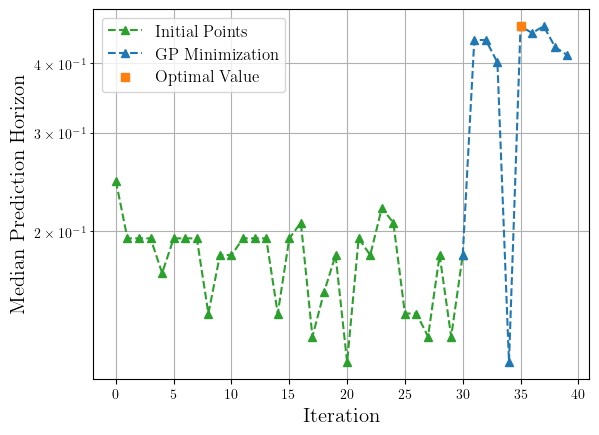

In [42]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

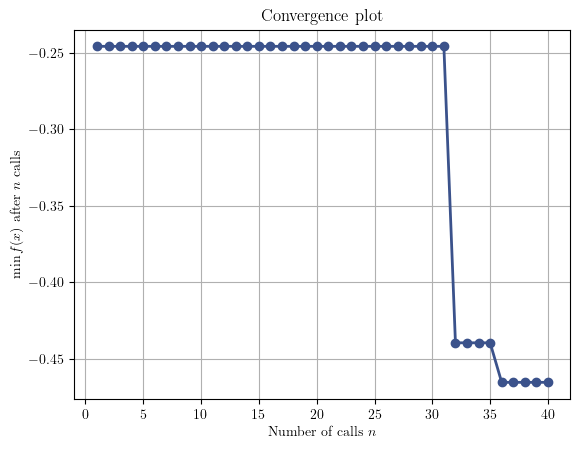

In [43]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [44]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

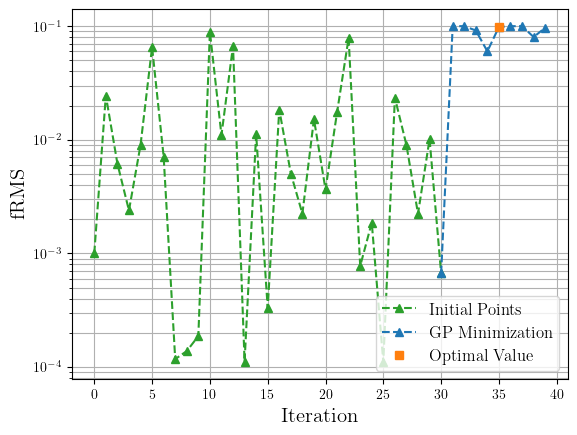

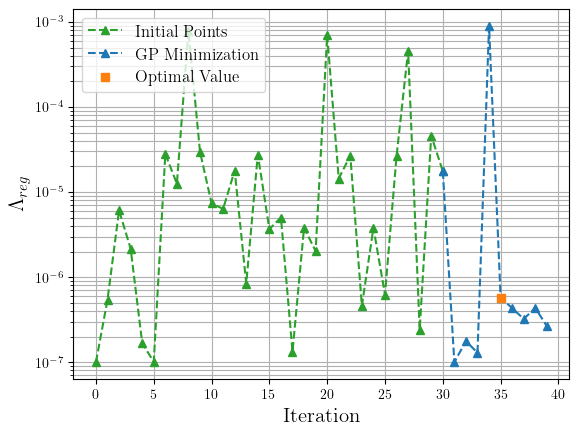

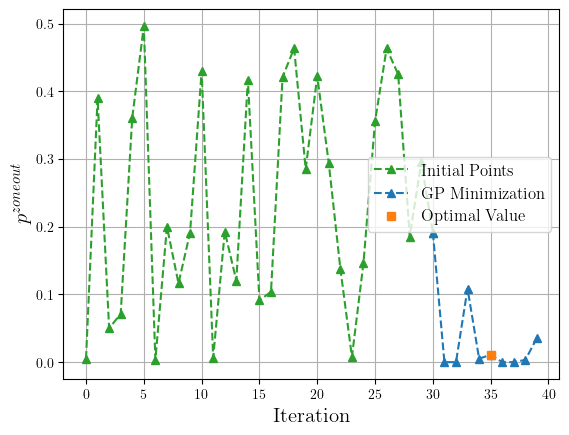

In [45]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$p^{zoneout}$', 'zoneout', plt.plot],
]

for i in range(len(xoptim_names)):
    a = n_initial_points
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [46]:
dir_list = os.listdir(dir_name_rnn+'/tested_rnn')
# dir_list

In [47]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_rnn/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [48]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [49]:
idx, dir_list[idx[0]]

(array([37]), 'test_rnn_038')

In [50]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

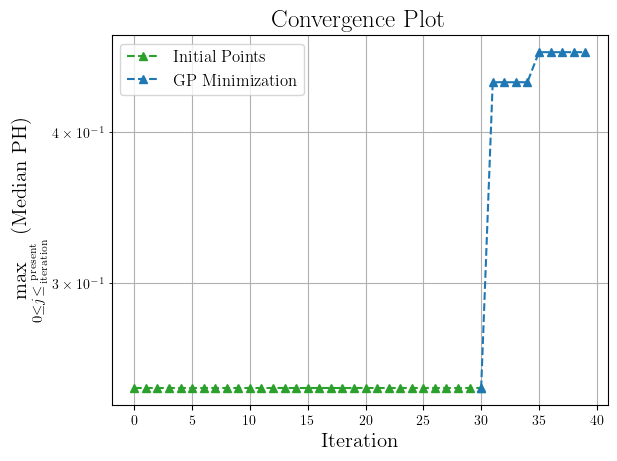

In [51]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation